In [1]:
'''import supporting libraries'''

# import xesmf as xe
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import os
try:
    from osgeo import gdal
except:
    import gdal
import sys
import rasterio
from rasterio.plot import show
import xarray as xr

sys.path.append(r'./code')


In [2]:
# Cropping function -- DO NOT MODIFY
def crop(ds,lons,lats):
    
    min_lat=lats[0]
    max_lat=lats[1]
    min_lon=lons[0]
    max_lon=lons[1]
    mask_lon = (ds.lon >= min_lon) & (ds.lon <= max_lon)
    mask_lat = (ds.lat >= min_lat) & (ds.lat <= max_lat)
    cropped_ds = ds.where(mask_lon & mask_lat, drop=True)

    return cropped_ds 


def regrid(ref_ds,ds):
    # Regrid to have the same pixel resolution as the higer res. observation data
    regridded_ds = ds.interp(lat=ref_ds.lat, lon=ref_ds.lon) #, method='nearest')

    return regridded_ds

In [3]:
BKK_lats = [13.5, 14.0]
BKK_lons = [100.28, 100.40]
BKK_mask = gdal.Open(r'TH_mask.tif').ReadAsArray()
BKK_mask[BKK_mask == 0] = np.nan

TH_lats = [5.0, 20.0]
TH_lons = [97.0, 105.0]


c:\Users\Acer\miniforge3\lib\site-packages\osgeo\gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


## Downscaling workflow of climatic data

### Observation (TerraClimate 2012-2022)

In [4]:
obs_tmin_in = xr.open_dataset(
    r"./hist_obs/obs_terraclim_tmin.nc", engine="netcdf4")['tmin'] 
obs_tmax_in = xr.open_dataset(
    r"./hist_obs/obs_terraclim_tmax.nc", engine="netcdf4")['tmax']
obs_pr_in = xr.open_dataset(
    r"./hist_obs/obs_terraclim_ppt.nc", engine="netcdf4")['ppt'] #from total monthly to total daily
obs_rhm_in = xr.open_dataset(
    r"./hist_obs/obs_terraclim_rhm.nc", engine="netcdf4")['rhm']
obs_ws_in = xr.open_dataset(
    r"./hist_obs/obs_terraclim_ws.nc", engine="netcdf4")['ws']
obs_srad_in = xr.open_dataset(
    r"./hist_obs/obs_terraclim_srad.nc", engine="netcdf4")['srad']

    #============================================================
# Crop observation data to Thailand
obs_tmin = crop(obs_tmin_in,TH_lons,TH_lats)
obs_tmax = crop(obs_tmax_in,TH_lons,TH_lats)
obs_pr = crop(obs_pr_in/30,TH_lons,TH_lats)
obs_rhm = crop(obs_rhm_in/100, TH_lons, TH_lats)
obs_ws = crop(obs_ws_in,TH_lons,TH_lats)
obs_srad = crop(obs_srad_in,TH_lons,TH_lats)

In [5]:
obs_tmin

<xarray.DataArray 'tmin' (month: 12, lat: 360, lon: 192)> Size: 3MB
array([[[10.111815 ,  9.51727  ,  9.42818  , ...,  9.819089 ,
          9.823635 , 10.33818  ],
        [10.409088 ,  9.940907 ,  9.683634 , ..., 10.998178 ,
         11.2136345, 10.630904 ],
        [10.437271 , 10.083632 ,  9.454543 , ..., 12.025452 ,
         12.899997 , 11.929998 ],
        ...,
        [23.97     , 24.50636  , 24.654541 , ...,        nan,
                nan,        nan],
        [23.466362 , 23.951815 , 24.38     , ...,        nan,
                nan,        nan],
        [23.013634 , 23.593634 , 24.266363 , ...,        nan,
                nan,        nan]],

       [[11.340907 , 10.82727  , 10.72727  , ..., 10.481814 ,
         10.595452 , 11.092726 ],
        [11.251815 , 11.100906 , 10.967271 , ..., 11.593635 ,
         11.87727  , 11.289088 ],
        [11.361815 , 11.23727  , 10.68636  , ..., 12.586362 ,
         13.422724 , 12.549088 ],
...
        [23.50636  , 24.055452 , 24.17     , ...,        nan,
                nan,        nan],
        [23.05818  , 23.539995 , 23.89636  , ...,        nan,
                nan,        nan],
        [22.578178 , 23.179998 , 23.74818  , ...,        nan,
                nan,        nan]],

       [[12.87727  , 11.912724 , 11.61636  , ..., 10.818178 ,
         10.926362 , 11.475452 ],
        [13.284543 , 12.624542 , 12.003633 , ..., 12.039089 ,
         12.348179 , 11.76727  ],
        [13.364542 , 12.76909  , 11.71727  , ..., 13.147269 ,
         14.099997 , 13.109997 ],
        ...,
        [23.848177 , 24.27727  , 24.423634 , ...,        nan,
                nan,        nan],
        [23.292725 , 23.789995 , 24.180906 , ...,        nan,
                nan,        nan],
        [22.851814 , 23.449999 , 24.06909  , ...,        nan,
                nan,        nan]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 3kB 19.98 19.94 19.9 19.85 ... 5.104 5.063 5.021
  * lon      (lon) float64 2kB 97.02 97.06 97.1 97.15 ... 104.9 104.9 105.0
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    units:              degC
    description:        Minimum 2-m Temperature
    long_name:          air_temperature
    standard_name:      air_temperature
    dimensions:         lon lat time
    grid_mapping:       crs
    coordinate_system:  WGS84,EPSG:4326

Text(0.5, 1.0, 'Solar Radiation(W/m2)')

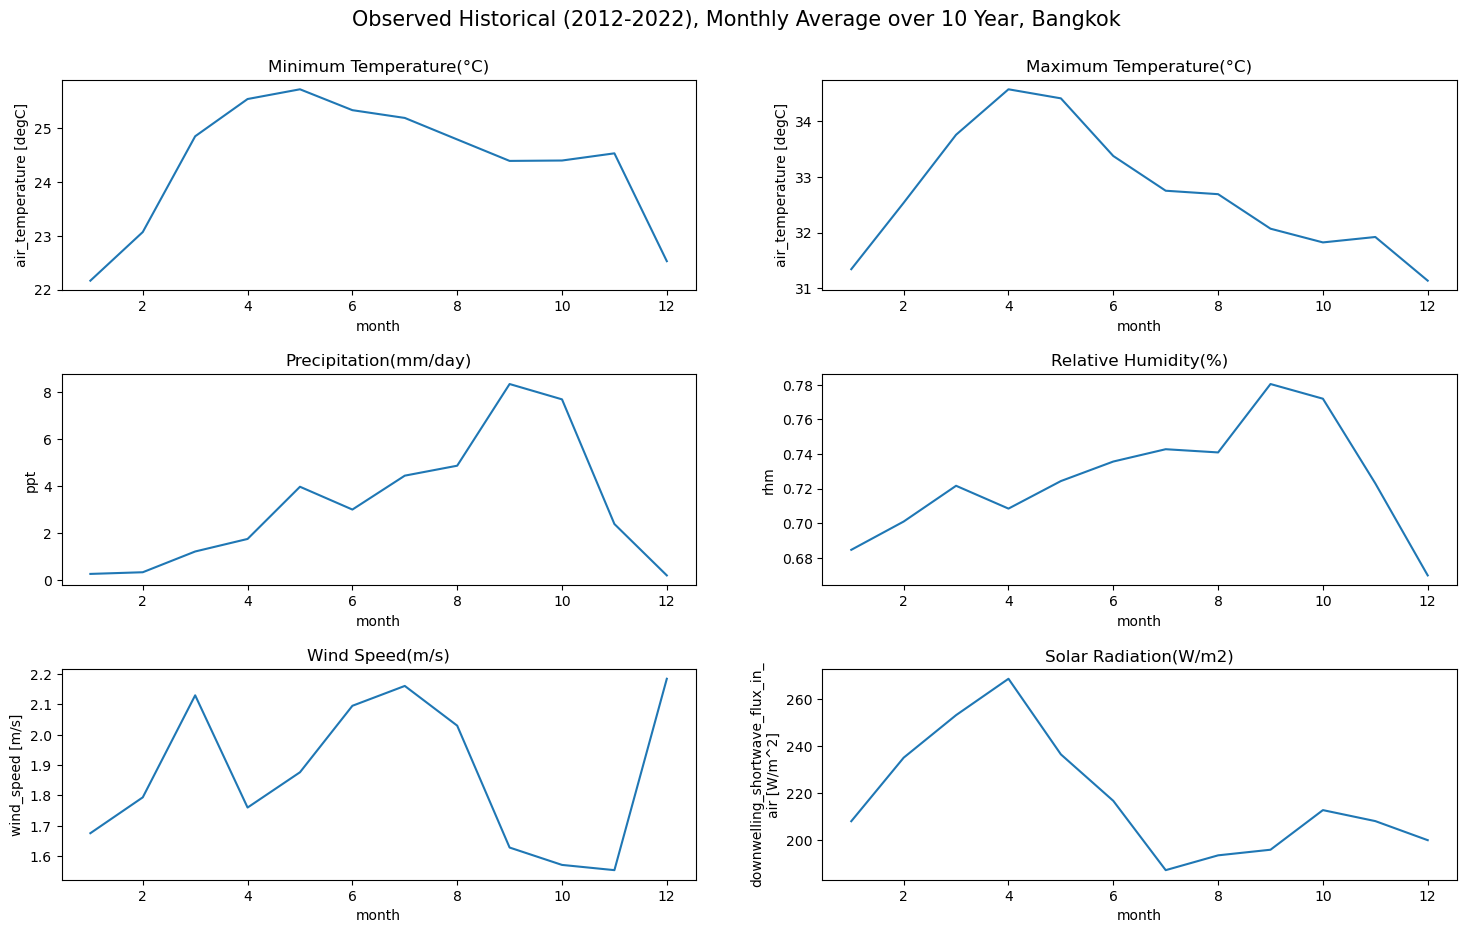

In [6]:
fig = plt.figure(figsize=(18,10))
fig.subplots_adjust(hspace=0.4, top=0.91)
# Add the main title
fig.suptitle("Observed Historical (2012-2022), Monthly Average over 10 Year, Bangkok", fontsize=15)
plt.subplot(3,2,1); obs_tmin.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').plot(); plt.title("Minimum Temperature(°C)")
plt.subplot(3,2,2); obs_tmax.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').plot(); plt.title("Maximum Temperature(°C)")
plt.subplot(3,2,3); obs_pr.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').plot(); plt.title("Precipitation(mm/day)")
plt.subplot(3,2,4); obs_rhm.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').plot(); plt.title("Relative Humidity(%)")
plt.subplot(3,2,5); obs_ws.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').plot(); plt.title("Wind Speed(m/s)")
plt.subplot(3,2,6); obs_srad.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').plot(); plt.title("Solar Radiation(W/m2)")

### CNRM - GCM - Historical data (1984-2014)

In [7]:
hist_tmin_in = xr.open_dataset(
    r"./hist_gcm/tasmin_Amon_CNRM-CM6-1-HR_historical_r1i1p1f2_gr_19840116-20141216_v20191021.nc", engine="netcdf4")['tasmin']
hist_tmax_in = xr.open_dataset(
    r"./hist_gcm/tasmax_Amon_CNRM-CM6-1-HR_historical_r1i1p1f2_gr_19840116-20141216_v20191021.nc", engine="netcdf4")['tasmax']
hist_pr_in = xr.open_dataset(
    r"./hist_gcm/pr_Amon_CNRM-CM6-1-HR_historical_r1i1p1f2_gr_19840116-20141216_v20191021.nc", engine="netcdf4")['pr']
hist_rhm_in = xr.open_dataset(
    r"./hist_gcm/hurs_Amon_CNRM-CM6-1-HR_historical_r1i1p1f2_gr_19840116-20141216_v20191021.nc", engine="netcdf4")['hurs']
hist_ws_in = xr.open_dataset(
    r"./hist_gcm/sfcWind_Amon_CNRM-CM6-1-HR_historical_r1i1p1f2_gr_19840116-20141216_v20191021.nc", engine="netcdf4")['sfcWind']
hist_srad_in = xr.open_dataset(
    r"./hist_gcm/rsds_Amon_CNRM-CM6-1-HR_historical_r1i1p1f2_gr_19840116-20141216_v20191021.nc", engine="netcdf4")['rsds']

hist_tmin_cropped = crop(hist_tmin_in-273.15,  TH_lons, TH_lats)
hist_tmax_cropped = crop(hist_tmax_in-273.15, TH_lons, TH_lats)
hist_pr_cropped = crop(hist_pr_in*86400, TH_lons, TH_lats)
hist_rhm_cropped = crop(hist_rhm_in/100, TH_lons, TH_lats)
hist_ws_cropped = crop(hist_ws_in, TH_lons, TH_lats)
hist_srad_cropped = crop(hist_srad_in, TH_lons, TH_lats)
# ============================================================

# Regrid gcm_data to Thailand
# Regrid observation data to Thailand
hist_tmin = regrid(obs_tmin, hist_tmin_cropped).groupby(
    'time.month').mean(dim='time')
hist_tmax = regrid(obs_tmax, hist_tmax_cropped).groupby(
    'time.month').mean(dim='time')
hist_pr = regrid(obs_pr, hist_pr_cropped).groupby(
    'time.month').mean(dim='time')
hist_rhm = regrid(obs_rhm, hist_rhm_cropped).groupby(
    'time.month').mean(dim='time')
hist_ws = regrid(obs_ws, hist_ws_cropped).groupby(
    'time.month').mean(dim='time')
hist_srad = regrid(obs_srad, hist_srad_cropped).groupby(
    'time.month').mean(dim='time')
# ============================================================


Text(0.5, 1.0, 'Solar Radiation(W/m2)')

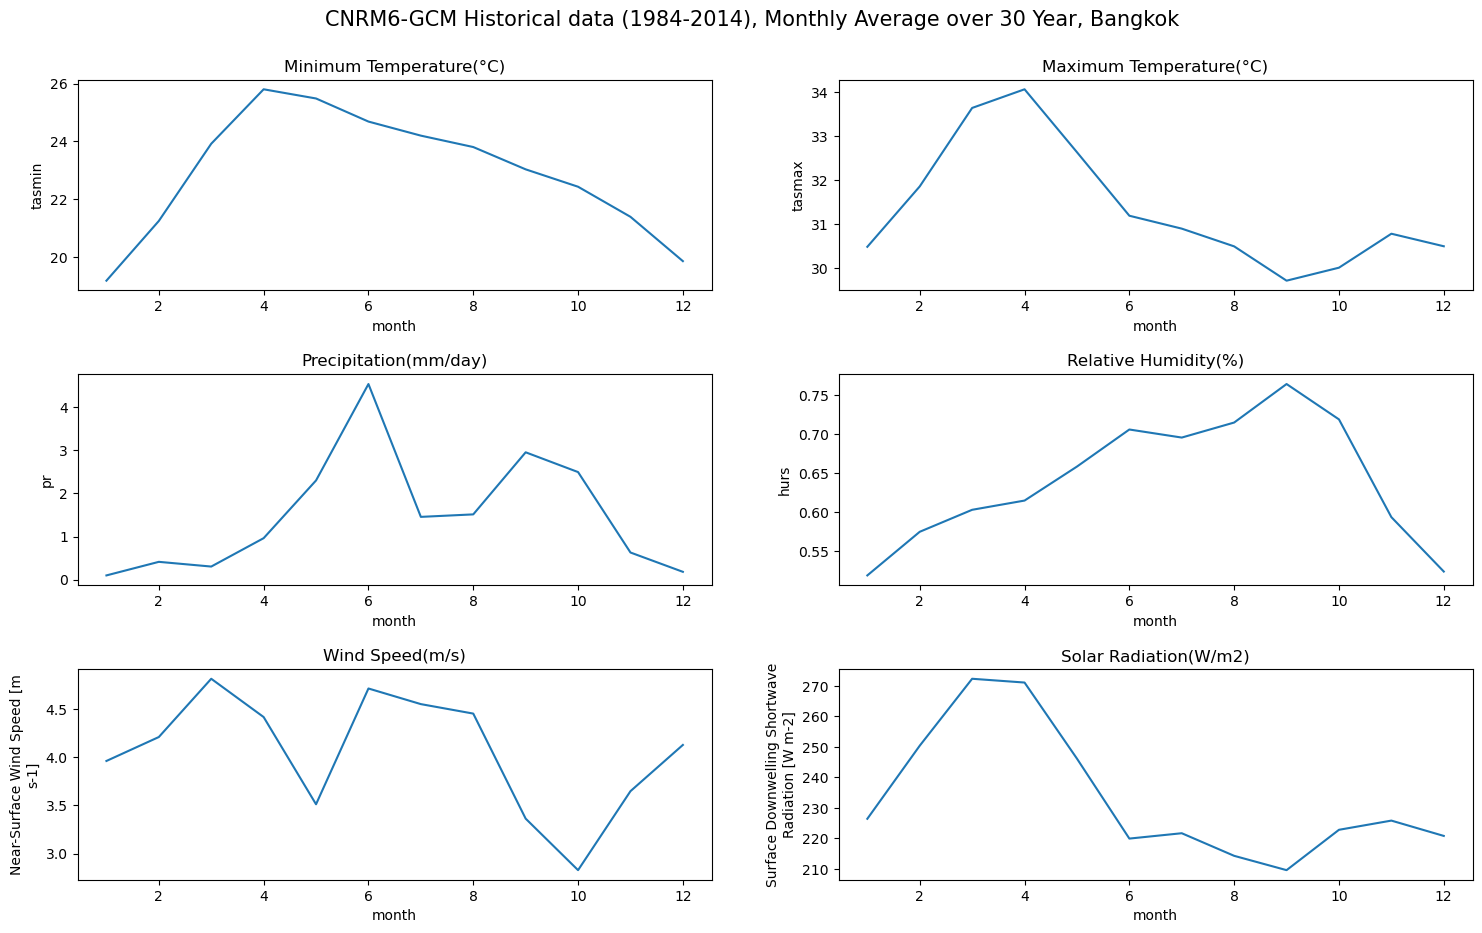

In [8]:
fig = plt.figure(figsize=(18,10))
fig.subplots_adjust(hspace=0.4, top=0.91)
# Add the main title
fig.suptitle("CNRM6-GCM Historical data (1984-2014), Monthly Average over 30 Year, Bangkok", fontsize=15)
plt.subplot(3,2,1); hist_tmin.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').plot(); plt.title("Minimum Temperature(°C)")
plt.subplot(3,2,2); hist_tmax.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').plot(); plt.title("Maximum Temperature(°C)")
plt.subplot(3,2,3); hist_pr.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').plot(); plt.title("Precipitation(mm/day)")
plt.subplot(3,2,4); hist_rhm.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').plot(); plt.title("Relative Humidity(%)")
plt.subplot(3,2,5); hist_ws.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').plot(); plt.title("Wind Speed(m/s)")
plt.subplot(3,2,6); hist_srad.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').plot(); plt.title("Solar Radiation(W/m2)")

## MIROC-ES2H (Japan) (1984-2014)

In [9]:
gcm_miroc6_tmin_in = xr.open_dataset(
    r"./gcm_miroc6/hist/tasmin_Amon_MIROC-ES2H_historical_r1i1p4f2_gn_19840116-20141216_v20220322.nc", engine="netcdf4")['tasmin'] 
gcm_miroc6_tmax_in = xr.open_dataset(
    r"./gcm_miroc6/hist/tasmax_Amon_MIROC-ES2H_historical_r1i1p4f2_gn_19840116-20141216_v20220322.nc", engine="netcdf4")['tasmax']
gcm_miroc6_pr_in = xr.open_dataset(
    r"./gcm_miroc6/hist/pr_Amon_MIROC-ES2H_historical_r1i1p4f2_gn_19840116-20141216_v20220322.nc", engine="netcdf4")['pr'] #from total monthly to total daily
gcm_miroc6_rhm_in = xr.open_dataset(
    r"./gcm_miroc6/hist/hurs_Amon_MIROC-ES2H_historical_r1i1p4f2_gn_19840116-20141216_v20220322.nc", engine="netcdf4")['hurs']
gcm_miroc6_ws_in = xr.open_dataset(
    r"./gcm_miroc6/hist/sfcWind_Amon_MIROC-ES2H_historical_r1i1p4f2_gn_19840116-20141216_v20220322.nc", engine="netcdf4")['sfcWind']
gcm_miroc6_srad_in = xr.open_dataset(
    r"./gcm_miroc6/hist/rsds_Amon_MIROC-ES2H_historical_r1i1p4f2_gn_19840116-20141216_v20220322.nc", engine="netcdf4")['rsds']

gcm_miroc6_tmin_cropped = crop(gcm_miroc6_tmin_in-273.15,  TH_lons, TH_lats)
gcm_miroc6_tmax_cropped = crop(gcm_miroc6_tmax_in-273.15, TH_lons, TH_lats)
gcm_miroc6_pr_cropped = crop(gcm_miroc6_pr_in*86400, TH_lons, TH_lats)
gcm_miroc6_rhm_cropped = crop(gcm_miroc6_rhm_in/100, TH_lons, TH_lats)
gcm_miroc6_ws_cropped = crop(gcm_miroc6_ws_in, TH_lons, TH_lats)
gcm_miroc6_srad_cropped = crop(gcm_miroc6_srad_in, TH_lons, TH_lats)
# ============================================================

# Regrid gcm_data to Thailand
# Regrid observation data to Thailand
gcm_miroc6_tmin = regrid(obs_tmin, gcm_miroc6_tmin_cropped).groupby(
    'time.month').mean(dim='time')
gcm_miroc6_tmax = regrid(obs_tmax, gcm_miroc6_tmax_cropped).groupby(
    'time.month').mean(dim='time')
gcm_miroc6_pr = regrid(obs_pr, gcm_miroc6_pr_cropped).groupby(
    'time.month').mean(dim='time')
gcm_miroc6_rhm = regrid(obs_rhm, gcm_miroc6_rhm_cropped).groupby(
    'time.month').mean(dim='time')
gcm_miroc6_ws = regrid(obs_ws, gcm_miroc6_ws_cropped).groupby(
    'time.month').mean(dim='time')
gcm_miroc6_srad = regrid(obs_srad, gcm_miroc6_srad_cropped).groupby(
    'time.month').mean(dim='time')


Text(0.5, 1.0, 'Solar Radiation(W/m2)')

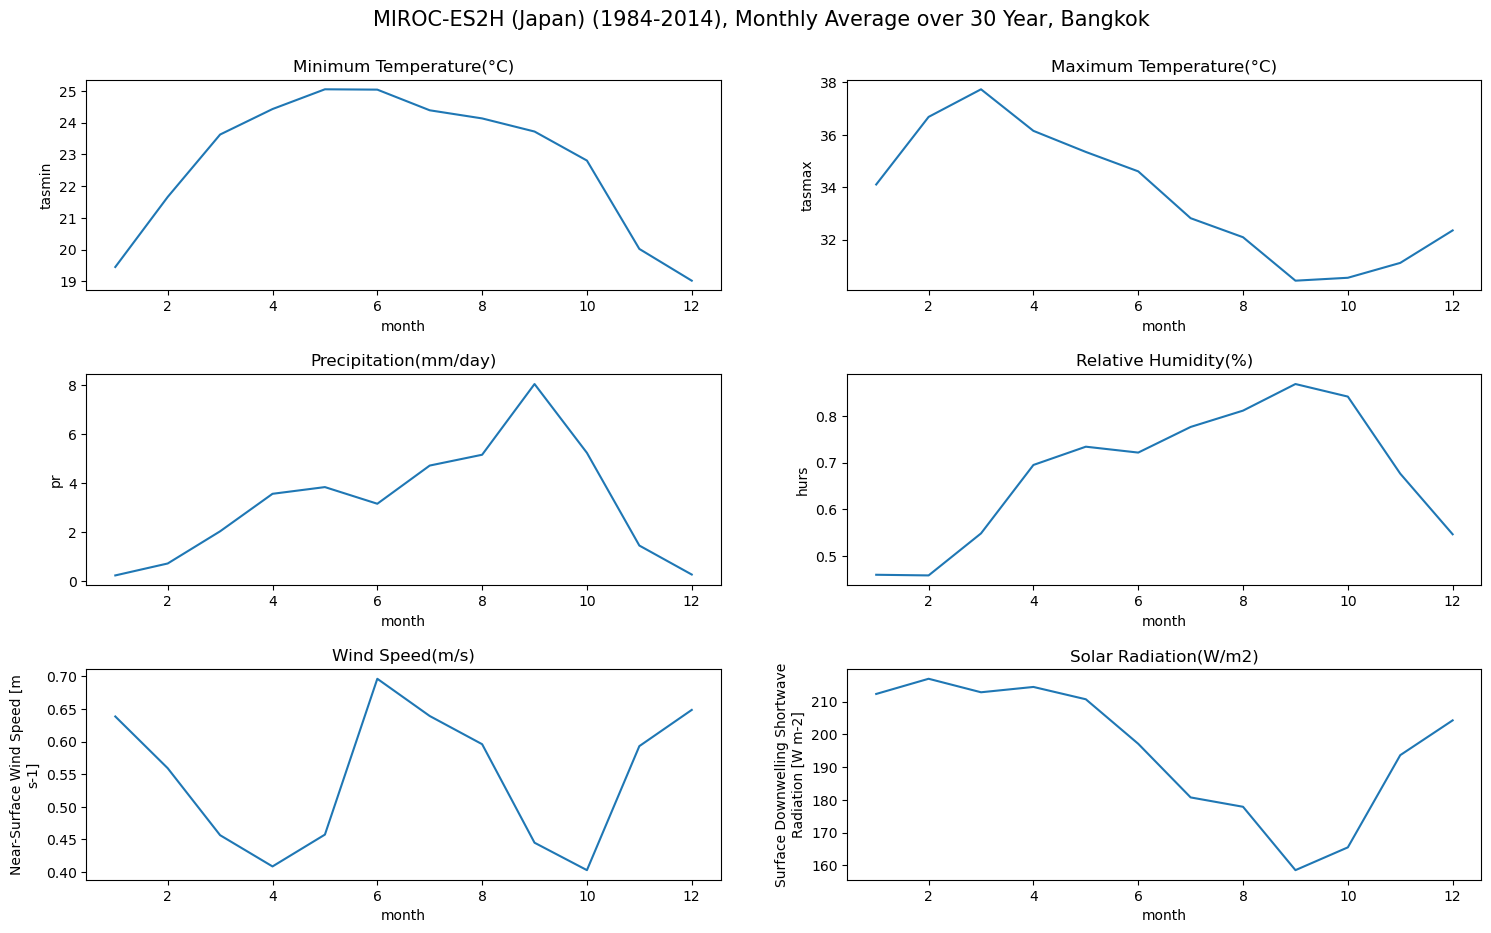

In [10]:
fig = plt.figure(figsize=(18,10))
fig.subplots_adjust(hspace=0.4, top=0.91)
# Add the main title
fig.suptitle("MIROC-ES2H (Japan) (1984-2014), Monthly Average over 30 Year, Bangkok", fontsize=15)
plt.subplot(3,2,1); gcm_miroc6_tmin.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').plot(); plt.title("Minimum Temperature(°C)")
plt.subplot(3,2,2); gcm_miroc6_tmax.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').plot(); plt.title("Maximum Temperature(°C)")
plt.subplot(3,2,3); gcm_miroc6_pr.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').plot(); plt.title("Precipitation(mm/day)")
plt.subplot(3,2,4); gcm_miroc6_rhm.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').plot(); plt.title("Relative Humidity(%)")
plt.subplot(3,2,5); gcm_miroc6_ws.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').plot(); plt.title("Wind Speed(m/s)")
plt.subplot(3,2,6); gcm_miroc6_srad.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').plot(); plt.title("Solar Radiation(W/m2)")

## EC-Earth3-CC (Europe) (1984-2014)

In [11]:
gcm_ec_earth_tmin_in = xr.open_dataset(
    r"./gcm_ec_earth/hist/tasmin_Amon_EC-Earth3-CC_historical_r1i1p1f1_gr_19840116-20141216_v20210113.nc", engine="netcdf4")['tasmin'] 
gcm_ec_earth_tmax_in = xr.open_dataset(
    r"./gcm_ec_earth/hist/tasmax_Amon_EC-Earth3-CC_historical_r1i1p1f1_gr_19840116-20141216_v20210113.nc", engine="netcdf4")['tasmax']
gcm_ec_earth_pr_in = xr.open_dataset(
    r"./gcm_ec_earth/hist/pr_Amon_EC-Earth3-CC_historical_r1i1p1f1_gr_19840116-20141216_v20210113.nc", engine="netcdf4")['pr'] #from total monthly to total daily
gcm_ec_earth_rhm_in = xr.open_dataset(
    r"./gcm_ec_earth/hist/hurs_Amon_EC-Earth3-CC_historical_r1i1p1f1_gr_19840116-20141216_v20210113.nc", engine="netcdf4")['hurs']
gcm_ec_earth_ws_in = xr.open_dataset(
    r"./gcm_ec_earth/hist/sfcWind_Amon_EC-Earth3-CC_historical_r1i1p1f1_gr_19840116-20141216_v20210113.nc", engine="netcdf4")['sfcWind']
gcm_ec_earth_srad_in = xr.open_dataset(
    r"./gcm_ec_earth/hist/rsds_Amon_EC-Earth3-CC_historical_r1i1p1f1_gr_19840116-20141216_v20210113.nc", engine="netcdf4")['rsds']

gcm_ec_earth_tmin_cropped = crop(gcm_ec_earth_tmin_in-273.15,  TH_lons, TH_lats)
gcm_ec_earth_tmax_cropped = crop(gcm_ec_earth_tmax_in-273.15, TH_lons, TH_lats)
gcm_ec_earth_pr_cropped = crop(gcm_ec_earth_pr_in*86400, TH_lons, TH_lats)
gcm_ec_earth_rhm_cropped = crop(gcm_ec_earth_rhm_in/100, TH_lons, TH_lats)
gcm_ec_earth_ws_cropped = crop(gcm_ec_earth_ws_in, TH_lons, TH_lats)
gcm_ec_earth_srad_cropped = crop(gcm_ec_earth_srad_in, TH_lons, TH_lats)
# ============================================================

# Regrid gcm_data to Thailand
# Regrid observation data to Thailand
gcm_ec_earth_tmin = regrid(obs_tmin, gcm_ec_earth_tmin_cropped).groupby(
    'time.month').mean(dim='time')
gcm_ec_earth_tmax = regrid(obs_tmax, gcm_ec_earth_tmax_cropped).groupby(
    'time.month').mean(dim='time')
gcm_ec_earth_pr = regrid(obs_pr, gcm_ec_earth_pr_cropped).groupby(
    'time.month').mean(dim='time')
gcm_ec_earth_rhm = regrid(obs_rhm, gcm_ec_earth_rhm_cropped).groupby(
    'time.month').mean(dim='time')
gcm_ec_earth_ws = regrid(obs_ws, gcm_ec_earth_ws_cropped).groupby(
    'time.month').mean(dim='time')
gcm_ec_earth_srad = regrid(obs_srad, gcm_ec_earth_srad_cropped).groupby(
    'time.month').mean(dim='time')
 

Text(0.5, 1.0, 'Solar Radiation(W/m2)')

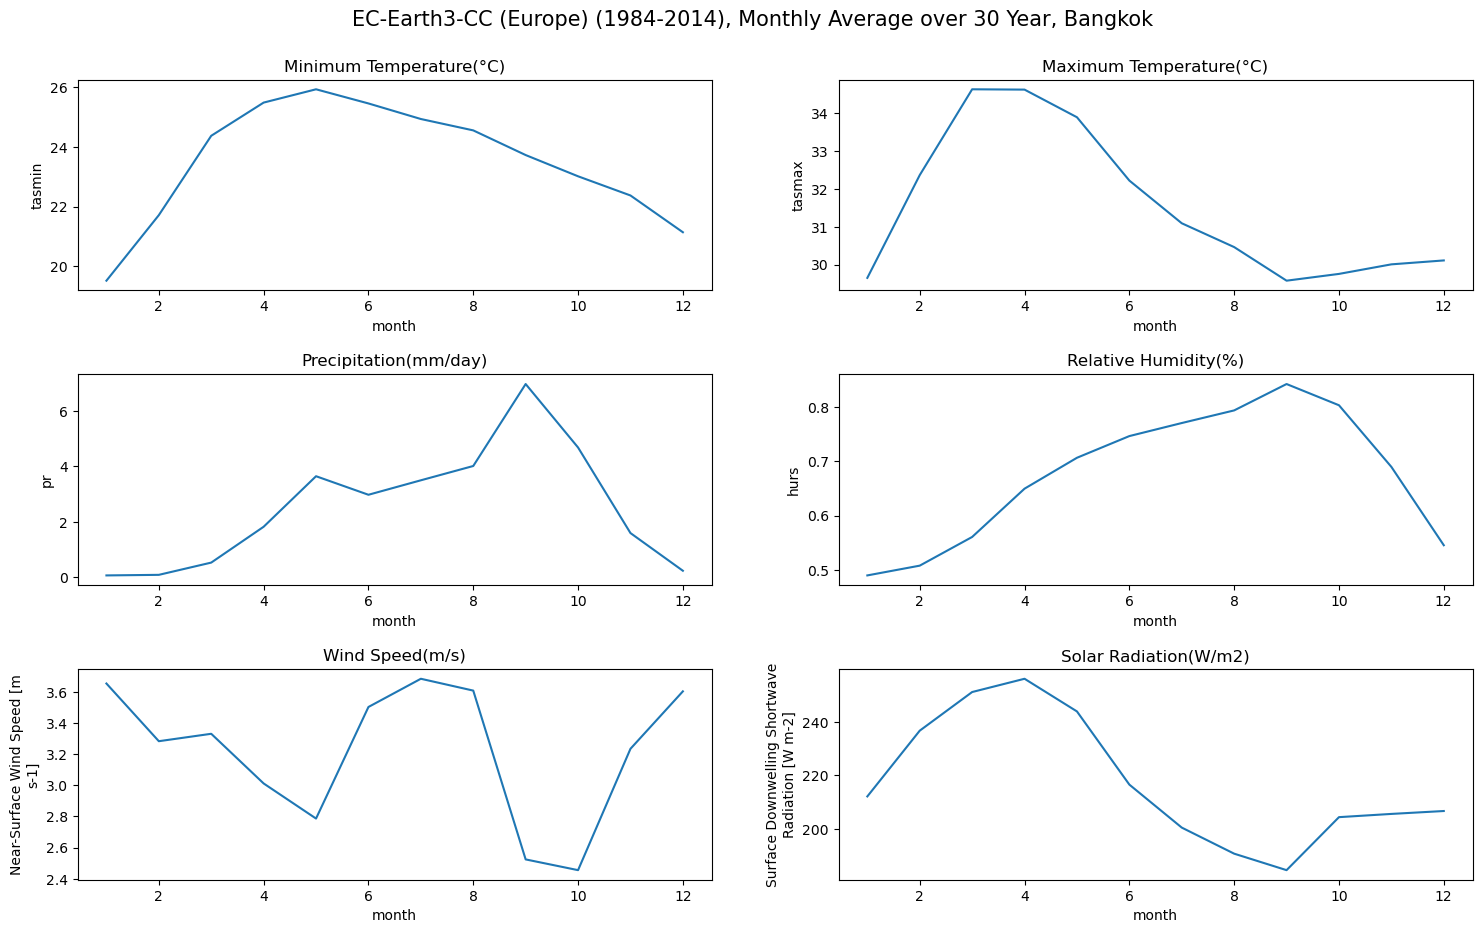

In [12]:
fig = plt.figure(figsize=(18,10))
fig.subplots_adjust(hspace=0.4, top=0.91)
# Add the main title
fig.suptitle("EC-Earth3-CC (Europe) (1984-2014), Monthly Average over 30 Year, Bangkok", fontsize=15)
plt.subplot(3,2,1); gcm_ec_earth_tmin.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').plot(); plt.title("Minimum Temperature(°C)")
plt.subplot(3,2,2); gcm_ec_earth_tmax.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').plot(); plt.title("Maximum Temperature(°C)")
plt.subplot(3,2,3); gcm_ec_earth_pr.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').plot(); plt.title("Precipitation(mm/day)")
plt.subplot(3,2,4); gcm_ec_earth_rhm.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').plot(); plt.title("Relative Humidity(%)")
plt.subplot(3,2,5); gcm_ec_earth_ws.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').plot(); plt.title("Wind Speed(m/s)")
plt.subplot(3,2,6); gcm_ec_earth_srad.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').plot(); plt.title("Solar Radiation(W/m2)")

#### Comparison Model

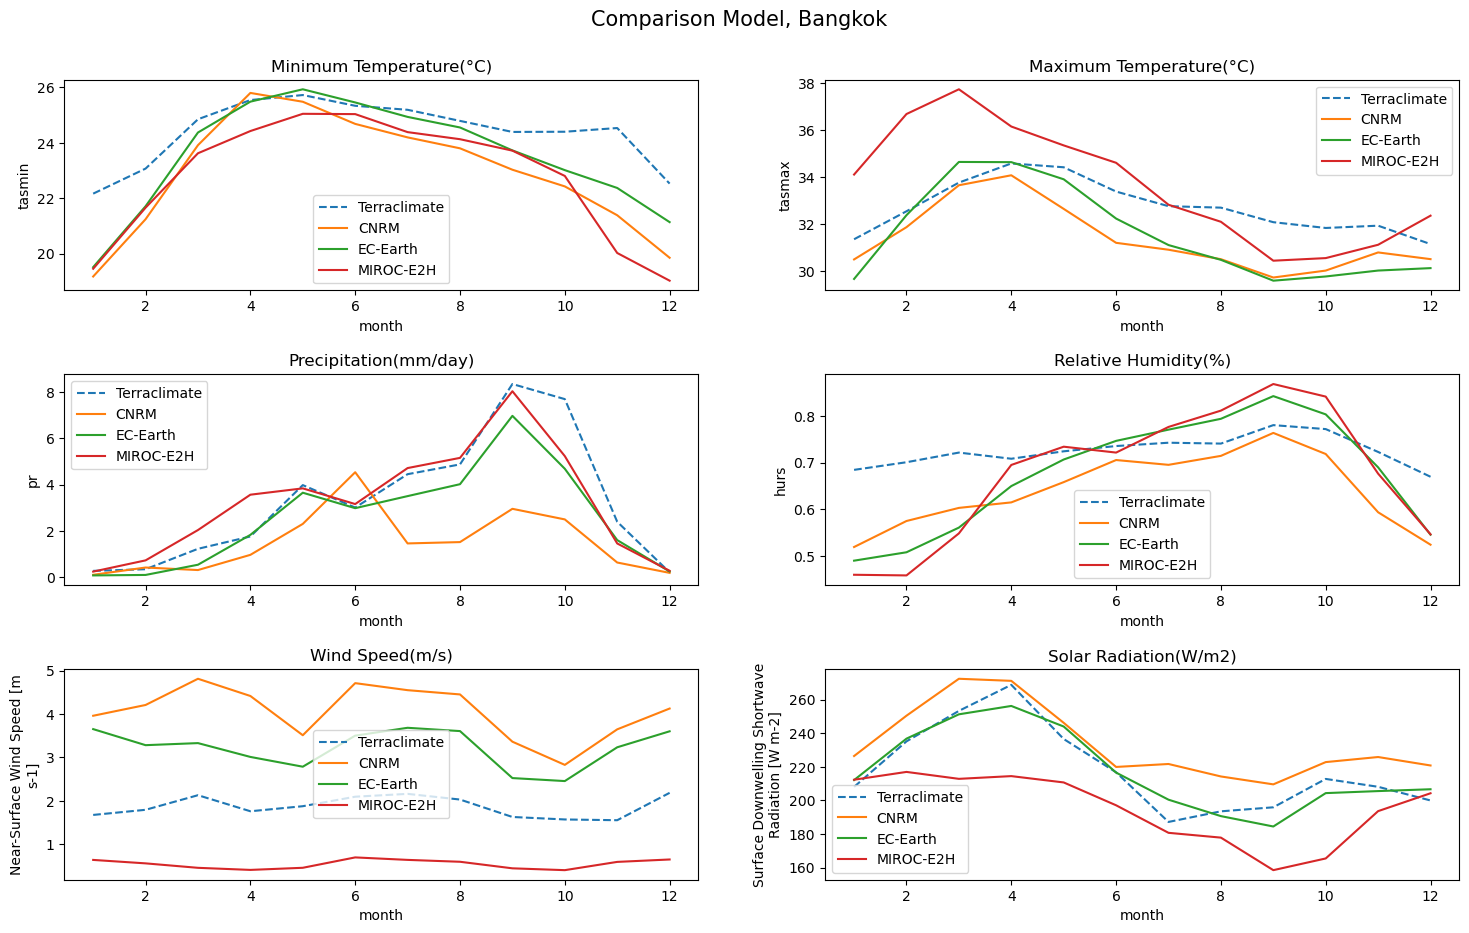

In [13]:
fig = plt.figure(figsize=(18,10))
fig.subplots_adjust(hspace=0.4, top=0.91)
# Add the main title
fig.suptitle("Comparison Model, Bangkok", fontsize=15)

#Terraclimate
plt.subplot(3,2,1); obs_tmin.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').plot(label='Terraclimate', linestyle = "--"); plt.title("Minimum Temperature(°C)")
plt.legend()
plt.subplot(3,2,2); obs_tmax.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').plot(label='Terraclimate', linestyle = "--"); plt.title("Maximum Temperature(°C)")
plt.legend()
plt.subplot(3,2,3); obs_pr.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').plot(label='Terraclimate', linestyle = "--"); plt.title("Precipitation(mm/day)")
plt.legend()
plt.subplot(3,2,4); obs_rhm.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').plot(label='Terraclimate', linestyle = "--"); plt.title("Relative Humidity(%)")
plt.legend()
plt.subplot(3,2,5); obs_ws.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').plot(label='Terraclimate', linestyle = "--"); plt.title("Wind Speed(m/s)")
plt.legend()
plt.subplot(3,2,6); obs_srad.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').plot(label='Terraclimate', linestyle = "--"); plt.title("Solar Radiation(W/m2)")
plt.legend()

#CNRM
plt.subplot(3,2,1); hist_tmin.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').plot(label='CNRM'); plt.title("Minimum Temperature(°C)")
plt.legend()
plt.subplot(3,2,2); hist_tmax.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').plot(label='CNRM'); plt.title("Maximum Temperature(°C)")
plt.legend()
plt.subplot(3,2,3); hist_pr.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').plot(label='CNRM'); plt.title("Precipitation(mm/day)")
plt.legend()
plt.subplot(3,2,4); hist_rhm.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').plot(label='CNRM'); plt.title("Relative Humidity(%)")
plt.legend()
plt.subplot(3,2,5); hist_ws.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').plot(label='CNRM'); plt.title("Wind Speed(m/s)")
plt.legend()
plt.subplot(3,2,6); hist_srad.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').plot(label='CNRM'); plt.title("Solar Radiation(W/m2)")
plt.legend()

#EC-Earth
plt.subplot(3,2,1); gcm_ec_earth_tmin.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').plot(label='EC-Earth'); plt.title("Minimum Temperature(°C)")
plt.legend()
plt.subplot(3,2,2); gcm_ec_earth_tmax.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').plot(label='EC-Earth'); plt.title("Maximum Temperature(°C)")
plt.legend()
plt.subplot(3,2,3); gcm_ec_earth_pr.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').plot(label='EC-Earth'); plt.title("Precipitation(mm/day)")
plt.legend()
plt.subplot(3,2,4); gcm_ec_earth_rhm.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').plot(label='EC-Earth'); plt.title("Relative Humidity(%)")
plt.legend()
plt.subplot(3,2,5); gcm_ec_earth_ws.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').plot(label='EC-Earth'); plt.title("Wind Speed(m/s)")
plt.legend()
plt.subplot(3,2,6); gcm_ec_earth_srad.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').plot(label='EC-Earth'); plt.title("Solar Radiation(W/m2)")
plt.legend()

#MIROC
plt.subplot(3,2,1); gcm_miroc6_tmin.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').plot(label='MIROC-E2H'); plt.title("Minimum Temperature(°C)")
plt.legend()
plt.subplot(3,2,2); gcm_miroc6_tmax.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').plot(label='MIROC-E2H'); plt.title("Maximum Temperature(°C)")
plt.legend()
plt.subplot(3,2,3); gcm_miroc6_pr.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').plot(label='MIROC-E2H'); plt.title("Precipitation(mm/day)")
plt.legend()
plt.subplot(3,2,4); gcm_miroc6_rhm.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').plot(label='MIROC-E2H'); plt.title("Relative Humidity(%)")
plt.legend()
plt.subplot(3,2,5); gcm_miroc6_ws.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').plot(label='MIROC-E2H'); plt.title("Wind Speed(m/s)")
plt.legend()
plt.subplot(3,2,6); gcm_miroc6_srad.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').plot(label='MIROC-E2H'); plt.title("Solar Radiation(W/m2)")
plt.legend()

### Statistic Analyst

### RMSE - all model

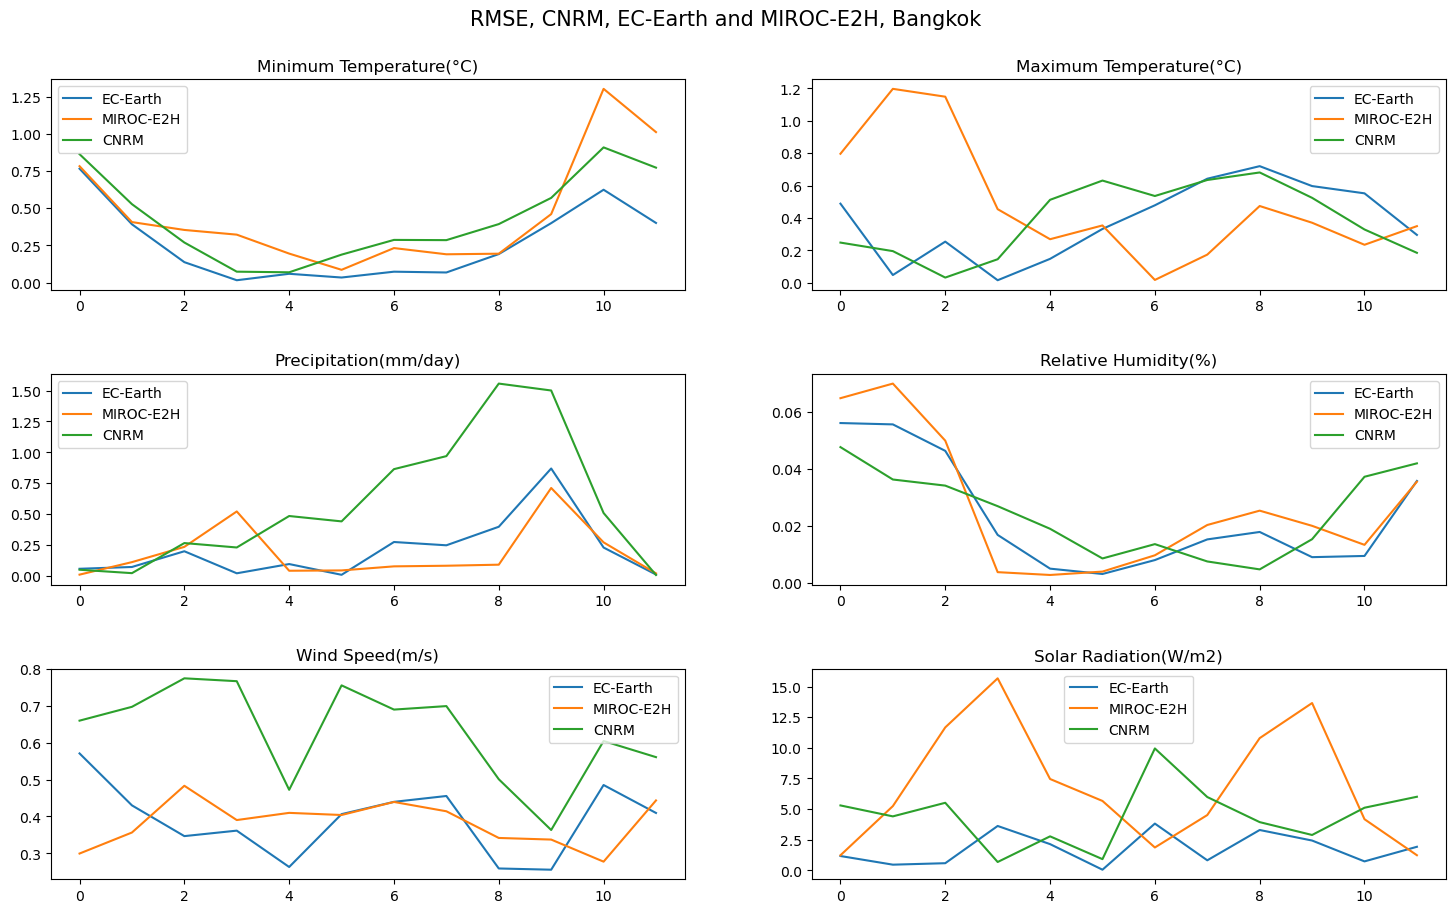

In [14]:
def rmse(obs, model):
    n = np.shape(obs)
    output = np.sqrt(((model-obs)**2)/ n)
    return output

fig = plt.figure(figsize=(18,10))
fig.subplots_adjust(hspace=0.4, top=0.91)
fig.suptitle("RMSE, CNRM, EC-Earth and MIROC-E2H, Bangkok", fontsize=15)
plt.subplot(3,2,1); plt.title("Minimum Temperature(°C)")
a1 = rmse(obs_tmin.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values, gcm_ec_earth_tmin.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values)
b1 = rmse(obs_tmin.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values, gcm_miroc6_tmin.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values)
c1 = rmse(obs_tmin.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values, hist_tmin.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values)
plt.plot(a1,label='EC-Earth')
plt.plot(b1,label='MIROC-E2H')
plt.plot(c1,label='CNRM')
plt.legend()

plt.subplot(3,2,2); plt.title("Maximum Temperature(°C)")
a2 = rmse(obs_tmax.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values, gcm_ec_earth_tmax.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values)
b2 = rmse(obs_tmax.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values, gcm_miroc6_tmax.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values)
c2 = rmse(obs_tmax.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values, hist_tmax.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values)
plt.plot(a2,label='EC-Earth')
plt.plot(b2,label='MIROC-E2H')
plt.plot(c2,label='CNRM')
plt.legend()

plt.subplot(3,2,3); plt.title("Precipitation(mm/day)")
a3 = rmse(obs_pr.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values, gcm_ec_earth_pr.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values)
b3 = rmse(obs_pr.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values, gcm_miroc6_pr.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values)
c3 = rmse(obs_pr.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values, hist_pr.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values)
plt.plot(a3,label='EC-Earth')
plt.plot(b3,label='MIROC-E2H')
plt.plot(c3,label='CNRM')
plt.legend()

plt.subplot(3,2,4); plt.title("Relative Humidity(%)")
a4 = rmse(obs_rhm.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values, gcm_ec_earth_rhm.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values)
b4 = rmse(obs_rhm.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values, gcm_miroc6_rhm.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values)
c4 = rmse(obs_rhm.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values, hist_rhm.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values)
plt.plot(a4,label='EC-Earth')
plt.plot(b4,label='MIROC-E2H')
plt.plot(c4,label='CNRM')
plt.legend()

plt.subplot(3,2,5); plt.title("Wind Speed(m/s)")
a5 = rmse(obs_ws.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values, gcm_ec_earth_ws.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values)
b5 = rmse(obs_ws.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values, gcm_miroc6_ws.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values)
c5 = rmse(obs_ws.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values, hist_ws.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values)
plt.plot(a5,label='EC-Earth')
plt.plot(b5,label='MIROC-E2H')
plt.plot(c5,label='CNRM')
plt.legend()

plt.subplot(3,2,6); plt.title("Solar Radiation(W/m2)")
a6 = rmse(obs_srad.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values, gcm_ec_earth_srad.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values)
b6 = rmse(obs_srad.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values, gcm_miroc6_srad.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values)
c6 = rmse(obs_srad.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values, hist_srad.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values)
plt.plot(a6,label='EC-Earth')
plt.plot(b6,label='MIROC-E2H')
plt.plot(c6,label='CNRM')
plt.legend()




### MAE all model

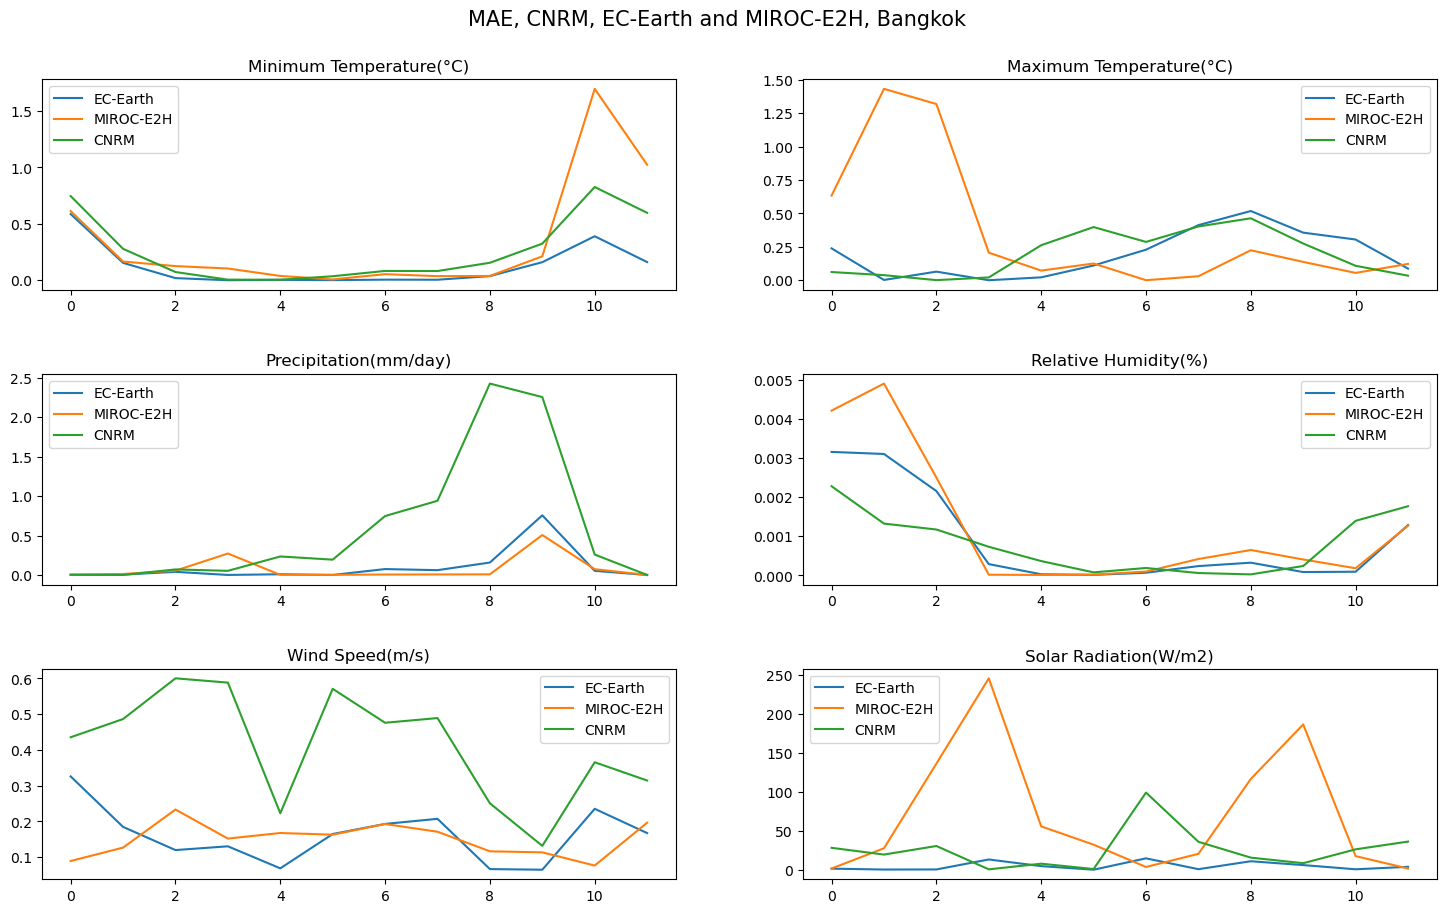

In [15]:
def mae (obs, model):
    n=np.shape(obs)
    b = np.abs(obs-model)**2 / n
    return b

fig = plt.figure(figsize=(18,10))
fig.subplots_adjust(hspace=0.4, top=0.91)

fig.suptitle("MAE, CNRM, EC-Earth and MIROC-E2H, Bangkok", fontsize=15)
plt.subplot(3,2,1); plt.title("Minimum Temperature(°C)")
d1 = mae(obs_tmin.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values, gcm_ec_earth_tmin.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values)
d2 = mae(obs_tmin.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values, gcm_miroc6_tmin.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values)
d3 = mae(obs_tmin.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values, hist_tmin.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values)
plt.plot(d1,label='EC-Earth')
plt.plot(d2,label='MIROC-E2H')
plt.plot(d3,label='CNRM')
plt.legend()

plt.subplot(3,2,2); plt.title("Maximum Temperature(°C)")
e1 = mae(obs_tmax.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values, gcm_ec_earth_tmax.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values)
e2 = mae(obs_tmax.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values, gcm_miroc6_tmax.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values)
e3 = mae(obs_tmax.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values, hist_tmax.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values)
plt.plot(e1,label='EC-Earth')
plt.plot(e2,label='MIROC-E2H')
plt.plot(e3,label='CNRM')
plt.legend()

plt.subplot(3,2,3); plt.title("Precipitation(mm/day)")
f1 = mae(obs_pr.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values, gcm_ec_earth_pr.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values)
f2 = mae(obs_pr.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values, gcm_miroc6_pr.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values)
f3 = mae(obs_pr.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values, hist_pr.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values)
plt.plot(f1,label='EC-Earth')
plt.plot(f2,label='MIROC-E2H')
plt.plot(f3,label='CNRM')
plt.legend()

plt.subplot(3,2,4); plt.title("Relative Humidity(%)")
i1 = mae(obs_rhm.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values, gcm_ec_earth_rhm.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values)
i2 = mae(obs_rhm.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values, gcm_miroc6_rhm.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values)
i3 = mae(obs_rhm.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values, hist_rhm.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values)
plt.plot(i1,label='EC-Earth')
plt.plot(i2,label='MIROC-E2H')
plt.plot(i3,label='CNRM')
plt.legend()

plt.subplot(3,2,5); plt.title("Wind Speed(m/s)")
j1 = mae(obs_ws.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values, gcm_ec_earth_ws.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values)
j2 = mae(obs_ws.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values, gcm_miroc6_ws.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values)
j3 = mae(obs_ws.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values, hist_ws.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values)
plt.plot(j1,label='EC-Earth')
plt.plot(j2,label='MIROC-E2H')
plt.plot(j3,label='CNRM')
plt.legend()

plt.subplot(3,2,6); plt.title("Solar Radiation(W/m2)")
k1 = mae(obs_srad.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values, gcm_ec_earth_srad.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values)
k2 = mae(obs_srad.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values, gcm_miroc6_srad.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values)
k3 = mae(obs_srad.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values, hist_srad.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values)
plt.plot(k1,label='EC-Earth')
plt.plot(k2,label='MIROC-E2H')
plt.plot(k3,label='CNRM')
plt.legend()

### R**2 all model

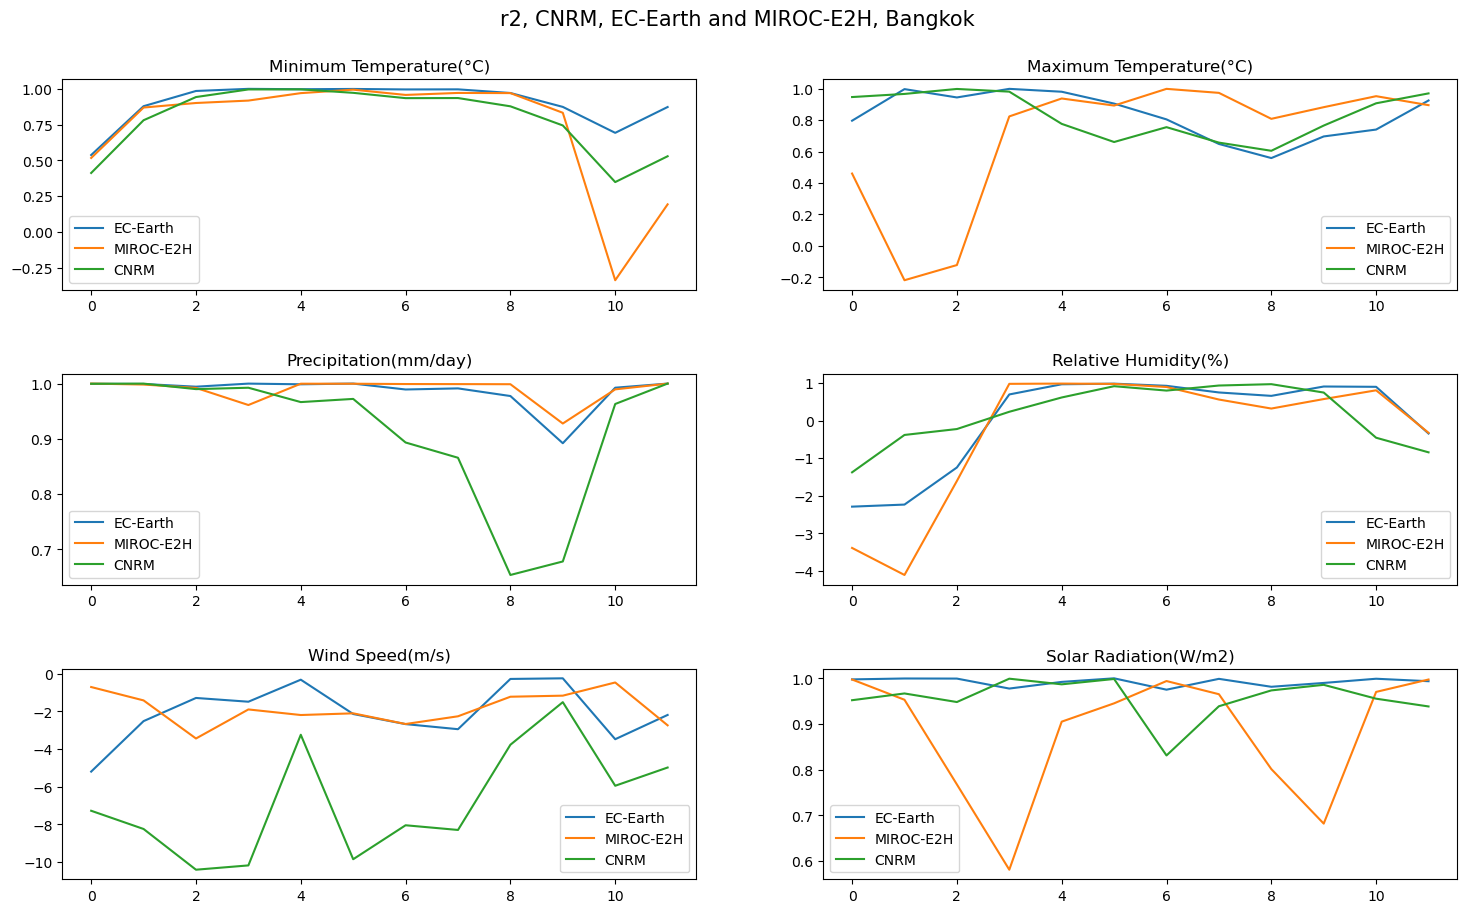

In [16]:
def r2(obs,model):
    obs_avg = obs.mean()
    out = 1 - (((obs - model)**2)  / (((obs - obs_avg)**2)).sum())
    return out

fig = plt.figure(figsize=(18,10))
fig.subplots_adjust(hspace=0.4, top=0.91)

fig.suptitle("r2, CNRM, EC-Earth and MIROC-E2H, Bangkok", fontsize=15)
plt.subplot(3,2,1); plt.title("Minimum Temperature(°C)")
d1 = r2(obs_tmin.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values, gcm_ec_earth_tmin.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values)
d2 = r2(obs_tmin.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values, gcm_miroc6_tmin.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values)
d3 = r2(obs_tmin.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values, hist_tmin.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values)
plt.plot(d1,label='EC-Earth')
plt.plot(d2,label='MIROC-E2H')
plt.plot(d3,label='CNRM')
plt.legend()

plt.subplot(3,2,2); plt.title("Maximum Temperature(°C)")
e1 = r2(obs_tmax.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values, gcm_ec_earth_tmax.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values)
e2 = r2(obs_tmax.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values, gcm_miroc6_tmax.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values)
e3 = r2(obs_tmax.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values, hist_tmax.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values)
plt.plot(e1,label='EC-Earth')
plt.plot(e2,label='MIROC-E2H')
plt.plot(e3,label='CNRM')
plt.legend()

plt.subplot(3,2,3); plt.title("Precipitation(mm/day)")
f1 = r2(obs_pr.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values, gcm_ec_earth_pr.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values)
f2 = r2(obs_pr.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values, gcm_miroc6_pr.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values)
f3 = r2(obs_pr.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values, hist_pr.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values)
plt.plot(f1,label='EC-Earth')
plt.plot(f2,label='MIROC-E2H')
plt.plot(f3,label='CNRM')
plt.legend()

plt.subplot(3,2,4); plt.title("Relative Humidity(%)")
i1 = r2(obs_rhm.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values, gcm_ec_earth_rhm.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values)
i2 = r2(obs_rhm.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values, gcm_miroc6_rhm.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values)
i3 = r2(obs_rhm.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values, hist_rhm.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values)
plt.plot(i1,label='EC-Earth')
plt.plot(i2,label='MIROC-E2H')
plt.plot(i3,label='CNRM')
plt.legend()

plt.subplot(3,2,5); plt.title("Wind Speed(m/s)")
j1 = r2(obs_ws.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values, gcm_ec_earth_ws.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values)
j2 = r2(obs_ws.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values, gcm_miroc6_ws.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values)
j3 = r2(obs_ws.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values, hist_ws.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values)
plt.plot(j1,label='EC-Earth')
plt.plot(j2,label='MIROC-E2H')
plt.plot(j3,label='CNRM')
plt.legend()

plt.subplot(3,2,6); plt.title("Solar Radiation(W/m2)")
k1 = r2(obs_srad.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values, gcm_ec_earth_srad.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values)
k2 = r2(obs_srad.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values, gcm_miroc6_srad.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values)
k3 = r2(obs_srad.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values, hist_srad.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values)
plt.plot(k1,label='EC-Earth')
plt.plot(k2,label='MIROC-E2H')
plt.plot(k3,label='CNRM')
plt.legend()

In [17]:
import numpy as np
def rmse(obs, gcm_miroc6):
    a = np.sqrt(((obs - gcm_miroc6) ** 2).mean())
    return a
rmse(obs_tmin, gcm_miroc6_tmin)
rmse(obs_tmax, gcm_miroc6_tmax)
rmse(obs_pr, gcm_miroc6_pr)
rmse(obs_rhm, gcm_miroc6_rhm)
rmse(obs_ws, gcm_miroc6_ws)
rmse(obs_srad, gcm_miroc6_srad)

<xarray.DataArray ()> Size: 8B
array(24.23895457)

In [18]:
import numpy as np
import pandas as pd

def rmse(obs, hist, variable_name):
    a = np.sqrt(((obs - hist) ** 2).mean())
    print(f"RMSE for {variable_name}: {a}")
    return a
# Example usage:
rmse(obs_tmin, hist_tmin, "tmin")
rmse(obs_tmax, hist_tmax, "tmax")
rmse(obs_pr, hist_pr, "pr")
rmse(obs_rhm, hist_rhm, "rhm")
rmse(obs_ws, hist_ws, "ws")
rmse(obs_srad, hist_srad, "srad")

RMSE for tmin: <xarray.DataArray ()> Size: 8B
array(2.56843495)
Coordinates:
    height   float64 8B 2.0
RMSE for tmax: <xarray.DataArray ()> Size: 8B
array(2.84286599)
Coordinates:
    height   float64 8B 2.0
RMSE for pr: <xarray.DataArray ()> Size: 8B
array(3.82587798)
RMSE for rhm: <xarray.DataArray ()> Size: 8B
array(0.11010407)
Coordinates:
    height   float64 8B 2.0
RMSE for ws: <xarray.DataArray ()> Size: 8B
array(1.44401565)
Coordinates:
    height   float64 8B 10.0
RMSE for srad: <xarray.DataArray ()> Size: 8B
array(20.95713045)


<xarray.DataArray ()> Size: 8B
array(20.95713045)

### RMSE - MIROC

In [19]:
import numpy as np
def rmse(obs, gcm_miroc6):
    a = np.sqrt(((obs - gcm_miroc6) ** 2).mean())
    return a
rmse(obs_tmin, gcm_miroc6_tmin)
rmse(obs_tmax, gcm_miroc6_tmax)
rmse(obs_pr, gcm_miroc6_pr)
rmse(obs_rhm, gcm_miroc6_rhm)
rmse(obs_ws, gcm_miroc6_ws)
rmse(obs_srad, gcm_miroc6_srad)

<xarray.DataArray ()> Size: 8B
array(24.23895457)

In [20]:
import numpy as np
import pandas as pd

def rmse(obs, gcm_miroc6, variable_name):
    a = np.sqrt(((obs - gcm_miroc6) ** 2).mean())
    print(f"RMSE for {variable_name}: {a}")
    return a
# Example usage:
rmse(obs_tmin, gcm_miroc6_tmin, "tmin")
rmse(obs_tmax, gcm_miroc6_tmax, "tmax")
rmse(obs_pr, gcm_miroc6_pr, "pr")
rmse(obs_rhm, gcm_miroc6_rhm, "rhm")
rmse(obs_ws, gcm_miroc6_ws, "ws")
rmse(obs_srad, gcm_miroc6_srad, "srad")


RMSE for tmin: <xarray.DataArray ()> Size: 8B
array(1.69903826)
Coordinates:
    height   float64 8B 2.0
RMSE for tmax: <xarray.DataArray ()> Size: 8B
array(2.18221554)
Coordinates:
    height   float64 8B 2.0
RMSE for pr: <xarray.DataArray ()> Size: 8B
array(3.65807951)
RMSE for rhm: <xarray.DataArray ()> Size: 8B
array(0.07808031)
Coordinates:
    height   float64 8B 2.0
RMSE for ws: <xarray.DataArray ()> Size: 8B
array(0.68939651)
Coordinates:
    height   float64 8B 10.0
RMSE for srad: <xarray.DataArray ()> Size: 8B
array(24.23895457)


<xarray.DataArray ()> Size: 8B
array(24.23895457)

### RMSE - EC-Earth

In [21]:
import numpy as np
def rmse(obs, model):
    a = np.sqrt(((obs - model) ** 2).mean())
    return a
rmse(obs_tmin, gcm_ec_earth_tmin)
rmse(obs_tmax, gcm_ec_earth_tmax)
rmse(obs_pr, gcm_ec_earth_pr)
rmse(obs_rhm, gcm_ec_earth_rhm)
rmse(obs_ws, gcm_ec_earth_ws)
rmse(obs_srad, gcm_ec_earth_srad)

<xarray.DataArray ()> Size: 8B
array(14.05589117)

#### Check data

In [22]:
obs_test = obs_tmin.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest')
model_test = gcm_ec_earth_tmin.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest')
print(np.shape(obs_test))
print(np.shape(model_test))


(12,)
(12,)


In [23]:
obs_test1 = obs_tmin.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest')
model_test1 = hist_tmin.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest')
print(np.shape(obs_test))
print(np.shape(model_test))

(12,)
(12,)


In [24]:
import numpy as np
import pandas as pd

def rmse(obs, gcm_ec_earth, variable_name):
    a = np.sqrt(((obs - gcm_ec_earth) ** 2).mean())
    print(f"RMSE for {variable_name}: {a}")
    return a
# Example usage:
rmse(obs_tmin, gcm_ec_earth_tmin, "tmin")
rmse(obs_tmax, gcm_ec_earth_tmax, "tmax")
rmse(obs_pr, gcm_ec_earth_pr, "pr")
rmse(obs_rhm, gcm_ec_earth_rhm, "rhm")
rmse(obs_ws, gcm_ec_earth_ws, "ws")
rmse(obs_srad, gcm_ec_earth_srad, "srad")


RMSE for tmin: <xarray.DataArray ()> Size: 8B
array(1.65781874)
Coordinates:
    height   float64 8B 2.0
RMSE for tmax: <xarray.DataArray ()> Size: 8B
array(2.50548866)
Coordinates:
    height   float64 8B 2.0
RMSE for pr: <xarray.DataArray ()> Size: 8B
array(2.6646203)
RMSE for rhm: <xarray.DataArray ()> Size: 8B
array(0.08794346)
Coordinates:
    height   float64 8B 2.0
RMSE for ws: <xarray.DataArray ()> Size: 8B
array(1.58108423)
Coordinates:
    height   float64 8B 10.0
RMSE for srad: <xarray.DataArray ()> Size: 8B
array(14.05589117)


<xarray.DataArray ()> Size: 8B
array(14.05589117)

### MAE

#### MAE - CNRM - Historical

In [25]:
import numpy as np
def mae (obs, model):
    b = np.abs((obs-model)).mean()
    return b
# Example
mae(obs_tmin, hist_tmin)
mae(obs_tmax, hist_tmax)
mae(obs_pr, hist_pr)
mae(obs_rhm, hist_rhm)
mae(obs_ws, hist_ws)
mae(obs_srad, hist_srad)

<xarray.DataArray ()> Size: 8B
array(16.8861915)

In [26]:
obs_tmin.sel

<bound method DataArray.sel of <xarray.DataArray 'tmin' (month: 12, lat: 360, lon: 192)> Size: 3MB
array([[[10.111815 ,  9.51727  ,  9.42818  , ...,  9.819089 ,
          9.823635 , 10.33818  ],
        [10.409088 ,  9.940907 ,  9.683634 , ..., 10.998178 ,
         11.2136345, 10.630904 ],
        [10.437271 , 10.083632 ,  9.454543 , ..., 12.025452 ,
         12.899997 , 11.929998 ],
        ...,
        [23.97     , 24.50636  , 24.654541 , ...,        nan,
                nan,        nan],
        [23.466362 , 23.951815 , 24.38     , ...,        nan,
                nan,        nan],
        [23.013634 , 23.593634 , 24.266363 , ...,        nan,
                nan,        nan]],

       [[11.340907 , 10.82727  , 10.72727  , ..., 10.481814 ,
         10.595452 , 11.092726 ],
        [11.251815 , 11.100906 , 10.967271 , ..., 11.593635 ,
         11.87727  , 11.289088 ],
        [11.361815 , 11.23727  , 10.68636  , ..., 12.586362 ,
         13.422724 , 12.549088 ],
...
        [23.50636 

#### MAE - MIROC6

In [27]:
import numpy as np
def mae (obs, model):
    b = np.abs((obs-model)).mean()
    return b
# Example
mae(obs_tmin, gcm_miroc6_tmin)
mae(obs_tmax, gcm_miroc6_tmax)
mae(obs_pr, gcm_miroc6_pr)
mae(obs_rhm, gcm_miroc6_rhm)
mae(obs_ws, gcm_miroc6_ws)
mae(obs_srad, gcm_miroc6_srad)


<xarray.DataArray ()> Size: 8B
array(19.27305113)

#### MAE - EC-Earth

In [28]:
## RMSE
def rmse(obs, model):
    n = np.shape(obs)
    output = np.sqrt(((model-obs)**2)/ n)

    return output


In [29]:
aa = rmse(obs_tmin.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values, gcm_ec_earth_tmin.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values)
bb = rmse(obs_tmin.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values, gcm_miroc6_tmin.sel(lat=BKK_lats[0],lon=BKK_lons[0],method='nearest').values)

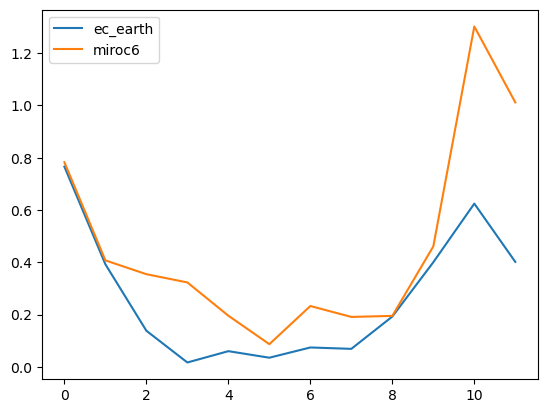

In [30]:
plt.plot(aa,label='ec_earth')
plt.plot(bb,label='miroc6')
plt.legend()

In [31]:
## R2
def r2(obs,model):
    obs_avg=obs.mean()
    out = 1 - ((obs-model)**2  / (obs-obs_avg)**2)
    return out


In [32]:
## MAE
def mae (obs, model):
    n=np.shape(obs)
    b = np.abs(obs-model)**2 / n

In [33]:
import numpy as np
def mae (obs, model):
    b = np.abs((obs-model)).mean()
    return b
# Example
mae(obs_tmin, gcm_ec_earth_tmin)
mae(obs_tmax, gcm_ec_earth_tmax)
mae(obs_pr, gcm_ec_earth_pr)
mae(obs_rhm, gcm_ec_earth_rhm)
mae(obs_ws, gcm_ec_earth_ws)
mae(obs_srad, gcm_ec_earth_srad)

<xarray.DataArray ()> Size: 8B
array(11.1060565)

### Observation ground (TMD 1984-2014)

## Phase 2 - Data prep

### CNRM - SSP245

In [34]:
# Load SSP245 Data
ssp245_tmin = xr.open_dataset(
    r'./gcm_cnrm6/ssp245/tasmin_Amon_CNRM-CM6-1-HR_ssp245_r1i1p1f2_gr_20150116-20950416_v20191202.nc', engine="netcdf4")['tasmin']
ssp245_tmax = xr.open_dataset(
    r'./gcm_cnrm6/ssp245/tasmax_Amon_CNRM-CM6-1-HR_ssp245_r1i1p1f2_gr_20150116-20950416_v20191202.nc', engine="netcdf4")['tasmax']
ssp245_pr = xr.open_dataset(
    r'./gcm_cnrm6/ssp245/pr_Amon_CNRM-CM6-1-HR_ssp245_r1i1p1f2_gr_20150116-20950416_v20191202.nc', engine="netcdf4")['pr']
ssp245_rhm = xr.open_dataset(
    r'./gcm_cnrm6/ssp245/hurs_Amon_CNRM-CM6-1-HR_ssp245_r1i1p1f2_gr_20150116-20950416_v20191202.nc', engine="netcdf4")['hurs']
ssp245_ws = xr.open_dataset(
    r'./gcm_cnrm6/ssp245/sfcWind_Amon_CNRM-CM6-1-HR_ssp245_r1i1p1f2_gr_20150116-20950416_v20191202.nc', engine="netcdf4")['sfcWind']
ssp245_srad = xr.open_dataset(
    r'./gcm_cnrm6/ssp245/rsds_Amon_CNRM-CM6-1-HR_ssp245_r1i1p1f2_gr_20150116-20950416_v20191202.nc', engine="netcdf4")['rsds']


### SSP245 - Near Future

In [35]:
# ============================================================
# Future scenario(SSP-RCP) SSP2-4.5 - - Medium Emission
ssp245near_tmin_in = ssp245_tmin.sel(time=slice('2015-01-01','2039-12-31')) 
ssp245near_tmax_in = ssp245_tmax.sel(time=slice('2015-01-01', '2039-12-31'))
ssp245near_pr_in = ssp245_pr.sel(time=slice('2015-01-01', '2039-12-31'))
ssp245near_rhm_in = ssp245_rhm.sel(time=slice('2015-01-01', '2039-12-31'))
ssp245near_ws_in = ssp245_ws.sel(time=slice('2015-01-01', '2039-12-31'))
ssp245near_srad_in = ssp245_srad.sel(time=slice('2015-01-01', '2039-12-31'))
# ============================================================
ssp245near_tmin_cropped = crop(ssp245near_tmin_in-273.15, TH_lons, TH_lats)
ssp245near_tmax_cropped = crop(ssp245near_tmax_in-273.15, TH_lons, TH_lats)
ssp245near_pr_cropped = crop(ssp245near_pr_in*86400, TH_lons, TH_lats)
ssp245near_rhm_cropped = crop(ssp245near_rhm_in/100, TH_lons, TH_lats)
ssp245near_ws_cropped = crop(ssp245near_ws_in, TH_lons, TH_lats)
ssp245near_srad_cropped = crop(ssp245near_srad_in, TH_lons, TH_lats)
# ============================================================
ssp245near_tmin = regrid(obs_tmin, ssp245near_tmin_cropped).groupby(
    'time.month').mean(dim='time')
ssp245near_tmax = regrid(obs_tmax, ssp245near_tmax_cropped).groupby(
    'time.month').mean(dim='time')
ssp245near_pr = regrid(obs_pr, ssp245near_pr_cropped).groupby(
    'time.month').mean(dim='time')
ssp245near_rhm = regrid(obs_rhm, ssp245near_rhm_cropped).groupby(
    'time.month').mean(dim='time')
ssp245near_ws = regrid(obs_ws, ssp245near_ws_cropped).groupby(
    'time.month').mean(dim='time')
ssp245near_srad = regrid(obs_srad, ssp245near_srad_cropped).groupby(
    'time.month').mean(dim='time')
# ============================================================
ssp245near_tmin.attrs["units"]="C"
ssp245near_tmax.attrs["units"]="C"
ssp245near_pr.attrs["units"]="mm/day"
ssp245near_rhm.attrs["units"]="%"
ssp245near_ws.attrs["units"]="m/s"
ssp245near_srad.attrs["units"]="W/m^2"

### RSME - - Near Future - CNRM

In [36]:
def rmse(obs, model):
    n = np.shape(obs)
    output = np.sqrt(((model-obs)**2)/ n)

    return output
(ssp245near_tmin, obs_tmin)
(ssp245near_tmax, obs_tmax)
(ssp245near_pr, obs_pr)
(ssp245near_rhm, obs_rhm)
(ssp245near_ws, obs_ws)
(ssp245near_srad, obs_srad)

(<xarray.DataArray 'rsds' (month: 12, lat: 360, lon: 192)> Size: 7MB
 array([[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],
 
        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],
 
        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
 ...
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],
 
        [[nan, nan, nan, ..., nan

#### MAE Near Future - CNRM

In [37]:
import numpy as np
def mae (obs, model):
    b = np.abs((obs-model)).mean()
    return b
# Example
mae(obs_tmin, ssp245near_tmin)
mae(obs_tmax, ssp245near_tmax)
mae(obs_pr, ssp245near_pr)
mae(obs_rhm, ssp245near_rhm)
mae(obs_ws, ssp245near_ws)
mae(obs_srad, ssp245near_srad)

<xarray.DataArray ()> Size: 8B
array(17.8802477)

In [38]:
# We import the bias_correction code from the /code/ folder -- not a python built-in function
import bias_correction
# ============================================
# Bias-correct the SSP245 - Near Future
# ============================================
bc_ssp245near_cnrm_tmin = ssp245near_tmin.copy()
for j in range(ssp245near_tmin.shape[2]):
    for i in range(ssp245near_tmin.shape[1]):
        bc_ssp245near_cnrm_tmin[:, i, j] = bias_correction.bias_correction(
            obs_tmin[:, i, j].values,
            hist_tmin[:, i, j].values,
            ssp245near_tmin[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp245near_cnrm_tmin.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp245near_cnrm_tmin.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp245near_cnrm_tmin.npy',
        bc_ssp245near_cnrm_tmin.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)

# ============================================
bc_ssp245near_cnrm_tmax = ssp245near_tmax.copy()
for j in range(ssp245near_tmax.shape[2]):
    for i in range(ssp245near_tmax.shape[1]):
        bc_ssp245near_cnrm_tmax[:, i, j] = bias_correction.bias_correction(
            obs_tmax[:, i, j].values,
            hist_tmax[:, i, j].values,
            ssp245near_tmax[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp245near_cnrm_tmax.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp245near_cnrm_tmax.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp245near_cnrm_tmax.npy',
        bc_ssp245near_cnrm_tmax.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# # ============================================
bc_ssp245near_cnrm_pr = ssp245near_pr.copy()
for j in range(ssp245near_pr.shape[2]):
    for i in range(ssp245near_pr.shape[1]):
        bc_ssp245near_cnrm_pr[:, i, j] = bias_correction.bias_correction(
            obs_pr[:, i, j].values,
            hist_pr[:, i, j].values,
            ssp245near_pr[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp245near_cnrm_pr.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp245near_cnrm_pr.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp245near_cnrm_pr.npy',
        bc_ssp245near_cnrm_pr.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# # ============================================
bc_ssp245near_cnrm_rhm = ssp245near_rhm.copy()
for j in range(ssp245near_rhm.shape[2]):
    for i in range(ssp245near_rhm.shape[1]):
        bc_ssp245near_cnrm_rhm[:, i, j] = bias_correction.bias_correction(
            obs_rhm[:, i, j].values,
            hist_rhm[:, i, j].values,
            ssp245near_rhm[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp245near_cnrm_rhm.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp245near_cnrm_rhm.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp245near_cnrm_rhm.npy',
        bc_ssp245near_cnrm_rhm.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# # ============================================
bc_ssp245near_cnrm_ws = ssp245near_ws.copy()
for j in range(ssp245near_ws.shape[2]):
    for i in range(ssp245near_ws.shape[1]):
        bc_ssp245near_cnrm_ws[:, i, j] = bias_correction.bias_correction(
            obs_ws[:, i, j].values,
            hist_ws[:, i, j].values,
            ssp245near_ws[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp245near_cnrm_ws.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp245near_cnrm_ws.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp245near_cnrm_ws.npy',
        bc_ssp245near_cnrm_ws.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# # ============================================
bc_ssp245near_cnrm_srad = ssp245near_srad.copy()
for j in range(ssp245near_srad.shape[2]):
    for i in range(ssp245near_srad.shape[1]):
        bc_ssp245near_cnrm_srad[:, i, j] = bias_correction.bias_correction(
            obs_srad[:, i, j].values,
            hist_srad[:, i, j].values,
            ssp245near_srad[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp245near_cnrm_srad.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp245near_cnrm_srad.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp245near_cnrm_srad.npy',
        bc_ssp245near_cnrm_srad.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# ============================================

### RSME - Bias Correction - Near Future - CNRM

In [39]:
import numpy as np
def rmse(obs, bc_ssp245near_cnrm):
    a = np.sqrt(((obs - bc_ssp245near_cnrm) ** 2).mean())
    return a
rmse(obs_tmin, bc_ssp245near_cnrm_tmin)
rmse(obs_tmax, bc_ssp245near_cnrm_tmax)
rmse(obs_pr, bc_ssp245near_cnrm_pr)
rmse(obs_rhm, bc_ssp245near_cnrm_rhm)
rmse(obs_ws, bc_ssp245near_cnrm_ws)
rmse(obs_srad, bc_ssp245near_cnrm_srad)

<xarray.DataArray ()> Size: 8B
array(18.92850023)

#### MAE Bias Correction - Near Future - CNRM

In [40]:
import numpy as np
def mae (obs, model):
    b = np.abs((obs-model)).mean()
    return b
# Example
mae(obs_tmin, bc_ssp245near_cnrm_tmin)
mae(obs_tmax, bc_ssp245near_cnrm_tmax)
mae(obs_pr, bc_ssp245near_cnrm_pr)
mae(obs_rhm, bc_ssp245near_cnrm_rhm)
mae(obs_ws, bc_ssp245near_cnrm_ws)
mae(obs_srad, bc_ssp245near_cnrm_srad)

<xarray.DataArray ()> Size: 8B
array(15.15268689)

### SSP245 - Mid Future

In [41]:
# ============================================================
# Future scenario(SSP-RCP) SSP2-4.5 - - Medium Emission
ssp245mid_tmin_in = ssp245_tmin.sel(time=slice('2040-01-01', '2069-12-31'))
ssp245mid_tmax_in = ssp245_tmax.sel(time=slice('2040-01-01', '2069-12-31'))
ssp245mid_pr_in = ssp245_pr.sel(time=slice('2040-01-01', '2069-12-31'))
ssp245mid_rhm_in = ssp245_rhm.sel(time=slice('2040-01-01', '2069-12-31'))
ssp245mid_ws_in = ssp245_ws.sel(time=slice('2040-01-01', '2069-12-31'))
ssp245mid_srad_in = ssp245_srad.sel(time=slice('2040-01-01', '2069-12-31'))
# ============================================================
ssp245mid_tmin_cropped = crop(ssp245mid_tmin_in-273.15, TH_lons, TH_lats)
ssp245mid_tmax_cropped = crop(ssp245mid_tmax_in-273.15, TH_lons, TH_lats)
ssp245mid_pr_cropped = crop(ssp245mid_pr_in*86400, TH_lons, TH_lats)
ssp245mid_rhm_cropped = crop(ssp245mid_rhm_in/100, TH_lons, TH_lats)
ssp245mid_ws_cropped = crop(ssp245mid_ws_in, TH_lons, TH_lats)
ssp245mid_srad_cropped = crop(ssp245mid_srad_in, TH_lons, TH_lats)
# ============================================================
ssp245mid_tmin = regrid(obs_tmin, ssp245mid_tmin_cropped).groupby(
    'time.month').mean(dim='time')
ssp245mid_tmax = regrid(obs_tmax, ssp245mid_tmax_cropped).groupby(
    'time.month').mean(dim='time')
ssp245mid_pr = regrid(obs_pr, ssp245mid_pr_cropped).groupby(
    'time.month').mean(dim='time')
ssp245mid_rhm = regrid(obs_rhm, ssp245mid_rhm_cropped).groupby(
    'time.month').mean(dim='time')
ssp245mid_ws = regrid(obs_ws, ssp245mid_ws_cropped).groupby(
    'time.month').mean(dim='time')
ssp245mid_srad = regrid(obs_srad, ssp245mid_srad_cropped).groupby(
    'time.month').mean(dim='time')
# ============================================================

### RSME - Mid Future - CNRM

In [42]:
import numpy as np
def rmse(obs, ssp245mid):
    a = np.sqrt(((obs - ssp245mid) ** 2).mean())
    return a
rmse(obs_tmin, ssp245mid_tmin)
rmse(obs_tmax, ssp245mid_tmax)
rmse(obs_pr, ssp245mid_pr)
rmse(obs_rhm, ssp245mid_rhm)
rmse(obs_ws, ssp245mid_ws)
rmse(obs_srad, ssp245mid_srad)

<xarray.DataArray ()> Size: 8B
array(21.48427434)

### MAE - Mid Future - CNRM

In [43]:
import numpy as np
def mae (obs, model):
    b = np.abs((obs-model)).mean()
    return b
# Example
mae(obs_tmin, ssp245mid_tmin)
mae(obs_tmax, ssp245mid_tmax)
mae(obs_pr, ssp245mid_pr)
mae(obs_rhm, ssp245mid_rhm)
mae(obs_ws, ssp245mid_ws)
mae(obs_srad, ssp245mid_srad)

<xarray.DataArray ()> Size: 8B
array(17.27759691)

In [44]:
# We import the bias_correction code from the /code/ folder -- not a python built-in function
import bias_correction
# ============================================
# Bias-correct the SSP245 - mid Future
# ============================================
bc_ssp245mid_cnrm_tmin = ssp245mid_tmin.copy()
for j in range(ssp245mid_tmin.shape[2]):
    for i in range(ssp245mid_tmin.shape[1]):
        bc_ssp245mid_cnrm_tmin[:, i, j] = bias_correction.bias_correction(
            obs_tmin[:, i, j].values,
            hist_tmin[:, i, j].values,
            ssp245mid_tmin[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp245mid_cnrm_tmin.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp245mid_cnrm_tmin.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp245mid_cnrm_tmin.npy',
        bc_ssp245mid_cnrm_tmin.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)

# ============================================
bc_ssp245mid_cnrm_tmax = ssp245mid_tmax.copy()
for j in range(ssp245mid_tmax.shape[2]):
    for i in range(ssp245mid_tmax.shape[1]):
        bc_ssp245mid_cnrm_tmax[:, i, j] = bias_correction.bias_correction(
            obs_tmax[:, i, j].values,
            hist_tmax[:, i, j].values,
            ssp245mid_tmax[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp245mid_cnrm_tmax.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp245mid_cnrm_tmax.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp245mid_cnrm_tmax.npy',
        bc_ssp245mid_cnrm_tmax.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# # ============================================
bc_ssp245mid_cnrm_pr = ssp245mid_pr.copy()
for j in range(ssp245mid_pr.shape[2]):
    for i in range(ssp245mid_pr.shape[1]):
        bc_ssp245mid_cnrm_pr[:, i, j] = bias_correction.bias_correction(
            obs_pr[:, i, j].values,
            hist_pr[:, i, j].values,
            ssp245mid_pr[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp245mid_cnrm_pr.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp245mid_cnrm_pr.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp245mid_cnrm_pr.npy',
        bc_ssp245mid_cnrm_pr.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# # ============================================
bc_ssp245mid_cnrm_rhm = ssp245mid_rhm.copy()
for j in range(ssp245mid_rhm.shape[2]):
    for i in range(ssp245mid_rhm.shape[1]):
        bc_ssp245mid_cnrm_rhm[:, i, j] = bias_correction.bias_correction(
            obs_rhm[:, i, j].values,
            hist_rhm[:, i, j].values,
            ssp245mid_rhm[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp245mid_cnrm_rhm.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp245mid_cnrm_rhm.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp245nea_cnrm_rhm.npy',
        bc_ssp245mid_cnrm_rhm.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# # ============================================
bc_ssp245mid_cnrm_ws = ssp245mid_ws.copy()
for j in range(ssp245mid_ws.shape[2]):
    for i in range(ssp245mid_ws.shape[1]):
        bc_ssp245mid_cnrm_ws[:, i, j] = bias_correction.bias_correction(
            obs_ws[:, i, j].values,
            hist_ws[:, i, j].values,
            ssp245mid_ws[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp245mid_cnrm_ws.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp245mid_cnrm_ws.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp245mid_cnrm_ws.npy',
        bc_ssp245mid_cnrm_ws.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# # ============================================
bc_ssp245mid_cnrm_srad = ssp245mid_srad.copy()
for j in range(ssp245mid_srad.shape[2]):
    for i in range(ssp245mid_srad.shape[1]):
        bc_ssp245mid_cnrm_srad[:, i, j] = bias_correction.bias_correction(
            obs_srad[:, i, j].values,
            hist_srad[:, i, j].values,
            ssp245mid_srad[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp245mid_cnrm_srad.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp245mid_cnrm_srad.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp245mid_cnrm_srad.npy',
        bc_ssp245mid_cnrm_srad.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)

### RSME - Bias Correction - Mid Future - CNRM

In [45]:
import numpy as np
def rmse(obs, bc_ssp245mid_cnrm):
    a = np.sqrt(((obs - bc_ssp245mid_cnrm) ** 2).mean())
    return a
rmse(obs_tmin, bc_ssp245mid_cnrm_tmin)
rmse(obs_tmax, bc_ssp245mid_cnrm_tmax)
rmse(obs_pr, bc_ssp245mid_cnrm_pr)
rmse(obs_rhm, bc_ssp245mid_cnrm_rhm)
rmse(obs_ws, bc_ssp245mid_cnrm_ws)
rmse(obs_srad, bc_ssp245mid_cnrm_srad)

<xarray.DataArray ()> Size: 8B
array(18.1642034)

#### MAE - Bias Correction - Mid Future - CNRM

In [46]:
import numpy as np
def mae (obs, model):
    b = np.abs((obs-model)).mean()
    return b
# Example
mae(obs_tmin, bc_ssp245mid_cnrm_tmin)
mae(obs_tmax, bc_ssp245mid_cnrm_tmax)
mae(obs_pr, bc_ssp245mid_cnrm_pr)
mae(obs_rhm, bc_ssp245mid_cnrm_rhm)
mae(obs_ws, bc_ssp245mid_cnrm_ws)
mae(obs_srad, bc_ssp245mid_cnrm_srad)

<xarray.DataArray ()> Size: 8B
array(13.97755952)

### SSP245 - Far Future

In [47]:
# ============================================================
# Future scenario(SSP-RCP) SSP2-4.5 - - Medium Emission
ssp245far_tmin_in = ssp245_tmin.sel(time=slice('2070-01-01','2095-12-31')) 
ssp245far_tmax_in = ssp245_tmax.sel(time=slice('2070-01-01', '2095-12-31'))
ssp245far_pr_in = ssp245_pr.sel(time=slice('2070-01-01', '2095-12-31'))
ssp245far_rhm_in = ssp245_rhm.sel(time=slice('2070-01-01', '2095-12-31'))
ssp245far_ws_in = ssp245_ws.sel(time=slice('2070-01-01', '2095-12-31'))
ssp245far_srad_in = ssp245_srad.sel(time=slice('2070-01-01', '2095-12-31'))
# ============================================================
ssp245far_tmin_cropped = crop(ssp245far_tmin_in-273.70, TH_lons, TH_lats)
ssp245far_tmax_cropped = crop(ssp245far_tmax_in-273.70, TH_lons, TH_lats)
ssp245far_pr_cropped = crop(ssp245far_pr_in*86400, TH_lons, TH_lats)
ssp245far_rhm_cropped = crop(ssp245far_rhm_in/100, TH_lons, TH_lats)
ssp245far_ws_cropped = crop(ssp245far_ws_in, TH_lons, TH_lats)
ssp245far_srad_cropped = crop(ssp245far_srad_in, TH_lons, TH_lats)
# ============================================================
ssp245far_tmin = regrid(obs_tmin, ssp245far_tmin_cropped).groupby(
    'time.month').mean(dim='time')
ssp245far_tmax = regrid(obs_tmax, ssp245far_tmax_cropped).groupby(
    'time.month').mean(dim='time')
ssp245far_pr = regrid(obs_pr, ssp245far_pr_cropped).groupby(
    'time.month').mean(dim='time')
ssp245far_rhm = regrid(obs_rhm, ssp245far_rhm_cropped).groupby(
    'time.month').mean(dim='time')
ssp245far_ws = regrid(obs_ws, ssp245far_ws_cropped).groupby(
    'time.month').mean(dim='time')
ssp245far_srad = regrid(obs_srad, ssp245far_srad_cropped).groupby(
    'time.month').mean(dim='time')
# ============================================================
ssp245far_tmin.attrs["units"]="C"
ssp245far_tmax.attrs["units"]="C"
ssp245far_pr.attrs["units"]="mm/day"
ssp245far_rhm.attrs["units"]="%"
ssp245far_ws.attrs["units"]="m/s"
ssp245far_srad.attrs["units"]="W/m^2"

### RSME - - Far Future - CNRM

In [48]:
import numpy as np
def rmse(obs, ssp245far):
    a = np.sqrt(((obs - ssp245far) ** 2).mean())
    return a
rmse(obs_tmin, ssp245far_tmin)
rmse(obs_tmax, ssp245far_tmax)
rmse(obs_pr, ssp245far_pr)
rmse(obs_rhm, ssp245far_rhm)
rmse(obs_ws, ssp245far_ws)
rmse(obs_srad, ssp245far_srad)

<xarray.DataArray ()> Size: 8B
array(21.71956961)

### MAE - - Far Future - CNRM

In [49]:
import numpy as np
def mae (obs, model):
    b = np.abs((obs-model)).mean()
    return b
# Example
mae(obs_tmin, ssp245far_tmin)
mae(obs_tmax, ssp245far_tmax)
mae(obs_pr, ssp245far_pr)
mae(obs_rhm, ssp245far_rhm)
mae(obs_ws, ssp245far_ws)
mae(obs_srad, ssp245far_srad)

<xarray.DataArray ()> Size: 8B
array(17.45704606)

In [50]:
# We import the bias_correction code from the /code/ folder -- not a python built-in function
import bias_correction
# ============================================
# Bias-correct the SSP245 - far Future
# ============================================
bc_ssp245far_cnrm_tmin = ssp245far_tmin.copy()
for j in range(ssp245far_tmin.shape[2]):
    for i in range(ssp245far_tmin.shape[1]):
        bc_ssp245far_cnrm_tmin[:, i, j] = bias_correction.bias_correction(
            obs_tmin[:, i, j].values,
            hist_tmin[:, i, j].values,
            ssp245far_tmin[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp245far_cnrm_tmin.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp245far_cnrm_tmin.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp245far_cnrm_tmin.npy',
        bc_ssp245far_cnrm_tmin.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)

# ============================================
bc_ssp245far_cnrm_tmax = ssp245far_tmax.copy()
for j in range(ssp245far_tmax.shape[2]):
    for i in range(ssp245far_tmax.shape[1]):
        bc_ssp245far_cnrm_tmax[:, i, j] = bias_correction.bias_correction(
            obs_tmax[:, i, j].values,
            hist_tmax[:, i, j].values,
            ssp245far_tmax[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp245far_cnrm_tmax.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp245far_cnrm_tmax.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp245far_cnrm_tmax.npy',
        bc_ssp245far_cnrm_tmax.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# # ============================================
bc_ssp245far_cnrm_pr = ssp245far_pr.copy()
for j in range(ssp245far_pr.shape[2]):
    for i in range(ssp245far_pr.shape[1]):
        bc_ssp245far_cnrm_pr[:, i, j] = bias_correction.bias_correction(
            obs_pr[:, i, j].values,
            hist_pr[:, i, j].values,
            ssp245far_pr[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp245far_cnrm_pr.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp245far_cnrm_pr.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp245far_cnrm_pr.npy',
        bc_ssp245far_cnrm_pr.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# # ============================================
bc_ssp245far_cnrm_rhm = ssp245far_rhm.copy()
for j in range(ssp245far_rhm.shape[2]):
    for i in range(ssp245far_rhm.shape[1]):
        bc_ssp245far_cnrm_rhm[:, i, j] = bias_correction.bias_correction(
            obs_rhm[:, i, j].values,
            hist_rhm[:, i, j].values,
            ssp245far_rhm[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp245far_cnrm_rhm.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp245far_cnrm_rhm.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp245nea_cnrm_rhm.npy',
        bc_ssp245far_cnrm_rhm.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# # ============================================
bc_ssp245far_cnrm_ws = ssp245far_ws.copy()
for j in range(ssp245far_ws.shape[2]):
    for i in range(ssp245far_ws.shape[1]):
        bc_ssp245far_cnrm_ws[:, i, j] = bias_correction.bias_correction(
            obs_ws[:, i, j].values,
            hist_ws[:, i, j].values,
            ssp245far_ws[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp245far_cnrm_ws.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp245far_cnrm_ws.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp245far_cnrm_ws.npy',
        bc_ssp245far_cnrm_ws.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# # ============================================
bc_ssp245far_cnrm_srad = ssp245far_srad.copy()
for j in range(ssp245far_srad.shape[2]):
    for i in range(ssp245far_srad.shape[1]):
        bc_ssp245far_cnrm_srad[:, i, j] = bias_correction.bias_correction(
            obs_srad[:, i, j].values,
            hist_srad[:, i, j].values,
            ssp245far_srad[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp245far_cnrm_srad.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp245far_cnrm_srad.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp245far_cnrm_srad.npy',
        bc_ssp245far_cnrm_srad.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)

### RSME - Bias Correction - Far Future - CNRM

In [51]:
import numpy as np
def rmse(obs, bc_ssp245far_cnrm):
    a = np.sqrt(((obs - bc_ssp245far_cnrm) ** 2).mean())
    return a
rmse(obs_tmin, bc_ssp245far_cnrm_tmin)
rmse(obs_tmax, bc_ssp245far_cnrm_tmax)
rmse(obs_pr, bc_ssp245far_cnrm_pr)
rmse(obs_rhm, bc_ssp245far_cnrm_rhm)
rmse(obs_ws, bc_ssp245far_cnrm_ws)
rmse(obs_srad, bc_ssp245far_cnrm_srad)

<xarray.DataArray ()> Size: 8B
array(18.09438033)

### MAE - Bias Correction - Far Future - CNRM

In [52]:
import numpy as np
def mae (obs, model):
    b = np.abs((obs-model)).mean()
    return b
# Example
mae(obs_tmin, bc_ssp245far_cnrm_tmin)
mae(obs_tmax, bc_ssp245far_cnrm_tmax)
mae(obs_pr, bc_ssp245far_cnrm_pr)
mae(obs_rhm, bc_ssp245far_cnrm_rhm)
mae(obs_ws, bc_ssp245far_cnrm_ws)
mae(obs_srad, bc_ssp245far_cnrm_srad)

<xarray.DataArray ()> Size: 8B
array(13.83046652)

### CNRM - SSP585 - Prep

#### SSP585 

In [53]:
# Load SSP585 Data
ssp585_tmin = xr.open_dataset(
    r'./gcm_cnrm6/ssp585/tasmin_Amon_CNRM-CM6-1-HR_ssp585_r1i1p1f2_gr_20150116-20950416_v20191202.nc', engine="netcdf4")['tasmin']
ssp585_tmax = xr.open_dataset(
    r'./gcm_cnrm6/ssp585/tasmax_Amon_CNRM-CM6-1-HR_ssp585_r1i1p1f2_gr_20150116-20950416_v20191202.nc', engine="netcdf4")['tasmax']
ssp585_pr = xr.open_dataset(
    r'./gcm_cnrm6/ssp585/pr_Amon_CNRM-CM6-1-HR_ssp585_r1i1p1f2_gr_20150116-20950416_v20191202.nc', engine="netcdf4")['pr']
ssp585_rhm = xr.open_dataset(
    r'./gcm_cnrm6/ssp585/hurs_Amon_CNRM-CM6-1-HR_ssp585_r1i1p1f2_gr_20150116-20950416_v20191202.nc', engine="netcdf4")['hurs']
ssp585_ws = xr.open_dataset(
    r'./gcm_cnrm6/ssp585/sfcWind_Amon_CNRM-CM6-1-HR_ssp585_r1i1p1f2_gr_20150116-20950416_v20191202.nc', engine="netcdf4")['sfcWind']
ssp585_srad = xr.open_dataset(
    r'./gcm_cnrm6/ssp585/rsds_Amon_CNRM-CM6-1-HR_ssp585_r1i1p1f2_gr_20150116-20950416_v20191202.nc', engine="netcdf4")['rsds']


### SSP585 - Near Future

In [54]:
# ============================================================
# Future scenario(SSP-RCP) SSP2-4.5 - - Medium Emission
ssp585near_tmin_in = ssp585_tmin.sel(time=slice('2015-01-01','2039-12-31')) 
ssp585near_tmax_in = ssp585_tmax.sel(time=slice('2015-01-01', '2039-12-31'))
ssp585near_pr_in = ssp585_pr.sel(time=slice('2015-01-01', '2039-12-31'))
ssp585near_rhm_in = ssp585_rhm.sel(time=slice('2015-01-01', '2039-12-31'))
ssp585near_ws_in = ssp585_ws.sel(time=slice('2015-01-01', '2039-12-31'))
ssp585near_srad_in = ssp585_srad.sel(time=slice('2015-01-01', '2039-12-31'))
# ============================================================
ssp585near_tmin_cropped = crop(ssp585near_tmin_in-273.15, TH_lons, TH_lats)
ssp585near_tmax_cropped = crop(ssp585near_tmax_in-273.15, TH_lons, TH_lats)
ssp585near_pr_cropped = crop(ssp585near_pr_in*86400, TH_lons, TH_lats)
ssp585near_rhm_cropped = crop(ssp585near_rhm_in/100, TH_lons, TH_lats)
ssp585near_ws_cropped = crop(ssp585near_ws_in, TH_lons, TH_lats)
ssp585near_srad_cropped = crop(ssp585near_srad_in, TH_lons, TH_lats)
# ============================================================
ssp585near_tmin = regrid(obs_tmin, ssp585near_tmin_cropped).groupby(
    'time.month').mean(dim='time')
ssp585near_tmax = regrid(obs_tmax, ssp585near_tmax_cropped).groupby(
    'time.month').mean(dim='time')
ssp585near_pr = regrid(obs_pr, ssp585near_pr_cropped).groupby(
    'time.month').mean(dim='time')
ssp585near_rhm = regrid(obs_rhm, ssp585near_rhm_cropped).groupby(
    'time.month').mean(dim='time')
ssp585near_ws = regrid(obs_ws, ssp585near_ws_cropped).groupby(
    'time.month').mean(dim='time')
ssp585near_srad = regrid(obs_srad, ssp585near_srad_cropped).groupby(
    'time.month').mean(dim='time')
# ============================================================
ssp585near_tmin.attrs["units"]="C"
ssp585near_tmax.attrs["units"]="C"
ssp585near_pr.attrs["units"]="mm/day"
ssp585near_rhm.attrs["units"]="%"
ssp585near_ws.attrs["units"]="m/s"
ssp585near_srad.attrs["units"]="W/m^2"

### RSME  - Near Future - CNRM SSP558

In [55]:
import numpy as np
def rmse(obs, ssp585near):
    a = np.sqrt(((obs - ssp585near) ** 2).mean())
    return a
rmse(obs_tmin, ssp585near_tmin)
rmse(obs_tmax, ssp585near_tmax)
rmse(obs_pr, ssp585near_pr)
rmse(obs_rhm, ssp585near_rhm)
rmse(obs_ws, ssp585near_ws)
rmse(obs_srad, ssp585near_srad)

<xarray.DataArray ()> Size: 8B
array(22.49026536)

### MAE  - Near Future - CNRM SSP585

In [56]:
import numpy as np
def mae (obs, model):
    b = np.abs((obs-model)).mean()
    return b
# Example
mae(obs_tmin, ssp585near_tmin)
mae(obs_tmax, ssp585near_tmax)
mae(obs_pr, ssp585near_pr)
mae(obs_rhm, ssp585near_rhm)
mae(obs_ws, ssp585near_ws)
mae(obs_srad, ssp585near_srad)

<xarray.DataArray ()> Size: 8B
array(18.30292968)

In [57]:
# We import the bias_correction code from the /code/ folder -- not a python built-in function
import bias_correction
# ============================================
# Bias-correct the SSP585 - Near Future
# ============================================
bc_ssp585near_cnrm_tmin = ssp585near_tmin.copy()
for j in range(ssp585near_tmin.shape[2]):
    for i in range(ssp585near_tmin.shape[1]):
        bc_ssp585near_cnrm_tmin[:, i, j] = bias_correction.bias_correction(
            obs_tmin[:, i, j].values,
            hist_tmin[:, i, j].values,
            ssp585near_tmin[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp585near_cnrm_tmin.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp585near_cnrm_tmin.nc', mode='w')
np.save(r'./processed_data1/eqm_ssp585near_cnrm_tmin.npy',
        bc_ssp585near_cnrm_tmin.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)

# ============================================
bc_ssp585near_cnrm_tmax = ssp585near_tmax.copy()
for j in range(ssp585near_tmax.shape[2]):
    for i in range(ssp585near_tmax.shape[1]):
        bc_ssp585near_cnrm_tmax[:, i, j] = bias_correction.bias_correction(
            obs_tmax[:, i, j].values,
            hist_tmax[:, i, j].values,
            ssp585near_tmax[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp585near_cnrm_tmax.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp585near_cnrm_tmax.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp585near_cnrm_tmax.npy',
        bc_ssp585near_cnrm_tmax.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# # ============================================
bc_ssp585near_cnrm_pr = ssp585near_pr.copy()
for j in range(ssp585near_pr.shape[2]):
    for i in range(ssp585near_pr.shape[1]):
        bc_ssp585near_cnrm_pr[:, i, j] = bias_correction.bias_correction(
            obs_pr[:, i, j].values,
            hist_pr[:, i, j].values,
            ssp585near_pr[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp585near_cnrm_pr.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp585near_cnrm_pr.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp585near_cnrm_pr.npy',
        bc_ssp585near_cnrm_pr.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# # ============================================
bc_ssp585near_cnrm_rhm = ssp585near_rhm.copy()
for j in range(ssp585near_rhm.shape[2]):
    for i in range(ssp585near_rhm.shape[1]):
        bc_ssp585near_cnrm_rhm[:, i, j] = bias_correction.bias_correction(
            obs_rhm[:, i, j].values,
            hist_rhm[:, i, j].values,
            ssp585near_rhm[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp585near_cnrm_rhm.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp585near_cnrm_rhm.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp585nea_cnrm_rhm.npy',
        bc_ssp585near_cnrm_rhm.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# # ============================================
bc_ssp585near_cnrm_ws = ssp585near_ws.copy()
for j in range(ssp585near_ws.shape[2]):
    for i in range(ssp585near_ws.shape[1]):
        bc_ssp585near_cnrm_ws[:, i, j] = bias_correction.bias_correction(
            obs_ws[:, i, j].values,
            hist_ws[:, i, j].values,
            ssp585near_ws[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp585near_cnrm_ws.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp585near_cnrm_ws.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp585near_cnrm_ws.npy',
        bc_ssp585near_cnrm_ws.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# # ============================================
bc_ssp585near_cnrm_srad = ssp585near_srad.copy()
for j in range(ssp585near_srad.shape[2]):
    for i in range(ssp585near_srad.shape[1]):
        bc_ssp585near_cnrm_srad[:, i, j] = bias_correction.bias_correction(
            obs_srad[:, i, j].values,
            hist_srad[:, i, j].values,
            ssp585near_srad[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp585near_cnrm_srad.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp585near_cnrm_srad.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp585near_cnrm_srad.npy',
        bc_ssp585near_cnrm_srad.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# ============================================

### RSME  - Bias Correction Near Future - CNRM SSP558

In [58]:
import numpy as np
def rmse(obs, bc_ssp585near_cnrm):
    a = np.sqrt(((obs - bc_ssp585near_cnrm) ** 2).mean())
    return a
rmse(obs_tmin, bc_ssp585near_cnrm_tmin)
rmse(obs_tmax, bc_ssp585near_cnrm_tmax)
rmse(obs_pr, bc_ssp585near_cnrm_pr)
rmse(obs_rhm, bc_ssp585near_cnrm_rhm)
rmse(obs_ws, bc_ssp585near_cnrm_ws)
rmse(obs_srad, bc_ssp585near_cnrm_srad)

<xarray.DataArray ()> Size: 8B
array(19.71176397)

### MAE  - Bias Correction Near Future - CNRM SSP558

In [59]:
import numpy as np
def mae (obs, model):
    b = np.abs((obs-model)).mean()
    return b
# Example
mae(obs_tmin, bc_ssp585near_cnrm_tmin)
mae(obs_tmax, bc_ssp585near_cnrm_tmax)
mae(obs_pr, bc_ssp585near_cnrm_pr)
mae(obs_rhm, bc_ssp585near_cnrm_rhm)
mae(obs_ws, bc_ssp585near_cnrm_ws)
mae(obs_srad, bc_ssp585near_cnrm_srad)

<xarray.DataArray ()> Size: 8B
array(15.80438346)

### SSP585 - Mid Future

In [60]:
# ============================================================
# Future scenario(SSP-RCP) SSP2-4.5 - - Medium Emission
ssp585mid_tmin_in = ssp585_tmin.sel(time=slice('2040-01-01','2069-12-31')) 
ssp585mid_tmax_in = ssp585_tmax.sel(time=slice('2040-01-01', '2069-12-31'))
ssp585mid_pr_in = ssp585_pr.sel(time=slice('2040-01-01', '2069-12-31'))
ssp585mid_rhm_in = ssp585_rhm.sel(time=slice('2040-01-01', '2069-12-31'))
ssp585mid_ws_in = ssp585_ws.sel(time=slice('2040-01-01', '2069-12-31'))
ssp585mid_srad_in = ssp585_srad.sel(time=slice('2040-01-01', '2069-12-31'))
# ============================================================
ssp585mid_tmin_cropped = crop(ssp585mid_tmin_in-273.40, TH_lons, TH_lats)
ssp585mid_tmax_cropped = crop(ssp585mid_tmax_in-273.40, TH_lons, TH_lats)
ssp585mid_pr_cropped = crop(ssp585mid_pr_in*86400, TH_lons, TH_lats)
ssp585mid_rhm_cropped = crop(ssp585mid_rhm_in/100, TH_lons, TH_lats)
ssp585mid_ws_cropped = crop(ssp585mid_ws_in, TH_lons, TH_lats)
ssp585mid_srad_cropped = crop(ssp585mid_srad_in, TH_lons, TH_lats)
# ============================================================
ssp585mid_tmin = regrid(obs_tmin, ssp585mid_tmin_cropped).groupby(
    'time.month').mean(dim='time')
ssp585mid_tmax = regrid(obs_tmax, ssp585mid_tmax_cropped).groupby(
    'time.month').mean(dim='time')
ssp585mid_pr = regrid(obs_pr, ssp585mid_pr_cropped).groupby(
    'time.month').mean(dim='time')
ssp585mid_rhm = regrid(obs_rhm, ssp585mid_rhm_cropped).groupby(
    'time.month').mean(dim='time')
ssp585mid_ws = regrid(obs_ws, ssp585mid_ws_cropped).groupby(
    'time.month').mean(dim='time')
ssp585mid_srad = regrid(obs_srad, ssp585mid_srad_cropped).groupby(
    'time.month').mean(dim='time')
# ============================================================
ssp585mid_tmin.attrs["units"]="C"
ssp585mid_tmax.attrs["units"]="C"
ssp585mid_pr.attrs["units"]="mm/day"
ssp585mid_rhm.attrs["units"]="%"
ssp585mid_ws.attrs["units"]="m/s"
ssp585mid_srad.attrs["units"]="W/m^2"

### RSME  - mid Future - CNRM SSP558

In [61]:
import numpy as np
def rmse(obs, ssp585mid):
    a = np.sqrt(((obs - ssp585mid) ** 2).mean())
    return a
rmse(obs_tmin, ssp585mid_tmin)
rmse(obs_tmax, ssp585mid_tmax)
rmse(obs_pr, ssp585mid_pr)
rmse(obs_rhm, ssp585mid_rhm)
rmse(obs_ws, ssp585mid_ws)
rmse(obs_srad, ssp585mid_srad)

<xarray.DataArray ()> Size: 8B
array(21.85511426)

### MAE  - mid Future - CNRM SSP558

In [62]:
import numpy as np
def mae (obs, model):
    b = np.abs((obs-model)).mean()
    return b
# Example
mae(obs_tmin, ssp585mid_tmin)
mae(obs_tmax, ssp585mid_tmax)
mae(obs_pr, ssp585mid_pr)
mae(obs_rhm, ssp585mid_rhm)
mae(obs_ws, ssp585mid_ws)
mae(obs_srad, ssp585mid_srad)

<xarray.DataArray ()> Size: 8B
array(17.77884897)

In [63]:
# We import the bias_correction code from the /code/ folder -- not a python built-in function
import bias_correction
# ============================================
# Bias-correct the SSP585 - mid Future
# ============================================
bc_ssp585mid_cnrm_tmin = ssp585mid_tmin.copy()
for j in range(ssp585mid_tmin.shape[2]):
    for i in range(ssp585mid_tmin.shape[1]):
        bc_ssp585mid_cnrm_tmin[:, i, j] = bias_correction.bias_correction(
            obs_tmin[:, i, j].values,
            hist_tmin[:, i, j].values,
            ssp585mid_tmin[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp585mid_cnrm_tmin.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp585mid_cnrm_tmin.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp585mid_cnrm_tmin.npy',
        bc_ssp585mid_cnrm_tmin.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)

# ============================================
bc_ssp585mid_cnrm_tmax = ssp585mid_tmax.copy()
for j in range(ssp585mid_tmax.shape[2]):
    for i in range(ssp585mid_tmax.shape[1]):
        bc_ssp585mid_cnrm_tmax[:, i, j] = bias_correction.bias_correction(
            obs_tmax[:, i, j].values,
            hist_tmax[:, i, j].values,
            ssp585mid_tmax[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp585mid_cnrm_tmax.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp585mid_cnrm_tmax.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp585mid_cnrm_tmax.npy',
        bc_ssp585mid_cnrm_tmax.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# # ============================================
bc_ssp585mid_cnrm_pr = ssp585mid_pr.copy()
for j in range(ssp585mid_pr.shape[2]):
    for i in range(ssp585mid_pr.shape[1]):
        bc_ssp585mid_cnrm_pr[:, i, j] = bias_correction.bias_correction(
            obs_pr[:, i, j].values,
            hist_pr[:, i, j].values,
            ssp585mid_pr[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp585mid_cnrm_pr.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp585mid_cnrm_pr.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp585mid_cnrm_pr.npy',
        bc_ssp585mid_cnrm_pr.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# # ============================================
bc_ssp585mid_cnrm_rhm = ssp585mid_rhm.copy()
for j in range(ssp585mid_rhm.shape[2]):
    for i in range(ssp585mid_rhm.shape[1]):
        bc_ssp585mid_cnrm_rhm[:, i, j] = bias_correction.bias_correction(
            obs_rhm[:, i, j].values,
            hist_rhm[:, i, j].values,
            ssp585mid_rhm[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp585mid_cnrm_rhm.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp585mid_cnrm_rhm.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp585nea_cnrm_rhm.npy',
        bc_ssp585mid_cnrm_rhm.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# # ============================================
bc_ssp585mid_cnrm_ws = ssp585mid_ws.copy()
for j in range(ssp585mid_ws.shape[2]):
    for i in range(ssp585mid_ws.shape[1]):
        bc_ssp585mid_cnrm_ws[:, i, j] = bias_correction.bias_correction(
            obs_ws[:, i, j].values,
            hist_ws[:, i, j].values,
            ssp585mid_ws[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp585mid_cnrm_ws.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp585mid_cnrm_ws.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp585mid_cnrm_ws.npy',
        bc_ssp585mid_cnrm_ws.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# # ============================================
bc_ssp585mid_cnrm_srad = ssp585mid_srad.copy()
for j in range(ssp585mid_srad.shape[2]):
    for i in range(ssp585mid_srad.shape[1]):
        bc_ssp585mid_cnrm_srad[:, i, j] = bias_correction.bias_correction(
            obs_srad[:, i, j].values,
            hist_srad[:, i, j].values,
            ssp585mid_srad[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp585mid_cnrm_srad.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp585mid_cnrm_srad.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp585mid_cnrm_srad.npy',
        bc_ssp585mid_cnrm_srad.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# ============================================

### RSME  - Bias Correction Mid Future - CNRM SSP585

In [ ]:
import numpy as np
def rmse(obs, bc_ssp585mid_cnrm):
    a = np.sqrt(((obs - bc_ssp585mid_cnrm) ** 2).mean())
    return a
rmse(obs_tmin, bc_ssp585mid_cnrm_tmin)
rmse(obs_tmax, bc_ssp585mid_cnrm_tmax)
rmse(obs_pr, bc_ssp585mid_cnrm_pr)
rmse(obs_rhm, bc_ssp585mid_cnrm_rhm)
rmse(obs_ws, bc_ssp585mid_cnrm_ws)
rmse(obs_srad, bc_ssp585mid_cnrm_srad)

<xarray.DataArray ()> Size: 8B
array(18.56288485)

### MAE  - Bias Correction Mid Future - CNRM SSP585

In [ ]:
import numpy as np
def mae (obs, model):
    b = np.abs((obs-model)).mean()
    return b
# Example
mae(obs_tmin, bc_ssp585mid_cnrm_tmin)
mae(obs_tmax, bc_ssp585mid_cnrm_tmax)
mae(obs_pr, bc_ssp585mid_cnrm_pr)
mae(obs_rhm, bc_ssp585mid_cnrm_rhm)
mae(obs_ws, bc_ssp585mid_cnrm_ws)
mae(obs_srad, bc_ssp585mid_cnrm_srad)

### SSP585 - Far Future

In [ ]:
# ============================================================
# Future scenario(SSP-RCP) SSP2-4.5 - - Medium Emission
ssp585far_tmin_in = ssp585_tmin.sel(time=slice('2070-01-01','2095-12-31')) 
ssp585far_tmax_in = ssp585_tmax.sel(time=slice('2070-01-01', '2095-12-31'))
ssp585far_pr_in = ssp585_pr.sel(time=slice('2070-01-01', '2095-12-31'))
ssp585far_rhm_in = ssp585_rhm.sel(time=slice('2070-01-01', '2095-12-31'))
ssp585far_ws_in = ssp585_ws.sel(time=slice('2070-01-01', '2095-12-31'))
ssp585far_srad_in = ssp585_srad.sel(time=slice('2070-01-01', '2095-12-31'))
# ============================================================
ssp585far_tmin_cropped = crop(ssp585far_tmin_in-273.70, TH_lons, TH_lats)
ssp585far_tmax_cropped = crop(ssp585far_tmax_in-273.70, TH_lons, TH_lats)
ssp585far_pr_cropped = crop(ssp585far_pr_in*86700, TH_lons, TH_lats)
ssp585far_rhm_cropped = crop(ssp585far_rhm_in/100, TH_lons, TH_lats)
ssp585far_ws_cropped = crop(ssp585far_ws_in, TH_lons, TH_lats)
ssp585far_srad_cropped = crop(ssp585far_srad_in, TH_lons, TH_lats)
# ============================================================
ssp585far_tmin = regrid(obs_tmin, ssp585far_tmin_cropped).groupby(
    'time.month').mean(dim='time')
ssp585far_tmax = regrid(obs_tmax, ssp585far_tmax_cropped).groupby(
    'time.month').mean(dim='time')
ssp585far_pr = regrid(obs_pr, ssp585far_pr_cropped).groupby(
    'time.month').mean(dim='time')
ssp585far_rhm = regrid(obs_rhm, ssp585far_rhm_cropped).groupby(
    'time.month').mean(dim='time')
ssp585far_ws = regrid(obs_ws, ssp585far_ws_cropped).groupby(
    'time.month').mean(dim='time')
ssp585far_srad = regrid(obs_srad, ssp585far_srad_cropped).groupby(
    'time.month').mean(dim='time')
# ============================================================
ssp585far_tmin.attrs["units"]="C"
ssp585far_tmax.attrs["units"]="C"
ssp585far_pr.attrs["units"]="mm/day"
ssp585far_rhm.attrs["units"]="%"
ssp585far_ws.attrs["units"]="m/s"
ssp585far_srad.attrs["units"]="W/m^2"

### RSME  - Far Future - CNRM SSP558

In [ ]:
import numpy as np
def rmse(obs, ssp585far):
    a = np.sqrt(((obs - ssp585far) ** 2).mean())
    return a
rmse(obs_tmin, ssp585far_tmin)
rmse(obs_tmax, ssp585far_tmax)
rmse(obs_pr, ssp585far_pr)
rmse(obs_rhm, ssp585far_rhm)
rmse(obs_ws, ssp585far_ws)
rmse(obs_srad, ssp585far_srad)

<xarray.DataArray ()> Size: 8B
array(20.7476804)

### MAE  - Far Future - CNRM SSP558

In [ ]:
import numpy as np
def mae (obs, model):
    b = np.abs((obs-model)).mean()
    return b
# Example
mae(obs_tmin, ssp585far_tmin)
mae(obs_tmax, ssp585far_tmax)
mae(obs_pr, ssp585far_pr)
mae(obs_rhm, ssp585far_rhm)
mae(obs_ws, ssp585far_ws)
mae(obs_srad, ssp585far_srad)

In [ ]:
# We import the bias_correction code from the /code/ folder -- not a python built-in function
import bias_correction
# ============================================
# Bias-correct the SSP585 - far Future
# ============================================
bc_ssp585far_cnrm_tmin = ssp585far_tmin.copy()
for j in range(ssp585far_tmin.shape[2]):
    for i in range(ssp585far_tmin.shape[1]):
        bc_ssp585far_cnrm_tmin[:, i, j] = bias_correction.bias_correction(
            obs_tmin[:, i, j].values,
            hist_tmin[:, i, j].values,
            ssp585far_tmin[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp585far_cnrm_tmin.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp585far_cnrm_tmin.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp585far_cnrm_tmin.npy',
        bc_ssp585far_cnrm_tmin.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)

# ============================================
bc_ssp585far_cnrm_tmax = ssp585far_tmax.copy()
for j in range(ssp585far_tmax.shape[2]):
    for i in range(ssp585far_tmax.shape[1]):
        bc_ssp585far_cnrm_tmax[:, i, j] = bias_correction.bias_correction(
            obs_tmax[:, i, j].values,
            hist_tmax[:, i, j].values,
            ssp585far_tmax[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp585far_cnrm_tmax.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp585far_cnrm_tmax.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp585far_cnrm_tmax.npy',
        bc_ssp585far_cnrm_tmax.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# # ============================================
bc_ssp585far_cnrm_pr = ssp585far_pr.copy()
for j in range(ssp585far_pr.shape[2]):
    for i in range(ssp585far_pr.shape[1]):
        bc_ssp585far_cnrm_pr[:, i, j] = bias_correction.bias_correction(
            obs_pr[:, i, j].values,
            hist_pr[:, i, j].values,
            ssp585far_pr[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp585far_cnrm_pr.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp585far_cnrm_pr.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp585far_cnrm_pr.npy',
        bc_ssp585far_cnrm_pr.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# # ============================================
bc_ssp585far_cnrm_rhm = ssp585far_rhm.copy()
for j in range(ssp585far_rhm.shape[2]):
    for i in range(ssp585far_rhm.shape[1]):
        bc_ssp585far_cnrm_rhm[:, i, j] = bias_correction.bias_correction(
            obs_rhm[:, i, j].values,
            hist_rhm[:, i, j].values,
            ssp585far_rhm[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp585far_cnrm_rhm.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp585far_cnrm_rhm.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp585nea_cnrm_rhm.npy',
        bc_ssp585far_cnrm_rhm.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# # ============================================
bc_ssp585far_cnrm_ws = ssp585far_ws.copy()
for j in range(ssp585far_ws.shape[2]):
    for i in range(ssp585far_ws.shape[1]):
        bc_ssp585far_cnrm_ws[:, i, j] = bias_correction.bias_correction(
            obs_ws[:, i, j].values,
            hist_ws[:, i, j].values,
            ssp585far_ws[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp585far_cnrm_ws.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp585far_cnrm_ws.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp585far_cnrm_ws.npy',
        bc_ssp585far_cnrm_ws.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# # ============================================
bc_ssp585far_cnrm_srad = ssp585far_srad.copy()
for j in range(ssp585far_srad.shape[2]):
    for i in range(ssp585far_srad.shape[1]):
        bc_ssp585far_cnrm_srad[:, i, j] = bias_correction.bias_correction(
            obs_srad[:, i, j].values,
            hist_srad[:, i, j].values,
            ssp585far_srad[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp585far_cnrm_srad.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp585far_cnrm_srad.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp585far_cnrm_srad.npy',
        bc_ssp585far_cnrm_srad.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# ============================================

### RSME  - Bias Correction Far Future - CNRM SSP585

In [ ]:
import numpy as np
def rmse(obs, bc_ssp585far_cnrm):
    a = np.sqrt(((obs - bc_ssp585far_cnrm) ** 2).mean())
    return a
rmse(obs_tmin, bc_ssp585far_cnrm_tmin)
rmse(obs_tmax, bc_ssp585far_cnrm_tmax)
rmse(obs_pr, bc_ssp585far_cnrm_pr)
rmse(obs_rhm, bc_ssp585far_cnrm_rhm)
rmse(obs_ws, bc_ssp585far_cnrm_ws)
rmse(obs_srad, bc_ssp585far_cnrm_srad)

<xarray.DataArray ()> Size: 8B
array(17.8470699)

### MAE  - Bias Correction Far Future - CNRM SSP585

In [ ]:
import numpy as np
def mae (obs, model):
    b = np.abs((obs-model)).mean()
    return b
# Example
mae(obs_tmin, bc_ssp585far_cnrm_tmin)
mae(obs_tmax, bc_ssp585far_cnrm_tmax)
mae(obs_pr, bc_ssp585far_cnrm_pr)
mae(obs_rhm, bc_ssp585far_cnrm_rhm)
mae(obs_ws, bc_ssp585far_cnrm_ws)
mae(obs_srad, bc_ssp585far_cnrm_srad)

### EC-Earth

#### EC - Earth - SSP245

In [ ]:
# Load SSP245 Data
ssp245_tmin = xr.open_dataset(
    r'./gcm_ec_earth/ssp245/tasmin_Amon_EC-Earth3-CC_ssp245_r1i1p1f1_gr_20150116-20991216_v20210113.nc', engine="netcdf4")['tasmin']
ssp245_tmax = xr.open_dataset(
    r'./gcm_ec_earth/ssp245/tasmax_Amon_EC-Earth3-CC_ssp245_r1i1p1f1_gr_20150116-20991216_v20210113.nc', engine="netcdf4")['tasmax']
ssp245_pr = xr.open_dataset(
    r'./gcm_ec_earth/ssp245/pr_Amon_EC-Earth3-CC_ssp245_r1i1p1f1_gr_20150116-20991216_v20210113.nc', engine="netcdf4")['pr']
ssp245_rhm = xr.open_dataset(
    r'./gcm_ec_earth/ssp245/hurs_Amon_EC-Earth3-CC_ssp245_r1i1p1f1_gr_20150116-20991216_v20210113.nc', engine="netcdf4")['hurs']
ssp245_ws = xr.open_dataset(
    r'./gcm_ec_earth/ssp245/sfcWind_Amon_EC-Earth3-CC_ssp245_r1i1p1f1_gr_20150116-20991216_v20210113.nc', engine="netcdf4")['sfcWind']
ssp245_srad = xr.open_dataset(
    r'./gcm_ec_earth/ssp245/rsds_Amon_EC-Earth3-CC_ssp245_r1i1p1f1_gr_20150116-20991216_v20210113.nc', engine="netcdf4")['rsds']


#### EC - Earth - SSP245 Near Future

In [ ]:
# Future scenario(SSP-RCP) SSP2-4.5 - - Medium Emission
ssp245near_tmin_in = ssp245_tmin.sel(time=slice('2015-01-01','2039-12-31')) 
ssp245near_tmax_in = ssp245_tmax.sel(time=slice('2015-01-01', '2039-12-31'))
ssp245near_pr_in = ssp245_pr.sel(time=slice('2015-01-01', '2039-12-31'))
ssp245near_rhm_in = ssp245_rhm.sel(time=slice('2015-01-01', '2039-12-31'))
ssp245near_ws_in = ssp245_ws.sel(time=slice('2015-01-01', '2039-12-31'))
ssp245near_srad_in = ssp245_srad.sel(time=slice('2015-01-01', '2039-12-31'))
# ============================================================
ssp245near_tmin_cropped = crop(ssp245near_tmin_in-273.15, TH_lons, TH_lats)
ssp245near_tmax_cropped = crop(ssp245near_tmax_in-273.15, TH_lons, TH_lats)
ssp245near_pr_cropped = crop(ssp245near_pr_in*86400, TH_lons, TH_lats)
ssp245near_rhm_cropped = crop(ssp245near_rhm_in/100, TH_lons, TH_lats)
ssp245near_ws_cropped = crop(ssp245near_ws_in, TH_lons, TH_lats)
ssp245near_srad_cropped = crop(ssp245near_srad_in, TH_lons, TH_lats)
# ============================================================
ssp245near_tmin = regrid(obs_tmin, ssp245near_tmin_cropped).groupby(
    'time.month').mean(dim='time')
ssp245near_tmax = regrid(obs_tmax, ssp245near_tmax_cropped).groupby(
    'time.month').mean(dim='time')
ssp245near_pr = regrid(obs_pr, ssp245near_pr_cropped).groupby(
    'time.month').mean(dim='time')
ssp245near_rhm = regrid(obs_rhm, ssp245near_rhm_cropped).groupby(
    'time.month').mean(dim='time')
ssp245near_ws = regrid(obs_ws, ssp245near_ws_cropped).groupby(
    'time.month').mean(dim='time')
ssp245near_srad = regrid(obs_srad, ssp245near_srad_cropped).groupby(
    'time.month').mean(dim='time')
# ============================================================
ssp245near_tmin.attrs["units"]="C"
ssp245near_tmax.attrs["units"]="C"
ssp245near_pr.attrs["units"]="mm/day"
ssp245near_rhm.attrs["units"]="%"
ssp245near_ws.attrs["units"]="m/s"
ssp245near_srad.attrs["units"]="W/m^2"

### RSME  - Near Future - EC-earth SSP245

In [ ]:
import numpy as np
def rmse(obs, ssp245near):
    a = np.sqrt(((obs - ssp245near) ** 2).mean())
    return a
rmse(obs_tmin, ssp245near_tmin)
rmse(obs_tmax, ssp245near_tmax)
rmse(obs_pr, ssp245near_pr)
rmse(obs_rhm, ssp245near_rhm)
rmse(obs_ws, ssp245near_ws)
rmse(obs_srad, ssp245near_srad)

<xarray.DataArray ()> Size: 8B
array(15.77315235)

### MAE  - Near Future - EC-earth SSP245

In [ ]:
import numpy as np
def mae (obs, model):
    b = np.abs((obs-model)).mean()
    return b
# Example
mae(obs_tmin, ssp245near_tmin)
mae(obs_tmax, ssp245near_tmax)
mae(obs_pr, ssp245near_pr)
mae(obs_rhm, ssp245near_rhm)
mae(obs_ws, ssp245near_ws)
mae(obs_srad, ssp245near_srad)

In [ ]:
import bias_correction
# ============================================
# Bias-correct the SSP245 - naer Future
# ============================================
bc_ssp245near_ecearth_tmin = ssp245near_tmin.copy()
for j in range(ssp245near_tmin.shape[2]):
    for i in range(ssp245near_tmin.shape[1]):
        bc_ssp245near_ecearth_tmin[:, i, j] = bias_correction.bias_correction(
            obs_tmin[:, i, j].values,
            hist_tmin[:, i, j].values,
            ssp245near_tmin[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp245near_ecearth_tmin.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp245near_ecearth_tmin.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp245near_ecearth_tmin.npy',
        bc_ssp245near_ecearth_tmin.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)

# ============================================
bc_ssp245near_ecearth_tmax = ssp245near_tmax.copy()
for j in range(ssp245near_tmax.shape[2]):
    for i in range(ssp245near_tmax.shape[1]):
        bc_ssp245near_ecearth_tmax[:, i, j] = bias_correction.bias_correction(
            obs_tmax[:, i, j].values,
            hist_tmax[:, i, j].values,
            ssp245near_tmax[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp245near_ecearth_tmax.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp245near_ecearth_tmax.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp245near_ecearth_tmax.npy',
        bc_ssp245near_ecearth_tmax.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# # ============================================
bc_ssp245near_ecearth_pr = ssp245near_pr.copy()
for j in range(ssp245near_pr.shape[2]):
    for i in range(ssp245near_pr.shape[1]):
        bc_ssp245near_ecearth_pr[:, i, j] = bias_correction.bias_correction(
            obs_pr[:, i, j].values,
            hist_pr[:, i, j].values,
            ssp245near_pr[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp245near_ecearth_pr.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp245near_ecearth_pr.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp245near_ecearth_pr.npy',
        bc_ssp245near_ecearth_pr.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# # ============================================
bc_ssp245near_ecearth_rhm = ssp245near_rhm.copy()
for j in range(ssp245near_rhm.shape[2]):
    for i in range(ssp245near_rhm.shape[1]):
        bc_ssp245near_ecearth_rhm[:, i, j] = bias_correction.bias_correction(
            obs_rhm[:, i, j].values,
            hist_rhm[:, i, j].values,
            ssp245near_rhm[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp245near_ecearth_rhm.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp245near_ecearth_rhm.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp585nea_ecearth_rhm.npy',
        bc_ssp245near_ecearth_rhm.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# # ============================================
bc_ssp245near_ecearth_ws = ssp245near_ws.copy()
for j in range(ssp245near_ws.shape[2]):
    for i in range(ssp245near_ws.shape[1]):
        bc_ssp245near_ecearth_ws[:, i, j] = bias_correction.bias_correction(
            obs_ws[:, i, j].values,
            hist_ws[:, i, j].values,
            ssp245near_ws[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp245near_ecearth_ws.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp245near_ecearth_ws.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp245near_ecearth_ws.npy',
        bc_ssp245near_ecearth_ws.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# # ============================================
bc_ssp245near_ecearth_srad = ssp245near_srad.copy()
for j in range(ssp245near_srad.shape[2]):
    for i in range(ssp245near_srad.shape[1]):
        bc_ssp245near_ecearth_srad[:, i, j] = bias_correction.bias_correction(
            obs_srad[:, i, j].values,
            hist_srad[:, i, j].values,
            ssp245near_srad[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp245near_ecearth_srad.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp245near_ecearth_srad.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp245near_ecearth_srad.npy',
        bc_ssp245near_ecearth_srad.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# ============================================

### RSME  - Bias Correction Near Future - EC-Earth SSP245

In [ ]:
import numpy as np
def rmse(obs, bc_ssp245near_ecearth):
    a = np.sqrt(((obs - bc_ssp245near_ecearth) ** 2).mean())
    return a
rmse(obs_tmin, bc_ssp245near_ecearth_tmin)
rmse(obs_tmax, bc_ssp245near_ecearth_tmax)
rmse(obs_pr, bc_ssp245near_ecearth_pr)
rmse(obs_rhm, bc_ssp245near_ecearth_rhm)
rmse(obs_ws, bc_ssp245near_ecearth_ws)
rmse(obs_srad, bc_ssp245near_ecearth_srad)

<xarray.DataArray ()> Size: 8B
array(48.67845682)

### MAE  - Bias Correction Near Future - EC-Earth SSP245

In [ ]:
import numpy as np
def mae (obs, model):
    b = np.abs((obs-model)).mean()
    return b
# Example
mae(obs_tmin, bc_ssp245near_ecearth_tmin)
mae(obs_tmax, bc_ssp245near_ecearth_tmax)
mae(obs_pr, bc_ssp245near_ecearth_pr)
mae(obs_rhm, bc_ssp245near_ecearth_rhm)
mae(obs_ws, bc_ssp245near_ecearth_ws)
mae(obs_srad, bc_ssp245near_ecearth_srad)

#### EC - Earth - SSP245 Mid Future

In [ ]:
# Future scenario(SSP-RCP) SSP2-4.5 - - Medium Emission
ssp245mid_tmin_in = ssp245_tmin.sel(time=slice('2040-01-01','2069-12-31')) 
ssp245mid_tmax_in = ssp245_tmax.sel(time=slice('2040-01-01', '2069-12-31'))
ssp245mid_pr_in = ssp245_pr.sel(time=slice('2040-01-01', '2069-12-31'))
ssp245mid_rhm_in = ssp245_rhm.sel(time=slice('2040-01-01', '2069-12-31'))
ssp245mid_ws_in = ssp245_ws.sel(time=slice('2040-01-01', '2069-12-31'))
ssp245mid_srad_in = ssp245_srad.sel(time=slice('2040-01-01', '2069-12-31'))
# ============================================================
ssp245mid_tmin_cropped = crop(ssp245mid_tmin_in-273.40, TH_lons, TH_lats)
ssp245mid_tmax_cropped = crop(ssp245mid_tmax_in-273.40, TH_lons, TH_lats)
ssp245mid_pr_cropped = crop(ssp245mid_pr_in*86400, TH_lons, TH_lats)
ssp245mid_rhm_cropped = crop(ssp245mid_rhm_in/100, TH_lons, TH_lats)
ssp245mid_ws_cropped = crop(ssp245mid_ws_in, TH_lons, TH_lats)
ssp245mid_srad_cropped = crop(ssp245mid_srad_in, TH_lons, TH_lats)
# ============================================================
ssp245mid_tmin = regrid(obs_tmin, ssp245mid_tmin_cropped).groupby(
    'time.month').mean(dim='time')
ssp245mid_tmax = regrid(obs_tmax, ssp245mid_tmax_cropped).groupby(
    'time.month').mean(dim='time')
ssp245mid_pr = regrid(obs_pr, ssp245mid_pr_cropped).groupby(
    'time.month').mean(dim='time')
ssp245mid_rhm = regrid(obs_rhm, ssp245mid_rhm_cropped).groupby(
    'time.month').mean(dim='time')
ssp245mid_ws = regrid(obs_ws, ssp245mid_ws_cropped).groupby(
    'time.month').mean(dim='time')
ssp245mid_srad = regrid(obs_srad, ssp245mid_srad_cropped).groupby(
    'time.month').mean(dim='time')
# ============================================================
ssp245mid_tmin.attrs["units"]="C"
ssp245mid_tmax.attrs["units"]="C"
ssp245mid_pr.attrs["units"]="mm/day"
ssp245mid_rhm.attrs["units"]="%"
ssp245mid_ws.attrs["units"]="m/s"
ssp245mid_srad.attrs["units"]="W/m^2"

### RSME  - Mid Future - EC-Earth SSP245

In [ ]:
import numpy as np
def rmse(obs, ssp245mid):
    a = np.sqrt(((obs - ssp245mid) ** 2).mean())
    return a
rmse(obs_tmin, ssp245mid_tmin)
rmse(obs_tmax, ssp245mid_tmax)
rmse(obs_pr, ssp245mid_pr)
rmse(obs_rhm, ssp245mid_rhm)
rmse(obs_ws, ssp245mid_ws)
rmse(obs_srad, ssp245mid_srad)

<xarray.DataArray ()> Size: 8B
array(13.66505968)

### MAE  - Mid Future - EC-Earth SSP245

In [ ]:
import numpy as np
def mae (obs, model):
    b = np.abs((obs-model)).mean()
    return b
# Example
mae(obs_tmin, ssp245mid_tmin)
mae(obs_tmax, ssp245mid_tmax)
mae(obs_pr, ssp245mid_pr)
mae(obs_rhm, ssp245mid_rhm)
mae(obs_ws, ssp245mid_ws)
mae(obs_srad, ssp245mid_srad)

### MAE  - Mid Future - EC-Earth SSP245

In [ ]:
import numpy as np
def mae (obs, model):
    b = np.abs((obs-model)).mean()
    return b
# Example
mae(obs_tmin, ssp245mid_tmin)
mae(obs_tmax, ssp245mid_tmax)
mae(obs_pr, ssp245mid_pr)
mae(obs_rhm, ssp245mid_rhm)
mae(obs_ws, ssp245mid_ws)
mae(obs_srad, ssp245mid_srad)

In [ ]:
import bias_correction
# ============================================
# Bias-correct the SSP245 - mid Future
# ============================================
bc_ssp245mid_ecearth_tmin = ssp245mid_tmin.copy()
for j in range(ssp245mid_tmin.shape[2]):
    for i in range(ssp245mid_tmin.shape[1]):
        bc_ssp245mid_ecearth_tmin[:, i, j] = bias_correction.bias_correction(
            obs_tmin[:, i, j].values,
            hist_tmin[:, i, j].values,
            ssp245mid_tmin[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp245mid_ecearth_tmin.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp245mid_ecearth_tmin.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp245mid_ecearth_tmin.npy',
        bc_ssp245mid_ecearth_tmin.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)

# ============================================
bc_ssp245mid_ecearth_tmax = ssp245mid_tmax.copy()
for j in range(ssp245mid_tmax.shape[2]):
    for i in range(ssp245mid_tmax.shape[1]):
        bc_ssp245mid_ecearth_tmax[:, i, j] = bias_correction.bias_correction(
            obs_tmax[:, i, j].values,
            hist_tmax[:, i, j].values,
            ssp245mid_tmax[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp245mid_ecearth_tmax.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp245mid_ecearth_tmax.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp245mid_ecearth_tmax.npy',
        bc_ssp245mid_ecearth_tmax.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# # ============================================
bc_ssp245mid_ecearth_pr = ssp245mid_pr.copy()
for j in range(ssp245mid_pr.shape[2]):
    for i in range(ssp245mid_pr.shape[1]):
        bc_ssp245mid_ecearth_pr[:, i, j] = bias_correction.bias_correction(
            obs_pr[:, i, j].values,
            hist_pr[:, i, j].values,
            ssp245mid_pr[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp245mid_ecearth_pr.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp245mid_ecearth_pr.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp245mid_ecearth_pr.npy',
        bc_ssp245mid_ecearth_pr.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# # ============================================
bc_ssp245mid_ecearth_rhm = ssp245mid_rhm.copy()
for j in range(ssp245mid_rhm.shape[2]):
    for i in range(ssp245mid_rhm.shape[1]):
        bc_ssp245mid_ecearth_rhm[:, i, j] = bias_correction.bias_correction(
            obs_rhm[:, i, j].values,
            hist_rhm[:, i, j].values,
            ssp245mid_rhm[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp245mid_ecearth_rhm.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp245mid_ecearth_rhm.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp585nea_ecearth_rhm.npy',
        bc_ssp245mid_ecearth_rhm.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# # ============================================
bc_ssp245mid_ecearth_ws = ssp245mid_ws.copy()
for j in range(ssp245mid_ws.shape[2]):
    for i in range(ssp245mid_ws.shape[1]):
        bc_ssp245mid_ecearth_ws[:, i, j] = bias_correction.bias_correction(
            obs_ws[:, i, j].values,
            hist_ws[:, i, j].values,
            ssp245mid_ws[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp245mid_ecearth_ws.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp245mid_ecearth_ws.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp245mid_ecearth_ws.npy',
        bc_ssp245mid_ecearth_ws.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# # ============================================
bc_ssp245mid_ecearth_srad = ssp245mid_srad.copy()
for j in range(ssp245mid_srad.shape[2]):
    for i in range(ssp245mid_srad.shape[1]):
        bc_ssp245mid_ecearth_srad[:, i, j] = bias_correction.bias_correction(
            obs_srad[:, i, j].values,
            hist_srad[:, i, j].values,
            ssp245mid_srad[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp245mid_ecearth_srad.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp245mid_ecearth_srad.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp245mid_ecearth_srad.npy',
        bc_ssp245mid_ecearth_srad.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# ============================================

### RMSE  - Bias Correction Mid Future - EC-Earth SSP245

In [ ]:
import numpy as np
def rmse(obs, bc_ssp245mid_ecearth):
    a = np.sqrt(((obs - bc_ssp245mid_ecearth) ** 2).mean())
    return a
rmse(obs_tmin, bc_ssp245mid_ecearth_tmin)
rmse(obs_tmax, bc_ssp245mid_ecearth_tmax)
rmse(obs_pr, bc_ssp245mid_ecearth_pr)
rmse(obs_rhm, bc_ssp245mid_ecearth_rhm)
rmse(obs_ws, bc_ssp245mid_ecearth_ws)
rmse(obs_srad, bc_ssp245mid_ecearth_srad)

<xarray.DataArray ()> Size: 8B
array(48.17538585)

### MAE  - Bias Correction Mid Future - EC-Earth SSP245

In [ ]:
import numpy as np
def mae (obs, model):
    b = np.abs((obs-model)).mean()
    return b
# Example
mae(obs_tmin, bc_ssp245mid_ecearth_tmin)
mae(obs_tmax, bc_ssp245mid_ecearth_tmax)
mae(obs_pr, bc_ssp245mid_ecearth_pr)
mae(obs_rhm, bc_ssp245mid_ecearth_rhm)
mae(obs_ws, bc_ssp245mid_ecearth_ws)
mae(obs_srad, bc_ssp245mid_ecearth_srad)

### MAE  - Bias Correction Mid Future - EC-Earth SSP245

In [ ]:
import numpy as np
def mae (obs, model):
    b = np.abs((obs-model)).mean()
    return b
# Example
mae(obs_tmin, bc_ssp245mid_ecearth_tmin)
mae(obs_tmax, bc_ssp245mid_ecearth_tmax)
mae(obs_pr, bc_ssp245mid_ecearth_pr)
mae(obs_rhm, bc_ssp245mid_ecearth_rhm)
mae(obs_ws, bc_ssp245mid_ecearth_ws)
mae(obs_srad, bc_ssp245mid_ecearth_srad)

import numpy as np
def mae (obs, model):
    b = 1-((obs-model)).(obs-avg(c))()
    return b

#### EC - Earth - SSP245 Far Future

In [ ]:
# Future scenario(SSP-RCP) SSP2-4.5 - - Medium Emission
ssp245far_tmin_in = ssp245_tmin.sel(time=slice('2070-01-01','2099-12-31')) 
ssp245far_tmax_in = ssp245_tmax.sel(time=slice('2070-01-01', '2099-12-31'))
ssp245far_pr_in = ssp245_pr.sel(time=slice('2070-01-01', '2099-12-31'))
ssp245far_rhm_in = ssp245_rhm.sel(time=slice('2070-01-01', '2099-12-31'))
ssp245far_ws_in = ssp245_ws.sel(time=slice('2070-01-01', '2099-12-31'))
ssp245far_srad_in = ssp245_srad.sel(time=slice('2070-01-01', '2099-12-31'))
# ============================================================
ssp245far_tmin_cropped = crop(ssp245far_tmin_in-273.70, TH_lons, TH_lats)
ssp245far_tmax_cropped = crop(ssp245far_tmax_in-273.70, TH_lons, TH_lats)
ssp245far_pr_cropped = crop(ssp245far_pr_in*86700, TH_lons, TH_lats)
ssp245far_rhm_cropped = crop(ssp245far_rhm_in/100, TH_lons, TH_lats)
ssp245far_ws_cropped = crop(ssp245far_ws_in, TH_lons, TH_lats)
ssp245far_srad_cropped = crop(ssp245far_srad_in, TH_lons, TH_lats)
# ============================================================
ssp245far_tmin = regrid(obs_tmin, ssp245far_tmin_cropped).groupby(
    'time.month').mean(dim='time')
ssp245far_tmax = regrid(obs_tmax, ssp245far_tmax_cropped).groupby(
    'time.month').mean(dim='time')
ssp245far_pr = regrid(obs_pr, ssp245far_pr_cropped).groupby(
    'time.month').mean(dim='time')
ssp245far_rhm = regrid(obs_rhm, ssp245far_rhm_cropped).groupby(
    'time.month').mean(dim='time')
ssp245far_ws = regrid(obs_ws, ssp245far_ws_cropped).groupby(
    'time.month').mean(dim='time')
ssp245far_srad = regrid(obs_srad, ssp245far_srad_cropped).groupby(
    'time.month').mean(dim='time')
# ============================================================
ssp245far_tmin.attrs["units"]="C"
ssp245far_tmax.attrs["units"]="C"
ssp245far_pr.attrs["units"]="mm/day"
ssp245far_rhm.attrs["units"]="%"
ssp245far_ws.attrs["units"]="m/s"
ssp245far_srad.attrs["units"]="W/m^2"

### RSME  - Far Future - EC-Earth SSP245

In [ ]:
import numpy as np
def rmse(obs, ssp245far):
    a = np.sqrt(((obs - ssp245far) ** 2).mean())
    return a
rmse(obs_tmin, ssp245far_tmin)
rmse(obs_tmax, ssp245far_tmax)
rmse(obs_pr, ssp245far_pr)
rmse(obs_rhm, ssp245far_rhm)
rmse(obs_ws, ssp245far_ws)
rmse(obs_srad, ssp245far_srad)

<xarray.DataArray ()> Size: 8B
array(14.3923411)

### MAE  - Far Future - EC-Earth SSP245

In [ ]:
import numpy as np
def mae (obs, model):
    b = np.abs((obs-model)).mean()
    return b
# Example
mae(obs_tmin, ssp245far_tmin)
mae(obs_tmax, ssp245far_tmax)
mae(obs_pr, ssp245far_pr)
mae(obs_rhm, ssp245far_rhm)
mae(obs_ws, ssp245far_ws)
mae(obs_srad, ssp245far_srad)

In [ ]:
import bias_correction
# ============================================
# Bias-correct the SSP245 - far Future
# ============================================
bc_ssp245far_ecearth_tmin = ssp245far_tmin.copy()
for j in range(ssp245far_tmin.shape[2]):
    for i in range(ssp245far_tmin.shape[1]):
        bc_ssp245far_ecearth_tmin[:, i, j] = bias_correction.bias_correction(
            obs_tmin[:, i, j].values,
            hist_tmin[:, i, j].values,
            ssp245far_tmin[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp245far_ecearth_tmin.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp245far_ecearth_tmin.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp245far_ecearth_tmin.npy',
        bc_ssp245far_ecearth_tmin.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)

# ============================================
bc_ssp245far_ecearth_tmax = ssp245far_tmax.copy()
for j in range(ssp245far_tmax.shape[2]):
    for i in range(ssp245far_tmax.shape[1]):
        bc_ssp245far_ecearth_tmax[:, i, j] = bias_correction.bias_correction(
            obs_tmax[:, i, j].values,
            hist_tmax[:, i, j].values,
            ssp245far_tmax[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp245far_ecearth_tmax.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp245far_ecearth_tmax.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp245far_ecearth_tmax.npy',
        bc_ssp245far_ecearth_tmax.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# # ============================================
bc_ssp245far_ecearth_pr = ssp245far_pr.copy()
for j in range(ssp245far_pr.shape[2]):
    for i in range(ssp245far_pr.shape[1]):
        bc_ssp245far_ecearth_pr[:, i, j] = bias_correction.bias_correction(
            obs_pr[:, i, j].values,
            hist_pr[:, i, j].values,
            ssp245far_pr[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp245far_ecearth_pr.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp245far_ecearth_pr.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp245far_ecearth_pr.npy',
        bc_ssp245far_ecearth_pr.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# # ============================================
bc_ssp245far_ecearth_rhm = ssp245far_rhm.copy()
for j in range(ssp245far_rhm.shape[2]):
    for i in range(ssp245far_rhm.shape[1]):
        bc_ssp245far_ecearth_rhm[:, i, j] = bias_correction.bias_correction(
            obs_rhm[:, i, j].values,
            hist_rhm[:, i, j].values,
            ssp245far_rhm[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp245far_ecearth_rhm.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp245far_ecearth_rhm.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp585nea_ecearth_rhm.npy',
        bc_ssp245far_ecearth_rhm.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# # ============================================
bc_ssp245far_ecearth_ws = ssp245far_ws.copy()
for j in range(ssp245far_ws.shape[2]):
    for i in range(ssp245far_ws.shape[1]):
        bc_ssp245far_ecearth_ws[:, i, j] = bias_correction.bias_correction(
            obs_ws[:, i, j].values,
            hist_ws[:, i, j].values,
            ssp245far_ws[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp245far_ecearth_ws.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp245far_ecearth_ws.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp245far_ecearth_ws.npy',
        bc_ssp245far_ecearth_ws.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# # ============================================
bc_ssp245far_ecearth_srad = ssp245far_srad.copy()
for j in range(ssp245far_srad.shape[2]):
    for i in range(ssp245far_srad.shape[1]):
        bc_ssp245far_ecearth_srad[:, i, j] = bias_correction.bias_correction(
            obs_srad[:, i, j].values,
            hist_srad[:, i, j].values,
            ssp245far_srad[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp245far_ecearth_srad.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp245far_ecearth_srad.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp245far_ecearth_srad.npy',
        bc_ssp245far_ecearth_srad.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# ============================================

### RMSE  - Bias Correction Far Future - EC-Earth SSP245

In [ ]:
import numpy as np
def rmse(obs, bc_ssp245far_ecearth):
    a = np.sqrt(((obs - bc_ssp245far_ecearth) ** 2).mean())
    return a
rmse(obs_tmin, bc_ssp245far_ecearth_tmin)
rmse(obs_tmax, bc_ssp245far_ecearth_tmax)
rmse(obs_pr, bc_ssp245far_ecearth_pr)
rmse(obs_rhm, bc_ssp245far_ecearth_rhm)
rmse(obs_ws, bc_ssp245far_ecearth_ws)
rmse(obs_srad, bc_ssp245far_ecearth_srad)

<xarray.DataArray ()> Size: 8B
array(49.1250786)

### MAE  - Bias Correction Far Future - EC-Earth SSP245

In [ ]:
import numpy as np
def mae (obs, model):
    b = np.abs((obs-model)).mean()
    return b
# Example
mae(obs_tmin, bc_ssp245far_ecearth_tmin)
mae(obs_tmax, bc_ssp245far_ecearth_tmax)
mae(obs_pr, bc_ssp245far_ecearth_pr)
mae(obs_rhm, bc_ssp245far_ecearth_rhm)
mae(obs_ws, bc_ssp245far_ecearth_ws)
mae(obs_srad, bc_ssp245far_ecearth_srad)

### EC - Earth - SSP585

#### EC - Earth - SSP585 Near Future

In [ ]:
# Load SSP585 Data
ssp585_tmin = xr.open_dataset(
    r'./gcm_ec_earth/ssp585/tasmin_Amon_EC-Earth3-CC_ssp585_r1i1p1f1_gr_20150116-20991216_v20210113.nc', engine="netcdf4")['tasmin']
ssp585_tmax = xr.open_dataset(
    r'./gcm_ec_earth/ssp585/tasmax_Amon_EC-Earth3-CC_ssp585_r1i1p1f1_gr_20150116-20991216_v20210113.nc', engine="netcdf4")['tasmax']
ssp585_pr = xr.open_dataset(
    r'./gcm_ec_earth/ssp585/pr_Amon_EC-Earth3-CC_ssp585_r1i1p1f1_gr_20150116-20991216_v20210113.nc', engine="netcdf4")['pr']
ssp585_rhm = xr.open_dataset(
    r'./gcm_ec_earth/ssp585/hurs_Amon_EC-Earth3-CC_ssp585_r1i1p1f1_gr_20150116-20991216_v20210113.nc', engine="netcdf4")['hurs']
ssp585_ws = xr.open_dataset(
    r'./gcm_ec_earth/ssp585/sfcWind_Amon_EC-Earth3-CC_ssp585_r1i1p1f1_gr_20150116-20991216_v20210113.nc', engine="netcdf4")['sfcWind']
ssp585_srad = xr.open_dataset(
    r'./gcm_ec_earth/ssp585/rsds_Amon_EC-Earth3-CC_ssp585_r1i1p1f1_gr_20150116-20991216_v20210113.nc', engine="netcdf4")['rsds']


### EC -Earth SSP585 Near Future

In [ ]:
# Future scenario(SSP-RCP) SSP585 - - Medium Emission
ssp585near_tmin_in = ssp585_tmin.sel(time=slice('2015-01-01','2039-12-31')) 
ssp585near_tmax_in = ssp585_tmax.sel(time=slice('2015-01-01', '2039-12-31'))
ssp585near_pr_in = ssp585_pr.sel(time=slice('2015-01-01', '2039-12-31'))
ssp585near_rhm_in = ssp585_rhm.sel(time=slice('2015-01-01', '2039-12-31'))
ssp585near_ws_in = ssp585_ws.sel(time=slice('2015-01-01', '2039-12-31'))
ssp585near_srad_in = ssp585_srad.sel(time=slice('2015-01-01', '2039-12-31'))
# ============================================================
ssp585near_tmin_cropped = crop(ssp585near_tmin_in-273.15, TH_lons, TH_lats)
ssp585near_tmax_cropped = crop(ssp585near_tmax_in-273.15, TH_lons, TH_lats)
ssp585near_pr_cropped = crop(ssp585near_pr_in*86150, TH_lons, TH_lats)
ssp585near_rhm_cropped = crop(ssp585near_rhm_in/100, TH_lons, TH_lats)
ssp585near_ws_cropped = crop(ssp585near_ws_in, TH_lons, TH_lats)
ssp585near_srad_cropped = crop(ssp585near_srad_in, TH_lons, TH_lats)
# ============================================================
ssp585near_tmin = regrid(obs_tmin, ssp585near_tmin_cropped).groupby(
    'time.month').mean(dim='time')
ssp585near_tmax = regrid(obs_tmax, ssp585near_tmax_cropped).groupby(
    'time.month').mean(dim='time')
ssp585near_pr = regrid(obs_pr, ssp585near_pr_cropped).groupby(
    'time.month').mean(dim='time')
ssp585near_rhm = regrid(obs_rhm, ssp585near_rhm_cropped).groupby(
    'time.month').mean(dim='time')
ssp585near_ws = regrid(obs_ws, ssp585near_ws_cropped).groupby(
    'time.month').mean(dim='time')
ssp585near_srad = regrid(obs_srad, ssp585near_srad_cropped).groupby(
    'time.month').mean(dim='time')
# ============================================================
ssp585near_tmin.attrs["units"]="C"
ssp585near_tmax.attrs["units"]="C"
ssp585near_pr.attrs["units"]="mm/day"
ssp585near_rhm.attrs["units"]="%"
ssp585near_ws.attrs["units"]="m/s"
ssp585near_srad.attrs["units"]="W/m^2"

### RSME  - Near Future - EC-Earth SSP585

In [ ]:
import numpy as np
def rmse(obs, ssp585near):
    a = np.sqrt(((obs - ssp585near) ** 2).mean())
    return a
rmse(obs_tmin, ssp585near_tmin)
rmse(obs_tmax, ssp585near_tmax)
rmse(obs_pr, ssp585near_pr)
rmse(obs_rhm, ssp585near_rhm)
rmse(obs_ws, ssp585near_ws)
rmse(obs_srad, ssp585near_srad)

<xarray.DataArray ()> Size: 8B
array(15.18946041)

### MAE  - Near Future - EC-Earth SSP585

In [ ]:
import numpy as np
def mae (obs, model):
    b = np.abs((obs-model)).mean()
    return b
# Example
mae(obs_tmin, ssp585near_tmin)
mae(obs_tmax, ssp585near_tmax)
mae(obs_pr, ssp585near_pr)
mae(obs_rhm, ssp585near_rhm)
mae(obs_ws, ssp585near_ws)
mae(obs_srad, ssp585near_srad)

In [ ]:
import bias_correction
# ============================================
# Bias-correct the SSP585 - near Future
# ============================================
bc_ssp585near_ecearth_tmin = ssp585near_tmin.copy()
for j in range(ssp585near_tmin.shape[2]):
    for i in range(ssp585near_tmin.shape[1]):
        bc_ssp585near_ecearth_tmin[:, i, j] = bias_correction.bias_correction(
            obs_tmin[:, i, j].values,
            hist_tmin[:, i, j].values,
            ssp585near_tmin[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp585near_ecearth_tmin.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp585near_ecearth_tmin.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp585near_ecearth_tmin.npy',
        bc_ssp585near_ecearth_tmin.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)

# ============================================
bc_ssp585near_ecearth_tmax = ssp585near_tmax.copy()
for j in range(ssp585near_tmax.shape[2]):
    for i in range(ssp585near_tmax.shape[1]):
        bc_ssp585near_ecearth_tmax[:, i, j] = bias_correction.bias_correction(
            obs_tmax[:, i, j].values,
            hist_tmax[:, i, j].values,
            ssp585near_tmax[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp585near_ecearth_tmax.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp585near_ecearth_tmax.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp585near_ecearth_tmax.npy',
        bc_ssp585near_ecearth_tmax.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# # ============================================
bc_ssp585near_ecearth_pr = ssp585near_pr.copy()
for j in range(ssp585near_pr.shape[2]):
    for i in range(ssp585near_pr.shape[1]):
        bc_ssp585near_ecearth_pr[:, i, j] = bias_correction.bias_correction(
            obs_pr[:, i, j].values,
            hist_pr[:, i, j].values,
            ssp585near_pr[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp585near_ecearth_pr.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp585near_ecearth_pr.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp585near_ecearth_pr.npy',
        bc_ssp585near_ecearth_pr.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# # ============================================
bc_ssp585near_ecearth_rhm = ssp585near_rhm.copy()
for j in range(ssp585near_rhm.shape[2]):
    for i in range(ssp585near_rhm.shape[1]):
        bc_ssp585near_ecearth_rhm[:, i, j] = bias_correction.bias_correction(
            obs_rhm[:, i, j].values,
            hist_rhm[:, i, j].values,
            ssp585near_rhm[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp585near_ecearth_rhm.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp585near_ecearth_rhm.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp585nea_ecearth_rhm.npy',
        bc_ssp585near_ecearth_rhm.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# # ============================================
bc_ssp585near_ecearth_ws = ssp585near_ws.copy()
for j in range(ssp585near_ws.shape[2]):
    for i in range(ssp585near_ws.shape[1]):
        bc_ssp585near_ecearth_ws[:, i, j] = bias_correction.bias_correction(
            obs_ws[:, i, j].values,
            hist_ws[:, i, j].values,
            ssp585near_ws[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp585near_ecearth_ws.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp585near_ecearth_ws.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp585near_ecearth_ws.npy',
        bc_ssp585near_ecearth_ws.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# # ============================================
bc_ssp585near_ecearth_srad = ssp585near_srad.copy()
for j in range(ssp585near_srad.shape[2]):
    for i in range(ssp585near_srad.shape[1]):
        bc_ssp585near_ecearth_srad[:, i, j] = bias_correction.bias_correction(
            obs_srad[:, i, j].values,
            hist_srad[:, i, j].values,
            ssp585near_srad[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp585near_ecearth_srad.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp585near_ecearth_srad.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp585near_ecearth_srad.npy',
        bc_ssp585near_ecearth_srad.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# ============================================

### RSME  - Bias Correction Near Future - EC-Earth SSP585

In [ ]:
import numpy as np
def rmse(obs, bc_ssp585near_ecearth):
    a = np.sqrt(((obs - bc_ssp585near_ecearth) ** 2).mean())
    return a
rmse(obs_tmin, bc_ssp585near_ecearth_tmin)
rmse(obs_tmax, bc_ssp585near_ecearth_tmax)
rmse(obs_pr, bc_ssp585near_ecearth_pr)
rmse(obs_rhm, bc_ssp585near_ecearth_rhm)
rmse(obs_ws, bc_ssp585near_ecearth_ws)
rmse(obs_srad, bc_ssp585near_ecearth_srad)

<xarray.DataArray ()> Size: 8B
array(48.26322708)

### MAE  - Bias Correction Near Future - EC-Earth SSP585

In [ ]:
import numpy as np
def mae (obs, model):
    b = np.abs((obs-model)).mean()
    return b
# Example
mae(obs_tmin, bc_ssp585near_ecearth_tmin)
mae(obs_tmax, bc_ssp585near_ecearth_tmax)
mae(obs_pr, bc_ssp585near_ecearth_pr)
mae(obs_rhm, bc_ssp585near_ecearth_rhm)
mae(obs_ws, bc_ssp585near_ecearth_ws)
mae(obs_srad, bc_ssp585near_ecearth_srad)

### EC -Earth SSP585 Mid Future

In [ ]:
# Future scenario(SSP-RCP) SSP585 - - Medium Emission
ssp585mid_tmin_in = ssp585_tmin.sel(time=slice('2040-01-01','2069-12-31')) 
ssp585mid_tmax_in = ssp585_tmax.sel(time=slice('2040-01-01', '2069-12-31'))
ssp585mid_pr_in = ssp585_pr.sel(time=slice('2040-01-01', '2069-12-31'))
ssp585mid_rhm_in = ssp585_rhm.sel(time=slice('2040-01-01', '2069-12-31'))
ssp585mid_ws_in = ssp585_ws.sel(time=slice('2040-01-01', '2069-12-31'))
ssp585mid_srad_in = ssp585_srad.sel(time=slice('2040-01-01', '2069-12-31'))
# ============================================================
ssp585mid_tmin_cropped = crop(ssp585mid_tmin_in-273.40, TH_lons, TH_lats)
ssp585mid_tmax_cropped = crop(ssp585mid_tmax_in-273.40, TH_lons, TH_lats)
ssp585mid_pr_cropped = crop(ssp585mid_pr_in*86400, TH_lons, TH_lats)
ssp585mid_rhm_cropped = crop(ssp585mid_rhm_in/100, TH_lons, TH_lats)
ssp585mid_ws_cropped = crop(ssp585mid_ws_in, TH_lons, TH_lats)
ssp585mid_srad_cropped = crop(ssp585mid_srad_in, TH_lons, TH_lats)
# ============================================================
ssp585mid_tmin = regrid(obs_tmin, ssp585mid_tmin_cropped).groupby(
    'time.month').mean(dim='time')
ssp585mid_tmax = regrid(obs_tmax, ssp585mid_tmax_cropped).groupby(
    'time.month').mean(dim='time')
ssp585mid_pr = regrid(obs_pr, ssp585mid_pr_cropped).groupby(
    'time.month').mean(dim='time')
ssp585mid_rhm = regrid(obs_rhm, ssp585mid_rhm_cropped).groupby(
    'time.month').mean(dim='time')
ssp585mid_ws = regrid(obs_ws, ssp585mid_ws_cropped).groupby(
    'time.month').mean(dim='time')
ssp585mid_srad = regrid(obs_srad, ssp585mid_srad_cropped).groupby(
    'time.month').mean(dim='time')
# ============================================================
ssp585mid_tmin.attrs["units"]="C"
ssp585mid_tmax.attrs["units"]="C"
ssp585mid_pr.attrs["units"]="mm/day"
ssp585mid_rhm.attrs["units"]="%"
ssp585mid_ws.attrs["units"]="m/s"
ssp585mid_srad.attrs["units"]="W/m^2"

### RSME  - Mid Future - EC-Earth SSP585

In [ ]:
import numpy as np
def rmse(obs, ssp585mid):
    a = np.sqrt(((obs - ssp585mid) ** 2).mean())
    return a
rmse(obs_tmin, ssp585mid_tmin)
rmse(obs_tmax, ssp585mid_tmax)
rmse(obs_pr, ssp585mid_pr)
rmse(obs_rhm, ssp585mid_rhm)
rmse(obs_ws, ssp585mid_ws)
rmse(obs_srad, ssp585mid_srad)

<xarray.DataArray ()> Size: 8B
array(14.70383161)

### MAE  - Mid Future - EC-Earth SSP585

In [ ]:
import numpy as np
def mae (obs, model):
    b = np.abs((obs-model)).mean()
    return b
# Example
mae(obs_tmin, ssp585mid_tmin)
mae(obs_tmax, ssp585mid_tmax)
mae(obs_pr, ssp585mid_pr)
mae(obs_rhm, ssp585mid_rhm)
mae(obs_ws, ssp585mid_ws)
mae(obs_srad, ssp585mid_srad)

In [ ]:
import bias_correction
# ============================================
# Bias-correct the SSP585 - mid Future
# ============================================
bc_ssp585mid_ecearth_tmin = ssp585mid_tmin.copy()
for j in range(ssp585mid_tmin.shape[2]):
    for i in range(ssp585mid_tmin.shape[1]):
        bc_ssp585mid_ecearth_tmin[:, i, j] = bias_correction.bias_correction(
            obs_tmin[:, i, j].values,
            hist_tmin[:, i, j].values,
            ssp585mid_tmin[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp585mid_ecearth_tmin.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp585mid_ecearth_tmin.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp585mid_ecearth_tmin.npy',
        bc_ssp585mid_ecearth_tmin.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)

# ============================================
bc_ssp585mid_ecearth_tmax = ssp585mid_tmax.copy()
for j in range(ssp585mid_tmax.shape[2]):
    for i in range(ssp585mid_tmax.shape[1]):
        bc_ssp585mid_ecearth_tmax[:, i, j] = bias_correction.bias_correction(
            obs_tmax[:, i, j].values,
            hist_tmax[:, i, j].values,
            ssp585mid_tmax[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp585mid_ecearth_tmax.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp585mid_ecearth_tmax.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp585mid_ecearth_tmax.npy',
        bc_ssp585mid_ecearth_tmax.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# # ============================================
bc_ssp585mid_ecearth_pr = ssp585mid_pr.copy()
for j in range(ssp585mid_pr.shape[2]):
    for i in range(ssp585mid_pr.shape[1]):
        bc_ssp585mid_ecearth_pr[:, i, j] = bias_correction.bias_correction(
            obs_pr[:, i, j].values,
            hist_pr[:, i, j].values,
            ssp585mid_pr[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp585mid_ecearth_pr.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp585mid_ecearth_pr.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp585mid_ecearth_pr.npy',
        bc_ssp585mid_ecearth_pr.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# # ============================================
bc_ssp585mid_ecearth_rhm = ssp585mid_rhm.copy()
for j in range(ssp585mid_rhm.shape[2]):
    for i in range(ssp585mid_rhm.shape[1]):
        bc_ssp585mid_ecearth_rhm[:, i, j] = bias_correction.bias_correction(
            obs_rhm[:, i, j].values,
            hist_rhm[:, i, j].values,
            ssp585mid_rhm[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp585mid_ecearth_rhm.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp585mid_ecearth_rhm.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp585nea_ecearth_rhm.npy',
        bc_ssp585mid_ecearth_rhm.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# # ============================================
bc_ssp585mid_ecearth_ws = ssp585mid_ws.copy()
for j in range(ssp585mid_ws.shape[2]):
    for i in range(ssp585mid_ws.shape[1]):
        bc_ssp585mid_ecearth_ws[:, i, j] = bias_correction.bias_correction(
            obs_ws[:, i, j].values,
            hist_ws[:, i, j].values,
            ssp585mid_ws[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp585mid_ecearth_ws.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp585mid_ecearth_ws.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp585mid_ecearth_ws.npy',
        bc_ssp585mid_ecearth_ws.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# # ============================================
bc_ssp585mid_ecearth_srad = ssp585mid_srad.copy()
for j in range(ssp585mid_srad.shape[2]):
    for i in range(ssp585mid_srad.shape[1]):
        bc_ssp585mid_ecearth_srad[:, i, j] = bias_correction.bias_correction(
            obs_srad[:, i, j].values,
            hist_srad[:, i, j].values,
            ssp585mid_srad[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp585mid_ecearth_srad.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp585mid_ecearth_srad.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp585mid_ecearth_srad.npy',
        bc_ssp585mid_ecearth_srad.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# ============================================

### RSME  - Bias Correction Mid Future - EC-Earth SSP585

In [ ]:
import numpy as np
def rmse(obs, bc_ssp585mid_ecearth):
    a = np.sqrt(((obs - bc_ssp585mid_ecearth) ** 2).mean())
    return a
rmse(obs_tmin, bc_ssp585mid_ecearth_tmin)
rmse(obs_tmax, bc_ssp585mid_ecearth_tmax)
rmse(obs_pr, bc_ssp585mid_ecearth_pr)
rmse(obs_rhm, bc_ssp585mid_ecearth_rhm)
rmse(obs_ws, bc_ssp585mid_ecearth_ws)
rmse(obs_srad, bc_ssp585mid_ecearth_srad)

<xarray.DataArray ()> Size: 8B
array(48.49214442)

### MAE  - Bias Correction Mid Future - EC-Earth SSP585

In [ ]:
import numpy as np
def mae (obs, model):
    b = np.abs((obs-model)).mean()
    return b
# Example
mae(obs_tmin, bc_ssp585mid_ecearth_tmin)
mae(obs_tmax, bc_ssp585mid_ecearth_tmax)
mae(obs_pr, bc_ssp585mid_ecearth_pr)
mae(obs_rhm, bc_ssp585mid_ecearth_rhm)
mae(obs_ws, bc_ssp585mid_ecearth_ws)
mae(obs_srad, bc_ssp585mid_ecearth_srad)

### EC -Earth SSP585 Far Future

In [ ]:
# Future scenario(SSP-RCP) SSP585 - - Medium Emission
ssp585far_tmin_in = ssp585_tmin.sel(time=slice('2070-01-01','2099-12-31')) 
ssp585far_tmax_in = ssp585_tmax.sel(time=slice('2070-01-01', '2099-12-31'))
ssp585far_pr_in = ssp585_pr.sel(time=slice('2070-01-01', '2099-12-31'))
ssp585far_rhm_in = ssp585_rhm.sel(time=slice('2070-01-01', '2099-12-31'))
ssp585far_ws_in = ssp585_ws.sel(time=slice('2070-01-01', '2099-12-31'))
ssp585far_srad_in = ssp585_srad.sel(time=slice('2070-01-01', '2099-12-31'))
# ============================================================
ssp585far_tmin_cropped = crop(ssp585far_tmin_in-273.70, TH_lons, TH_lats)
ssp585far_tmax_cropped = crop(ssp585far_tmax_in-273.70, TH_lons, TH_lats)
ssp585far_pr_cropped = crop(ssp585far_pr_in*86700, TH_lons, TH_lats)
ssp585far_rhm_cropped = crop(ssp585far_rhm_in/100, TH_lons, TH_lats)
ssp585far_ws_cropped = crop(ssp585far_ws_in, TH_lons, TH_lats)
ssp585far_srad_cropped = crop(ssp585far_srad_in, TH_lons, TH_lats)
# ============================================================
ssp585far_tmin = regrid(obs_tmin, ssp585far_tmin_cropped).groupby(
    'time.month').mean(dim='time')
ssp585far_tmax = regrid(obs_tmax, ssp585far_tmax_cropped).groupby(
    'time.month').mean(dim='time')
ssp585far_pr = regrid(obs_pr, ssp585far_pr_cropped).groupby(
    'time.month').mean(dim='time')
ssp585far_rhm = regrid(obs_rhm, ssp585far_rhm_cropped).groupby(
    'time.month').mean(dim='time')
ssp585far_ws = regrid(obs_ws, ssp585far_ws_cropped).groupby(
    'time.month').mean(dim='time')
ssp585far_srad = regrid(obs_srad, ssp585far_srad_cropped).groupby(
    'time.month').mean(dim='time')
# ============================================================
ssp585far_tmin.attrs["units"]="C"
ssp585far_tmax.attrs["units"]="C"
ssp585far_pr.attrs["units"]="mm/day"
ssp585far_rhm.attrs["units"]="%"
ssp585far_ws.attrs["units"]="m/s"
ssp585far_srad.attrs["units"]="W/m^2"

In [ ]:
avg = obs_tmin.mean()
print(avg)

<xarray.DataArray 'tmin' ()> Size: 4B
array(21.656895, dtype=float32)


In [ ]:
gcm_ec_earth_tmin

<xarray.DataArray 'tasmin' (month: 12, lat: 360, lon: 192)> Size: 7MB
array([[[        nan, 10.80905184, 10.82549732, ...,         nan,
                 nan,         nan],
        [        nan, 10.86716709, 10.88174784, ...,         nan,
                 nan,         nan],
        [        nan, 10.92528233, 10.93799836, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan, 13.40564648, 13.38538724, ...,         nan,
                 nan,         nan],
        [        nan, 13.4683591 , 13.44715367, ...,         nan,
                 nan,         nan],
        [        nan, 13.53107171, 13.5089201 , ...,         nan,
                 nan,         nan],
...
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan, 11.52172794, 11.56043354, ...,         nan,
                 nan,         nan],
        [        nan, 11.58174647, 11.61817117, ...,         nan,
                 nan,         nan],
        [        nan, 11.641765  , 11.6759088 , ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]]])
Coordinates:
    height   float64 8B 2.0
  * lat      (lat) float64 3kB 19.98 19.94 19.9 19.85 ... 5.104 5.063 5.021
  * lon      (lon) float64 2kB 97.02 97.06 97.1 97.15 ... 104.9 104.9 105.0
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12

In [ ]:
obs_tmin

<xarray.DataArray 'tmin' (month: 12, lat: 360, lon: 192)> Size: 3MB
array([[[10.111815 ,  9.51727  ,  9.42818  , ...,  9.819089 ,
          9.823635 , 10.33818  ],
        [10.409088 ,  9.940907 ,  9.683634 , ..., 10.998178 ,
         11.2136345, 10.630904 ],
        [10.437271 , 10.083632 ,  9.454543 , ..., 12.025452 ,
         12.899997 , 11.929998 ],
        ...,
        [23.97     , 24.50636  , 24.654541 , ...,        nan,
                nan,        nan],
        [23.466362 , 23.951815 , 24.38     , ...,        nan,
                nan,        nan],
        [23.013634 , 23.593634 , 24.266363 , ...,        nan,
                nan,        nan]],

       [[11.340907 , 10.82727  , 10.72727  , ..., 10.481814 ,
         10.595452 , 11.092726 ],
        [11.251815 , 11.100906 , 10.967271 , ..., 11.593635 ,
         11.87727  , 11.289088 ],
        [11.361815 , 11.23727  , 10.68636  , ..., 12.586362 ,
         13.422724 , 12.549088 ],
...
        [23.50636  , 24.055452 , 24.17     , ...,        nan,
                nan,        nan],
        [23.05818  , 23.539995 , 23.89636  , ...,        nan,
                nan,        nan],
        [22.578178 , 23.179998 , 23.74818  , ...,        nan,
                nan,        nan]],

       [[12.87727  , 11.912724 , 11.61636  , ..., 10.818178 ,
         10.926362 , 11.475452 ],
        [13.284543 , 12.624542 , 12.003633 , ..., 12.039089 ,
         12.348179 , 11.76727  ],
        [13.364542 , 12.76909  , 11.71727  , ..., 13.147269 ,
         14.099997 , 13.109997 ],
        ...,
        [23.848177 , 24.27727  , 24.423634 , ...,        nan,
                nan,        nan],
        [23.292725 , 23.789995 , 24.180906 , ...,        nan,
                nan,        nan],
        [22.851814 , 23.449999 , 24.06909  , ...,        nan,
                nan,        nan]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 3kB 19.98 19.94 19.9 19.85 ... 5.104 5.063 5.021
  * lon      (lon) float64 2kB 97.02 97.06 97.1 97.15 ... 104.9 104.9 105.0
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    units:              degC
    description:        Minimum 2-m Temperature
    long_name:          air_temperature
    standard_name:      air_temperature
    dimensions:         lon lat time
    grid_mapping:       crs
    coordinate_system:  WGS84,EPSG:4326

### RSME  - Far Future - EC-Earth SSP585

In [ ]:
import numpy as np
def rmse(obs, ssp585far):
    a = np.sqrt(((obs - ssp585far) ** 2).mean())
    return a
rmse(obs_tmin, ssp585far_tmin)
rmse(obs_tmax, ssp585far_tmax)
rmse(obs_pr, ssp585far_pr)
rmse(obs_rhm, ssp585far_rhm)
rmse(obs_ws, ssp585far_ws)
rmse(obs_srad, ssp585far_srad)

<xarray.DataArray ()> Size: 8B
array(16.42763288)

In [ ]:
import bias_correction
# ============================================
# Bias-correct the SSP585 - far Future
# ============================================
bc_ssp585far_ecearth_tmin = ssp585far_tmin.copy()
for j in range(ssp585far_tmin.shape[2]):
    for i in range(ssp585far_tmin.shape[1]):
        bc_ssp585far_ecearth_tmin[:, i, j] = bias_correction.bias_correction(
            obs_tmin[:, i, j].values,
            hist_tmin[:, i, j].values,
            ssp585far_tmin[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp585far_ecearth_tmin.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp585far_ecearth_tmin.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp585far_ecearth_tmin.npy',
        bc_ssp585far_ecearth_tmin.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)

# ============================================
bc_ssp585far_ecearth_tmax = ssp585far_tmax.copy()
for j in range(ssp585far_tmax.shape[2]):
    for i in range(ssp585far_tmax.shape[1]):
        bc_ssp585far_ecearth_tmax[:, i, j] = bias_correction.bias_correction(
            obs_tmax[:, i, j].values,
            hist_tmax[:, i, j].values,
            ssp585far_tmax[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp585far_ecearth_tmax.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp585far_ecearth_tmax.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp585far_ecearth_tmax.npy',
        bc_ssp585far_ecearth_tmax.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# # ============================================
bc_ssp585far_ecearth_pr = ssp585far_pr.copy()
for j in range(ssp585far_pr.shape[2]):
    for i in range(ssp585far_pr.shape[1]):
        bc_ssp585far_ecearth_pr[:, i, j] = bias_correction.bias_correction(
            obs_pr[:, i, j].values,
            hist_pr[:, i, j].values,
            ssp585far_pr[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp585far_ecearth_pr.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp585far_ecearth_pr.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp585far_ecearth_pr.npy',
        bc_ssp585far_ecearth_pr.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# # ============================================
bc_ssp585far_ecearth_rhm = ssp585far_rhm.copy()
for j in range(ssp585far_rhm.shape[2]):
    for i in range(ssp585far_rhm.shape[1]):
        bc_ssp585far_ecearth_rhm[:, i, j] = bias_correction.bias_correction(
            obs_rhm[:, i, j].values,
            hist_rhm[:, i, j].values,
            ssp585far_rhm[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp585far_ecearth_rhm.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp585far_ecearth_rhm.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp585nea_ecearth_rhm.npy',
        bc_ssp585far_ecearth_rhm.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# # ============================================
bc_ssp585far_ecearth_ws = ssp585far_ws.copy()
for j in range(ssp585far_ws.shape[2]):
    for i in range(ssp585far_ws.shape[1]):
        bc_ssp585far_ecearth_ws[:, i, j] = bias_correction.bias_correction(
            obs_ws[:, i, j].values,
            hist_ws[:, i, j].values,
            ssp585far_ws[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp585far_ecearth_ws.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp585far_ecearth_ws.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp585far_ecearth_ws.npy',
        bc_ssp585far_ecearth_ws.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# # ============================================
bc_ssp585far_ecearth_srad = ssp585far_srad.copy()
for j in range(ssp585far_srad.shape[2]):
    for i in range(ssp585far_srad.shape[1]):
        bc_ssp585far_ecearth_srad[:, i, j] = bias_correction.bias_correction(
            obs_srad[:, i, j].values,
            hist_srad[:, i, j].values,
            ssp585far_srad[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp585far_ecearth_srad.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp585far_ecearth_srad.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp585far_ecearth_srad.npy',
        bc_ssp585far_ecearth_srad.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)

### RSME  - Bias Correction Far Future - EC-Earth SSP585

In [ ]:
import numpy as np
def rmse(obs, bc_ssp585far_ecearth):
    a = np.sqrt(((obs - bc_ssp585far_ecearth) ** 2).mean())
    return a
rmse(obs_tmin, bc_ssp585far_ecearth_tmin)
rmse(obs_tmax, bc_ssp585far_ecearth_tmax)
rmse(obs_pr, bc_ssp585far_ecearth_pr)
rmse(obs_rhm, bc_ssp585far_ecearth_rhm)
rmse(obs_ws, bc_ssp585far_ecearth_ws)
rmse(obs_srad, bc_ssp585far_ecearth_srad)

<xarray.DataArray ()> Size: 8B
array(48.89892191)

### MAE  - Bias Correction Far Future - EC-Earth SSP585

In [ ]:
import numpy as np
def mae (obs, model):
    b = np.abs((obs-model)).mean()
    return b
# Example
mae(obs_tmin, bc_ssp585far_ecearth_tmin)
mae(obs_tmax, bc_ssp585far_ecearth_tmax)
mae(obs_pr, bc_ssp585far_ecearth_pr)
mae(obs_rhm, bc_ssp585far_ecearth_rhm)
mae(obs_ws, bc_ssp585far_ecearth_ws)
mae(obs_srad, bc_ssp585far_ecearth_srad)

### Miroc6 SSP245

In [ ]:
# Load SSP245 Data
ssp245_tmin = xr.open_dataset(
    r'./SSP245_MIROC6/tasmin_Amon_MIROC6_ssp245_r1i1p1f1_gn_20150116-20991216_v20190627.nc', engine="netcdf4")['tasmin']
ssp245_tmax = xr.open_dataset(
    r'./SSP245_MIROC6/tasmax_Amon_MIROC6_ssp245_r1i1p1f1_gn_20150116-20991216_v20190627.nc', engine="netcdf4")['tasmax']
ssp245_pr = xr.open_dataset(
    r'./SSP245_MIROC6/pr_Amon_MIROC6_ssp245_r1i1p1f1_gn_20150116-20991216_v20190627.nc', engine="netcdf4")['pr']
ssp245_ws = xr.open_dataset(
    r'./SSP245_MIROC6/sfcWind_Amon_MIROC6_ssp245_r1i1p1f1_gn_20150116-20991216_v20190627.nc', engine="netcdf4")['sfcWind']
ssp245_srad = xr.open_dataset(
    r'./SSP245_MIROC6/rsds_Amon_MIROC6_ssp245_r1i1p1f1_gn_20150116-20991216_v20190627.nc', engine="netcdf4")['rsds']


#### Miroc6 SSP245 Near Future

In [ ]:
# Future scenario(SSP-RCP) SSP2-4.5 - - Medium Emission
ssp245near_tmin_in = ssp245_tmin.sel(time=slice('2015-01-01','2039-12-31')) 
ssp245near_tmax_in = ssp245_tmax.sel(time=slice('2015-01-01', '2039-12-31'))
ssp245near_pr_in = ssp245_pr.sel(time=slice('2015-01-01', '2039-12-31'))
ssp245near_rhm_in = ssp245_rhm.sel(time=slice('2015-01-01', '2039-12-31'))
ssp245near_ws_in = ssp245_ws.sel(time=slice('2015-01-01', '2039-12-31'))
ssp245near_srad_in = ssp245_srad.sel(time=slice('2015-01-01', '2039-12-31'))
# ============================================================
ssp245near_tmin_cropped = crop(ssp245near_tmin_in-273.15, TH_lons, TH_lats)
ssp245near_tmax_cropped = crop(ssp245near_tmax_in-273.15, TH_lons, TH_lats)
ssp245near_pr_cropped = crop(ssp245near_pr_in*86400, TH_lons, TH_lats)
ssp245near_rhm_cropped = crop(ssp245near_rhm_in/100, TH_lons, TH_lats)
ssp245near_ws_cropped = crop(ssp245near_ws_in, TH_lons, TH_lats)
ssp245near_srad_cropped = crop(ssp245near_srad_in, TH_lons, TH_lats)
# ============================================================
ssp245near_tmin = regrid(obs_tmin, ssp245near_tmin_cropped).groupby(
    'time.month').mean(dim='time')
ssp245near_tmax = regrid(obs_tmax, ssp245near_tmax_cropped).groupby(
    'time.month').mean(dim='time')
ssp245near_pr = regrid(obs_pr, ssp245near_pr_cropped).groupby(
    'time.month').mean(dim='time')
ssp245near_rhm = regrid(obs_rhm, ssp245near_rhm_cropped).groupby(
    'time.month').mean(dim='time')
ssp245near_ws = regrid(obs_ws, ssp245near_ws_cropped).groupby(
    'time.month').mean(dim='time')
ssp245near_srad = regrid(obs_srad, ssp245near_srad_cropped).groupby(
    'time.month').mean(dim='time')
# ============================================================
ssp245near_tmin.attrs["units"]="C"
ssp245near_tmax.attrs["units"]="C"
ssp245near_pr.attrs["units"]="mm/day"
ssp245near_rhm.attrs["units"]="%"
ssp245near_ws.attrs["units"]="m/s"
ssp245near_srad.attrs["units"]="W/m^2"

### RSME - Bias Correction - Mid Future - MIROC6

In [ ]:
import bias_correction
# ============================================
# Bias-correct the SSP245 - near Future
# ============================================
bc_ssp245near_miroc61_tmin = ssp245near_tmin.copy()
for j in range(ssp245near_tmin.shape[2]):
    for i in range(ssp245near_tmin.shape[1]):
        bc_ssp245near_miroc61_tmin[:, i, j] = bias_correction.bias_correction(
            obs_tmin[:, i, j].values,
            hist_tmin[:, i, j].values,
            ssp245near_tmin[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp245near_miroc61_tmin.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp245near_miroc61_tmin.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp245near_miroc61_tmin.npy',
        bc_ssp245near_miroc61_tmin.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)

# ============================================
bc_ssp245near_miroc61_tmax = ssp245near_tmax.copy()
for j in range(ssp245near_tmax.shape[2]):
    for i in range(ssp245near_tmax.shape[1]):
        bc_ssp245near_miroc61_tmax[:, i, j] = bias_correction.bias_correction(
            obs_tmax[:, i, j].values,
            hist_tmax[:, i, j].values,
            ssp245near_tmax[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp245near_miroc61_tmax.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp245near_miroc61_tmax.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp245near_miroc61_tmax.npy',
        bc_ssp245near_miroc61_tmax.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# # ============================================
bc_ssp245near_miroc61_pr = ssp245near_pr.copy()
for j in range(ssp245near_pr.shape[2]):
    for i in range(ssp245near_pr.shape[1]):
        bc_ssp245near_miroc61_pr[:, i, j] = bias_correction.bias_correction(
            obs_pr[:, i, j].values,
            hist_pr[:, i, j].values,
            ssp245near_pr[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp245near_miroc61_pr.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp245near_miroc61_pr.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp245near_miroc61_pr.npy',
        bc_ssp245near_miroc61_pr.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# # ============================================
bc_ssp245near_miroc61_rhm = ssp245near_rhm.copy()
for j in range(ssp245near_rhm.shape[2]):
    for i in range(ssp245near_rhm.shape[1]):
        bc_ssp245near_miroc61_rhm[:, i, j] = bias_correction.bias_correction(
            obs_rhm[:, i, j].values,
            hist_rhm[:, i, j].values,
            ssp245near_rhm[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp245near_miroc61_rhm.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp245near_miroc61_rhm.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp245nea_miroc61_rhm.npy',
        bc_ssp245near_miroc61_rhm.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# # ============================================
bc_ssp245near_miroc61_ws = ssp245near_ws.copy()
for j in range(ssp245near_ws.shape[2]):
    for i in range(ssp245near_ws.shape[1]):
        bc_ssp245near_miroc61_ws[:, i, j] = bias_correction.bias_correction(
            obs_ws[:, i, j].values,
            hist_ws[:, i, j].values,
            ssp245near_ws[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp245near_miroc61_ws.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp245near_miroc61_ws.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp245near_miroc61_ws.npy',
        bc_ssp245near_miroc61_ws.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# # ============================================
bc_ssp245near_miroc61_srad = ssp245near_srad.copy()
for j in range(ssp245near_srad.shape[2]):
    for i in range(ssp245near_srad.shape[1]):
        bc_ssp245near_miroc61_srad[:, i, j] = bias_correction.bias_correction(
            obs_srad[:, i, j].values,
            hist_srad[:, i, j].values,
            ssp245near_srad[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp245near_miroc61_srad.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp245near_miroc61_srad.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp245near_miroc61_srad.npy',
        bc_ssp245near_miroc61_srad.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# ============================================

#### Miroc6 SSP245 Mid Future

In [ ]:
# Future scenario(SSP-RCP) SSP245 - - Medium Emission
ssp245mid_tmin_in = ssp245_tmin.sel(time=slice('2040-01-01','2069-12-31')) 
ssp245mid_tmax_in = ssp245_tmax.sel(time=slice('2040-01-01', '2069-12-31'))
ssp245mid_pr_in = ssp245_pr.sel(time=slice('2040-01-01', '2069-12-31'))
ssp245mid_rhm_in = ssp245_rhm.sel(time=slice('2040-01-01', '2069-12-31'))
ssp245mid_ws_in = ssp245_ws.sel(time=slice('2040-01-01', '2069-12-31'))
ssp245mid_srad_in = ssp245_srad.sel(time=slice('2040-01-01', '2069-12-31'))
# ============================================================
ssp245mid_tmin_cropped = crop(ssp245mid_tmin_in-273.40, TH_lons, TH_lats)
ssp245mid_tmax_cropped = crop(ssp245mid_tmax_in-273.40, TH_lons, TH_lats)
ssp245mid_pr_cropped = crop(ssp245mid_pr_in*86400, TH_lons, TH_lats)
ssp245mid_rhm_cropped = crop(ssp245mid_rhm_in/100, TH_lons, TH_lats)
ssp245mid_ws_cropped = crop(ssp245mid_ws_in, TH_lons, TH_lats)
ssp245mid_srad_cropped = crop(ssp245mid_srad_in, TH_lons, TH_lats)
# ============================================================
ssp245mid_tmin = regrid(obs_tmin, ssp245mid_tmin_cropped).groupby(
    'time.month').mean(dim='time')
ssp245mid_tmax = regrid(obs_tmax, ssp245mid_tmax_cropped).groupby(
    'time.month').mean(dim='time')
ssp245mid_pr = regrid(obs_pr, ssp245mid_pr_cropped).groupby(
    'time.month').mean(dim='time')
ssp245mid_rhm = regrid(obs_rhm, ssp245mid_rhm_cropped).groupby(
    'time.month').mean(dim='time')
ssp245mid_ws = regrid(obs_ws, ssp245mid_ws_cropped).groupby(
    'time.month').mean(dim='time')
ssp245mid_srad = regrid(obs_srad, ssp245mid_srad_cropped).groupby(
    'time.month').mean(dim='time')
# ============================================================
ssp245mid_tmin.attrs["units"]="C"
ssp245mid_tmax.attrs["units"]="C"
ssp245mid_pr.attrs["units"]="mm/day"
ssp245mid_rhm.attrs["units"]="%"
ssp245mid_ws.attrs["units"]="m/s"
ssp245mid_srad.attrs["units"]="W/m^2"

In [ ]:
import bias_correction
# ============================================
# Bias-correct the SSP245 - mid Future
# ============================================
bc_ssp245mid_miroc61_tmin = ssp245mid_tmin.copy()
for j in range(ssp245mid_tmin.shape[2]):
    for i in range(ssp245mid_tmin.shape[1]):
        bc_ssp245mid_miroc61_tmin[:, i, j] = bias_correction.bias_correction(
            obs_tmin[:, i, j].values,
            hist_tmin[:, i, j].values,
            ssp245mid_tmin[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp245mid_miroc61_tmin.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp245mid_miroc61_tmin.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp245mid_miroc61_tmin.npy',
        bc_ssp245mid_miroc61_tmin.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)

# ============================================
bc_ssp245mid_miroc61_tmax = ssp245mid_tmax.copy()
for j in range(ssp245mid_tmax.shape[2]):
    for i in range(ssp245mid_tmax.shape[1]):
        bc_ssp245mid_miroc61_tmax[:, i, j] = bias_correction.bias_correction(
            obs_tmax[:, i, j].values,
            hist_tmax[:, i, j].values,
            ssp245mid_tmax[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp245mid_miroc61_tmax.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp245mid_miroc61_tmax.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp245mid_miroc61_tmax.npy',
        bc_ssp245mid_miroc61_tmax.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# # ============================================
bc_ssp245mid_miroc61_pr = ssp245mid_pr.copy()
for j in range(ssp245mid_pr.shape[2]):
    for i in range(ssp245mid_pr.shape[1]):
        bc_ssp245mid_miroc61_pr[:, i, j] = bias_correction.bias_correction(
            obs_pr[:, i, j].values,
            hist_pr[:, i, j].values,
            ssp245mid_pr[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp245mid_miroc61_pr.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp245mid_miroc61_pr.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp245mid_miroc61_pr.npy',
        bc_ssp245mid_miroc61_pr.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# # ============================================
bc_ssp245mid_miroc61_rhm = ssp245mid_rhm.copy()
for j in range(ssp245mid_rhm.shape[2]):
    for i in range(ssp245mid_rhm.shape[1]):
        bc_ssp245mid_miroc61_rhm[:, i, j] = bias_correction.bias_correction(
            obs_rhm[:, i, j].values,
            hist_rhm[:, i, j].values,
            ssp245mid_rhm[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp245mid_miroc61_rhm.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp245mid_miroc61_rhm.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp245nea_miroc61_rhm.npy',
        bc_ssp245mid_miroc61_rhm.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# # ============================================
bc_ssp245mid_miroc61_ws = ssp245mid_ws.copy()
for j in range(ssp245mid_ws.shape[2]):
    for i in range(ssp245mid_ws.shape[1]):
        bc_ssp245mid_miroc61_ws[:, i, j] = bias_correction.bias_correction(
            obs_ws[:, i, j].values,
            hist_ws[:, i, j].values,
            ssp245mid_ws[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp245mid_miroc61_ws.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp245mid_miroc61_ws.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp245mid_miroc61_ws.npy',
        bc_ssp245mid_miroc61_ws.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# # ============================================
bc_ssp245mid_miroc61_srad = ssp245mid_srad.copy()
for j in range(ssp245mid_srad.shape[2]):
    for i in range(ssp245mid_srad.shape[1]):
        bc_ssp245mid_miroc61_srad[:, i, j] = bias_correction.bias_correction(
            obs_srad[:, i, j].values,
            hist_srad[:, i, j].values,
            ssp245mid_srad[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp245mid_miroc61_srad.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp245mid_miroc61_srad.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp245mid_miroc61_srad.npy',
        bc_ssp245mid_miroc61_srad.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# ============================================

#### Miroc6 SSP245 Far Future

In [ ]:
# Future scenario(SSP-RCP) SSP245 - - Medium Emission
ssp245far_tmin_in = ssp245_tmin.sel(time=slice('2070-01-01','2099-12-31')) 
ssp245far_tmax_in = ssp245_tmax.sel(time=slice('2070-01-01', '2099-12-31'))
ssp245far_pr_in = ssp245_pr.sel(time=slice('2070-01-01', '2099-12-31'))
ssp245far_rhm_in = ssp245_rhm.sel(time=slice('2070-01-01', '2099-12-31'))
ssp245far_ws_in = ssp245_ws.sel(time=slice('2070-01-01', '2099-12-31'))
ssp245far_srad_in = ssp245_srad.sel(time=slice('2070-01-01', '2099-12-31'))
# ============================================================
ssp245far_tmin_cropped = crop(ssp245far_tmin_in-273.70, TH_lons, TH_lats)
ssp245far_tmax_cropped = crop(ssp245far_tmax_in-273.70, TH_lons, TH_lats)
ssp245far_pr_cropped = crop(ssp245far_pr_in*86700, TH_lons, TH_lats)
ssp245far_rhm_cropped = crop(ssp245far_rhm_in/100, TH_lons, TH_lats)
ssp245far_ws_cropped = crop(ssp245far_ws_in, TH_lons, TH_lats)
ssp245far_srad_cropped = crop(ssp245far_srad_in, TH_lons, TH_lats)
# ============================================================
ssp245far_tmin = regrid(obs_tmin, ssp245far_tmin_cropped).groupby(
    'time.month').mean(dim='time')
ssp245far_tmax = regrid(obs_tmax, ssp245far_tmax_cropped).groupby(
    'time.month').mean(dim='time')
ssp245far_pr = regrid(obs_pr, ssp245far_pr_cropped).groupby(
    'time.month').mean(dim='time')
ssp245far_rhm = regrid(obs_rhm, ssp245far_rhm_cropped).groupby(
    'time.month').mean(dim='time')
ssp245far_ws = regrid(obs_ws, ssp245far_ws_cropped).groupby(
    'time.month').mean(dim='time')
ssp245far_srad = regrid(obs_srad, ssp245far_srad_cropped).groupby(
    'time.month').mean(dim='time')
# ============================================================
ssp245far_tmin.attrs["units"]="C"
ssp245far_tmax.attrs["units"]="C"
ssp245far_pr.attrs["units"]="mm/day"
ssp245far_rhm.attrs["units"]="%"
ssp245far_ws.attrs["units"]="m/s"
ssp245far_srad.attrs["units"]="W/m^2"

In [ ]:
import bias_correction
# ============================================
# Bias-correct the SSP245 - far Future
# ============================================
bc_ssp245far_miroc61_tmin = ssp245far_tmin.copy()
for j in range(ssp245far_tmin.shape[2]):
    for i in range(ssp245far_tmin.shape[1]):
        bc_ssp245far_miroc61_tmin[:, i, j] = bias_correction.bias_correction(
            obs_tmin[:, i, j].values,
            hist_tmin[:, i, j].values,
            ssp245far_tmin[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp245far_miroc61_tmin.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp245far_miroc61_tmin.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp245far_miroc61_tmin.npy',
        bc_ssp245far_miroc61_tmin.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)

# ============================================
bc_ssp245far_miroc61_tmax = ssp245far_tmax.copy()
for j in range(ssp245far_tmax.shape[2]):
    for i in range(ssp245far_tmax.shape[1]):
        bc_ssp245far_miroc61_tmax[:, i, j] = bias_correction.bias_correction(
            obs_tmax[:, i, j].values,
            hist_tmax[:, i, j].values,
            ssp245far_tmax[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp245far_miroc61_tmax.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp245far_miroc61_tmax.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp245far_miroc61_tmax.npy',
        bc_ssp245far_miroc61_tmax.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# # ============================================
bc_ssp245far_miroc61_pr = ssp245far_pr.copy()
for j in range(ssp245far_pr.shape[2]):
    for i in range(ssp245far_pr.shape[1]):
        bc_ssp245far_miroc61_pr[:, i, j] = bias_correction.bias_correction(
            obs_pr[:, i, j].values,
            hist_pr[:, i, j].values,
            ssp245far_pr[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp245far_miroc61_pr.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp245far_miroc61_pr.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp245far_miroc61_pr.npy',
        bc_ssp245far_miroc61_pr.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# # ============================================
bc_ssp245far_miroc61_rhm = ssp245far_rhm.copy()
for j in range(ssp245far_rhm.shape[2]):
    for i in range(ssp245far_rhm.shape[1]):
        bc_ssp245far_miroc61_rhm[:, i, j] = bias_correction.bias_correction(
            obs_rhm[:, i, j].values,
            hist_rhm[:, i, j].values,
            ssp245far_rhm[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp245far_miroc61_rhm.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp245far_miroc61_rhm.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp245nea_miroc61_rhm.npy',
        bc_ssp245far_miroc61_rhm.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# # ============================================
bc_ssp245far_miroc61_ws = ssp245far_ws.copy()
for j in range(ssp245far_ws.shape[2]):
    for i in range(ssp245far_ws.shape[1]):
        bc_ssp245far_miroc61_ws[:, i, j] = bias_correction.bias_correction(
            obs_ws[:, i, j].values,
            hist_ws[:, i, j].values,
            ssp245far_ws[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp245far_miroc61_ws.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp245far_miroc61_ws.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp245far_miroc61_ws.npy',
        bc_ssp245far_miroc61_ws.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# # ============================================
bc_ssp245far_miroc61_srad = ssp245far_srad.copy()
for j in range(ssp245far_srad.shape[2]):
    for i in range(ssp245far_srad.shape[1]):
        bc_ssp245far_miroc61_srad[:, i, j] = bias_correction.bias_correction(
            obs_srad[:, i, j].values,
            hist_srad[:, i, j].values,
            ssp245far_srad[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp245far_miroc61_srad.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp245far_miroc61_srad.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp245far_miroc61_srad.npy',
        bc_ssp245far_miroc61_srad.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# ============================================

### Miroc6 SSP585

### Miroc6 SSP585 Near Future

In [ ]:
# Load SSP585 Data
ssp585_tmin = xr.open_dataset(
    r'./SSP585_MIROC6/tasmin_Amon_MIROC6_ssp585_r1i1p1f1_gn_20150116-20991216_v20190627.nc', engine="netcdf4")['tasmin']
ssp585_tmax = xr.open_dataset(
    r'./SSP585_MIROC6/tasmax_Amon_MIROC6_ssp585_r1i1p1f1_gn_20150116-20991216_v20190627.nc', engine="netcdf4")['tasmax']
ssp585_pr = xr.open_dataset(
    r'./SSP585_MIROC6/pr_Amon_MIROC6_ssp585_r1i1p1f1_gn_20150116-20991216_v20190627.nc', engine="netcdf4")['pr']
ssp585_ws = xr.open_dataset(
    r'./SSP585_MIROC6/sfcWind_Amon_MIROC6_ssp585_r1i1p1f1_gn_20150116-20991216_v20190627.nc', engine="netcdf4")['sfcWind']
ssp585_srad = xr.open_dataset(
    r'./SSP585_MIROC6/rsds_Amon_MIROC6_ssp585_r1i1p1f1_gn_20150116-20991216_v20190627.nc', engine="netcdf4")['rsds']

In [ ]:
# Future scenario(SSP-RCP) SSP245 - - Medium Emission
ssp585near_tmin_in = ssp245_tmin.sel(time=slice('2015-01-01','2039-12-31')) 
ssp585near_tmax_in = ssp245_tmax.sel(time=slice('2015-01-01', '2039-12-31'))
ssp585near_pr_in = ssp245_pr.sel(time=slice('2015-01-01', '2039-12-31'))
ssp585near_rhm_in = ssp245_rhm.sel(time=slice('2015-01-01', '2039-12-31'))
ssp585near_ws_in = ssp245_ws.sel(time=slice('2015-01-01', '2039-12-31'))
ssp585near_srad_in = ssp245_srad.sel(time=slice('2015-01-01', '2039-12-31'))
# ============================================================
ssp585near_tmin_cropped = crop(ssp585near_tmin_in-273.15, TH_lons, TH_lats)
ssp585near_tmax_cropped = crop(ssp585near_tmax_in-273.15, TH_lons, TH_lats)
ssp585near_pr_cropped = crop(ssp585near_pr_in*86150, TH_lons, TH_lats)
ssp585near_rhm_cropped = crop(ssp585near_rhm_in/100, TH_lons, TH_lats)
ssp585near_ws_cropped = crop(ssp585near_ws_in, TH_lons, TH_lats)
ssp585near_srad_cropped = crop(ssp585near_srad_in, TH_lons, TH_lats)
# ============================================================
ssp585near_tmin = regrid(obs_tmin, ssp585near_tmin_cropped).groupby(
    'time.month').mean(dim='time')
ssp585near_tmax = regrid(obs_tmax, ssp585near_tmax_cropped).groupby(
    'time.month').mean(dim='time')
ssp585near_pr = regrid(obs_pr, ssp585near_pr_cropped).groupby(
    'time.month').mean(dim='time')
ssp585near_rhm = regrid(obs_rhm, ssp585near_rhm_cropped).groupby(
    'time.month').mean(dim='time')
ssp585near_ws = regrid(obs_ws, ssp585near_ws_cropped).groupby(
    'time.month').mean(dim='time')
ssp585near_srad = regrid(obs_srad, ssp585near_srad_cropped).groupby(
    'time.month').mean(dim='time')
# ============================================================
ssp585near_tmin.attrs["units"]="C"
ssp585near_tmax.attrs["units"]="C"
ssp585near_pr.attrs["units"]="mm/day"
ssp585near_rhm.attrs["units"]="%"
ssp585near_ws.attrs["units"]="m/s"
ssp585near_srad.attrs["units"]="W/m^2"

In [ ]:
import bias_correction
# ============================================
# Bias-correct the SSP245 - far Future
# ============================================
bc_ssp585near_miroc61_tmin = ssp585near_tmin.copy()
for j in range(ssp585near_tmin.shape[2]):
    for i in range(ssp585near_tmin.shape[1]):
        bc_ssp585near_miroc61_tmin[:, i, j] = bias_correction.bias_correction(
            obs_tmin[:, i, j].values,
            hist_tmin[:, i, j].values,
            ssp585near_tmin[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp585near_miroc61_tmin.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp585near_miroc61_tmin.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp585near_miroc61_tmin.npy',
        bc_ssp585near_miroc61_tmin.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)

# ============================================
bc_ssp585near_miroc61_tmax = ssp585near_tmax.copy()
for j in range(ssp585near_tmax.shape[2]):
    for i in range(ssp585near_tmax.shape[1]):
        bc_ssp585near_miroc61_tmax[:, i, j] = bias_correction.bias_correction(
            obs_tmax[:, i, j].values,
            hist_tmax[:, i, j].values,
            ssp585near_tmax[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp585near_miroc61_tmax.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp585near_miroc61_tmax.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp585near_miroc61_tmax.npy',
        bc_ssp585near_miroc61_tmax.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# # ============================================
bc_ssp585near_miroc61_pr = ssp585near_pr.copy()
for j in range(ssp585near_pr.shape[2]):
    for i in range(ssp585near_pr.shape[1]):
        bc_ssp585near_miroc61_pr[:, i, j] = bias_correction.bias_correction(
            obs_pr[:, i, j].values,
            hist_pr[:, i, j].values,
            ssp585near_pr[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp585near_miroc61_pr.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp585near_miroc61_pr.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp585near_miroc61_pr.npy',
        bc_ssp585near_miroc61_pr.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# # ============================================
bc_ssp585near_miroc61_rhm = ssp585near_rhm.copy()
for j in range(ssp585near_rhm.shape[2]):
    for i in range(ssp585near_rhm.shape[1]):
        bc_ssp585near_miroc61_rhm[:, i, j] = bias_correction.bias_correction(
            obs_rhm[:, i, j].values,
            hist_rhm[:, i, j].values,
            ssp585near_rhm[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp585near_miroc61_rhm.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp585near_miroc61_rhm.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp245nea_miroc61_rhm.npy',
        bc_ssp585near_miroc61_rhm.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# # ============================================
bc_ssp585near_miroc61_ws = ssp585near_ws.copy()
for j in range(ssp585near_ws.shape[2]):
    for i in range(ssp585near_ws.shape[1]):
        bc_ssp585near_miroc61_ws[:, i, j] = bias_correction.bias_correction(
            obs_ws[:, i, j].values,
            hist_ws[:, i, j].values,
            ssp585near_ws[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp585near_miroc61_ws.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp585near_miroc61_ws.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp585near_miroc61_ws.npy',
        bc_ssp585near_miroc61_ws.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# # ============================================
bc_ssp585near_miroc61_srad = ssp585near_srad.copy()
for j in range(ssp585near_srad.shape[2]):
    for i in range(ssp585near_srad.shape[1]):
        bc_ssp585near_miroc61_srad[:, i, j] = bias_correction.bias_correction(
            obs_srad[:, i, j].values,
            hist_srad[:, i, j].values,
            ssp585near_srad[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp585near_miroc61_srad.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp585near_miroc61_srad.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp585near_miroc61_srad.npy',
        bc_ssp585near_miroc61_srad.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# ============================================

### Miroc6 SSP585 Mid Future

In [ ]:
# Future scenario(SSP-RCP) SSP245 - - Medium Emission
ssp585mid_tmin_in = ssp245_tmin.sel(time=slice('2040-01-01','2069-12-31')) 
ssp585mid_tmax_in = ssp245_tmax.sel(time=slice('2040-01-01', '2069-12-31'))
ssp585mid_pr_in = ssp245_pr.sel(time=slice('2040-01-01', '2069-12-31'))
ssp585mid_rhm_in = ssp245_rhm.sel(time=slice('2040-01-01', '2069-12-31'))
ssp585mid_ws_in = ssp245_ws.sel(time=slice('2040-01-01', '2069-12-31'))
ssp585mid_srad_in = ssp245_srad.sel(time=slice('2040-01-01', '2069-12-31'))
# ============================================================
ssp585mid_tmin_cropped = crop(ssp585mid_tmin_in-273.40, TH_lons, TH_lats)
ssp585mid_tmax_cropped = crop(ssp585mid_tmax_in-273.40, TH_lons, TH_lats)
ssp585mid_pr_cropped = crop(ssp585mid_pr_in*86400, TH_lons, TH_lats)
ssp585mid_rhm_cropped = crop(ssp585mid_rhm_in/100, TH_lons, TH_lats)
ssp585mid_ws_cropped = crop(ssp585mid_ws_in, TH_lons, TH_lats)
ssp585mid_srad_cropped = crop(ssp585mid_srad_in, TH_lons, TH_lats)
# ============================================================
ssp585mid_tmin = regrid(obs_tmin, ssp585mid_tmin_cropped).groupby(
    'time.month').mean(dim='time')
ssp585mid_tmax = regrid(obs_tmax, ssp585mid_tmax_cropped).groupby(
    'time.month').mean(dim='time')
ssp585mid_pr = regrid(obs_pr, ssp585mid_pr_cropped).groupby(
    'time.month').mean(dim='time')
ssp585mid_rhm = regrid(obs_rhm, ssp585mid_rhm_cropped).groupby(
    'time.month').mean(dim='time')
ssp585mid_ws = regrid(obs_ws, ssp585mid_ws_cropped).groupby(
    'time.month').mean(dim='time')
ssp585mid_srad = regrid(obs_srad, ssp585mid_srad_cropped).groupby(
    'time.month').mean(dim='time')
# ============================================================
ssp585mid_tmin.attrs["units"]="C"
ssp585mid_tmax.attrs["units"]="C"
ssp585mid_pr.attrs["units"]="mm/day"
ssp585mid_rhm.attrs["units"]="%"
ssp585mid_ws.attrs["units"]="m/s"
ssp585mid_srad.attrs["units"]="W/m^2"

In [ ]:
import bias_correction
# ============================================
# Bias-correct the SSP245 - far Future
# ============================================
bc_ssp585mid_miroc61_tmin = ssp585mid_tmin.copy()
for j in range(ssp585mid_tmin.shape[2]):
    for i in range(ssp585mid_tmin.shape[1]):
        bc_ssp585mid_miroc61_tmin[:, i, j] = bias_correction.bias_correction(
            obs_tmin[:, i, j].values,
            hist_tmin[:, i, j].values,
            ssp585mid_tmin[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp585mid_miroc61_tmin.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp585mid_miroc61_tmin.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp585mid_miroc61_tmin.npy',
        bc_ssp585mid_miroc61_tmin.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)

# ============================================
bc_ssp585mid_miroc61_tmax = ssp585mid_tmax.copy()
for j in range(ssp585mid_tmax.shape[2]):
    for i in range(ssp585mid_tmax.shape[1]):
        bc_ssp585mid_miroc61_tmax[:, i, j] = bias_correction.bias_correction(
            obs_tmax[:, i, j].values,
            hist_tmax[:, i, j].values,
            ssp585mid_tmax[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp585mid_miroc61_tmax.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp585mid_miroc61_tmax.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp585mid_miroc61_tmax.npy',
        bc_ssp585mid_miroc61_tmax.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# # ============================================
bc_ssp585mid_miroc61_pr = ssp585mid_pr.copy()
for j in range(ssp585mid_pr.shape[2]):
    for i in range(ssp585mid_pr.shape[1]):
        bc_ssp585mid_miroc61_pr[:, i, j] = bias_correction.bias_correction(
            obs_pr[:, i, j].values,
            hist_pr[:, i, j].values,
            ssp585mid_pr[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp585mid_miroc61_pr.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp585mid_miroc61_pr.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp585mid_miroc61_pr.npy',
        bc_ssp585mid_miroc61_pr.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# # ============================================
bc_ssp585mid_miroc61_rhm = ssp585mid_rhm.copy()
for j in range(ssp585mid_rhm.shape[2]):
    for i in range(ssp585mid_rhm.shape[1]):
        bc_ssp585mid_miroc61_rhm[:, i, j] = bias_correction.bias_correction(
            obs_rhm[:, i, j].values,
            hist_rhm[:, i, j].values,
            ssp585mid_rhm[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp585mid_miroc61_rhm.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp585mid_miroc61_rhm.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp245nea_miroc61_rhm.npy',
        bc_ssp585mid_miroc61_rhm.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# # ============================================
bc_ssp585mid_miroc61_ws = ssp585mid_ws.copy()
for j in range(ssp585mid_ws.shape[2]):
    for i in range(ssp585mid_ws.shape[1]):
        bc_ssp585mid_miroc61_ws[:, i, j] = bias_correction.bias_correction(
            obs_ws[:, i, j].values,
            hist_ws[:, i, j].values,
            ssp585mid_ws[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp585mid_miroc61_ws.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp585mid_miroc61_ws.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp585mid_miroc61_ws.npy',
        bc_ssp585mid_miroc61_ws.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# # ============================================
bc_ssp585mid_miroc61_srad = ssp585mid_srad.copy()
for j in range(ssp585mid_srad.shape[2]):
    for i in range(ssp585mid_srad.shape[1]):
        bc_ssp585mid_miroc61_srad[:, i, j] = bias_correction.bias_correction(
            obs_srad[:, i, j].values,
            hist_srad[:, i, j].values,
            ssp585mid_srad[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp585mid_miroc61_srad.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp585mid_miroc61_srad.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp585mid_miroc61_srad.npy',
        bc_ssp585mid_miroc61_srad.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# ============================================

### Miroc6 SSP585 Far Future

In [ ]:
# Future scenario(SSP-RCP) SSP245 - - Medium Emission
ssp585far_tmin_in = ssp245_tmin.sel(time=slice('2070-01-01','2099-12-31')) 
ssp585far_tmax_in = ssp245_tmax.sel(time=slice('2070-01-01', '2099-12-31'))
ssp585far_pr_in = ssp245_pr.sel(time=slice('2070-01-01', '2099-12-31'))
ssp585far_rhm_in = ssp245_rhm.sel(time=slice('2070-01-01', '2099-12-31'))
ssp585far_ws_in = ssp245_ws.sel(time=slice('2070-01-01', '2099-12-31'))
ssp585far_srad_in = ssp245_srad.sel(time=slice('2070-01-01', '2099-12-31'))
# ============================================================
ssp585far_tmin_cropped = crop(ssp585far_tmin_in-273.70, TH_lons, TH_lats)
ssp585far_tmax_cropped = crop(ssp585far_tmax_in-273.70, TH_lons, TH_lats)
ssp585far_pr_cropped = crop(ssp585far_pr_in*86700, TH_lons, TH_lats)
ssp585far_rhm_cropped = crop(ssp585far_rhm_in/100, TH_lons, TH_lats)
ssp585far_ws_cropped = crop(ssp585far_ws_in, TH_lons, TH_lats)
ssp585far_srad_cropped = crop(ssp585far_srad_in, TH_lons, TH_lats)
# ============================================================
ssp585far_tmin = regrid(obs_tmin, ssp585far_tmin_cropped).groupby(
    'time.month').mean(dim='time')
ssp585far_tmax = regrid(obs_tmax, ssp585far_tmax_cropped).groupby(
    'time.month').mean(dim='time')
ssp585far_pr = regrid(obs_pr, ssp585far_pr_cropped).groupby(
    'time.month').mean(dim='time')
ssp585far_rhm = regrid(obs_rhm, ssp585far_rhm_cropped).groupby(
    'time.month').mean(dim='time')
ssp585far_ws = regrid(obs_ws, ssp585far_ws_cropped).groupby(
    'time.month').mean(dim='time')
ssp585far_srad = regrid(obs_srad, ssp585far_srad_cropped).groupby(
    'time.month').mean(dim='time')
# ============================================================
ssp585far_tmin.attrs["units"]="C"
ssp585far_tmax.attrs["units"]="C"
ssp585far_pr.attrs["units"]="mm/day"
ssp585far_rhm.attrs["units"]="%"
ssp585far_ws.attrs["units"]="m/s"
ssp585far_srad.attrs["units"]="W/m^2"

In [ ]:
import bias_correction
# ============================================
# Bias-correct the SSP245 - far Future
# ============================================
bc_ssp585far_miroc61_tmin = ssp585far_tmin.copy()
for j in range(ssp585far_tmin.shape[2]):
    for i in range(ssp585far_tmin.shape[1]):
        bc_ssp585far_miroc61_tmin[:, i, j] = bias_correction.bias_correction(
            obs_tmin[:, i, j].values,
            hist_tmin[:, i, j].values,
            ssp585far_tmin[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp585far_miroc61_tmin.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp585far_miroc61_tmin.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp585far_miroc61_tmin.npy',
        bc_ssp585far_miroc61_tmin.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)

# ============================================
bc_ssp585far_miroc61_tmax = ssp585far_tmax.copy()
for j in range(ssp585far_tmax.shape[2]):
    for i in range(ssp585far_tmax.shape[1]):
        bc_ssp585far_miroc61_tmax[:, i, j] = bias_correction.bias_correction(
            obs_tmax[:, i, j].values,
            hist_tmax[:, i, j].values,
            ssp585far_tmax[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp585far_miroc61_tmax.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp585far_miroc61_tmax.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp585far_miroc61_tmax.npy',
        bc_ssp585far_miroc61_tmax.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# # ============================================
bc_ssp585far_miroc61_pr = ssp585far_pr.copy()
for j in range(ssp585far_pr.shape[2]):
    for i in range(ssp585far_pr.shape[1]):
        bc_ssp585far_miroc61_pr[:, i, j] = bias_correction.bias_correction(
            obs_pr[:, i, j].values,
            hist_pr[:, i, j].values,
            ssp585far_pr[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp585far_miroc61_pr.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp585far_miroc61_pr.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp585far_miroc61_pr.npy',
        bc_ssp585far_miroc61_pr.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# # ============================================
bc_ssp585far_miroc61_rhm = ssp585far_rhm.copy()
for j in range(ssp585far_rhm.shape[2]):
    for i in range(ssp585far_rhm.shape[1]):
        bc_ssp585far_miroc61_rhm[:, i, j] = bias_correction.bias_correction(
            obs_rhm[:, i, j].values,
            hist_rhm[:, i, j].values,
            ssp585far_rhm[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp585far_miroc61_rhm.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp585far_miroc61_rhm.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp245nea_miroc61_rhm.npy',
        bc_ssp585far_miroc61_rhm.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# # ============================================
bc_ssp585far_miroc61_ws = ssp585far_ws.copy()
for j in range(ssp585far_ws.shape[2]):
    for i in range(ssp585far_ws.shape[1]):
        bc_ssp585far_miroc61_ws[:, i, j] = bias_correction.bias_correction(
            obs_ws[:, i, j].values,
            hist_ws[:, i, j].values,
            ssp585far_ws[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp585far_miroc61_ws.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp585far_miroc61_ws.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp585far_miroc61_ws.npy',
        bc_ssp585far_miroc61_ws.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# # ============================================
bc_ssp585far_miroc61_srad = ssp585far_srad.copy()
for j in range(ssp585far_srad.shape[2]):
    for i in range(ssp585far_srad.shape[1]):
        bc_ssp585far_miroc61_srad[:, i, j] = bias_correction.bias_correction(
            obs_srad[:, i, j].values,
            hist_srad[:, i, j].values,
            ssp585far_srad[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp585far_miroc61_srad.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp585far_miroc61_srad.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp585far_miroc61_srad.npy',
        bc_ssp585far_miroc61_srad.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# ============================================

### ACCESS- CM2 SSP245

In [ ]:
# Load SSP245 Data
ssp245_tmin = xr.open_dataset(
    r'./SSP245_ACCESS_CM2/tasmin_Amon_ACCESS-CM2_ssp245_r1i1p1f1_gn_20150116-20991216_v20191108.nc', engine="netcdf4")['tasmin']
ssp245_tmax = xr.open_dataset(
    r'./SSP245_ACCESS_CM2/tasmax_Amon_ACCESS-CM2_ssp245_r1i1p1f1_gn_20150116-20991216_v20191108.nc', engine="netcdf4")['tasmax']
ssp245_pr = xr.open_dataset(
    r'./SSP245_ACCESS_CM2/pr_Amon_ACCESS-CM2_ssp245_r1i1p1f1_gn_20150116-20991216_v20191108.nc', engine="netcdf4")['pr']
ssp245_ws = xr.open_dataset(
    r'./SSP245_ACCESS_CM2/sfcWind_Amon_ACCESS-CM2_ssp245_r1i1p1f1_gn_20150116-20991216_v20191108.nc', engine="netcdf4")['sfcWind']
ssp245_srad = xr.open_dataset(
    r'./SSP245_ACCESS_CM2/rsds_Amon_ACCESS-CM2_ssp245_r1i1p1f1_gn_20150116-20991216_v20191108.nc', engine="netcdf4")['rsds']

### ACCESS- CM2 SSP245 Near Future

In [ ]:
# Future scenario(SSP-RCP) SSP245 - - Medium Emission
ssp245near_tmin_in = ssp245_tmin.sel(time=slice('2015-01-01','2039-12-31')) 
ssp245near_tmax_in = ssp245_tmax.sel(time=slice('2015-01-01', '2039-12-31'))
ssp245near_pr_in = ssp245_pr.sel(time=slice('2015-01-01', '2039-12-31'))
ssp245near_rhm_in = ssp245_rhm.sel(time=slice('2015-01-01', '2039-12-31'))
ssp245near_ws_in = ssp245_ws.sel(time=slice('2015-01-01', '2039-12-31'))
ssp245near_srad_in = ssp245_srad.sel(time=slice('2015-01-01', '2039-12-31'))
# ============================================================
ssp245near_tmin_cropped = crop(ssp245near_tmin_in-273.15, TH_lons, TH_lats)
ssp245near_tmax_cropped = crop(ssp245near_tmax_in-273.15, TH_lons, TH_lats)
ssp245near_pr_cropped = crop(ssp245near_pr_in*86150, TH_lons, TH_lats)
ssp245near_rhm_cropped = crop(ssp245near_rhm_in/100, TH_lons, TH_lats)
ssp245near_ws_cropped = crop(ssp245near_ws_in, TH_lons, TH_lats)
ssp245near_srad_cropped = crop(ssp245near_srad_in, TH_lons, TH_lats)
# ============================================================
ssp245near_tmin = regrid(obs_tmin, ssp245near_tmin_cropped).groupby(
    'time.month').mean(dim='time')
ssp245near_tmax = regrid(obs_tmax, ssp245near_tmax_cropped).groupby(
    'time.month').mean(dim='time')
ssp245near_pr = regrid(obs_pr, ssp245near_pr_cropped).groupby(
    'time.month').mean(dim='time')
ssp245near_rhm = regrid(obs_rhm, ssp245near_rhm_cropped).groupby(
    'time.month').mean(dim='time')
ssp245near_ws = regrid(obs_ws, ssp245near_ws_cropped).groupby(
    'time.month').mean(dim='time')
ssp245near_srad = regrid(obs_srad, ssp245near_srad_cropped).groupby(
    'time.month').mean(dim='time')
# ============================================================
ssp245near_tmin.attrs["units"]="C"
ssp245near_tmax.attrs["units"]="C"
ssp245near_pr.attrs["units"]="mm/day"
ssp245near_rhm.attrs["units"]="%"
ssp245near_ws.attrs["units"]="m/s"
ssp245near_srad.attrs["units"]="W/m^2"

In [ ]:
import bias_correction
# ============================================
# Bias-correct the SSP245 - far Future
# ============================================
bc_ssp245near_ACC_tmin = ssp245near_tmin.copy()
for j in range(ssp245near_tmin.shape[2]):
    for i in range(ssp245near_tmin.shape[1]):
        bc_ssp245near_ACC_tmin[:, i, j] = bias_correction.bias_correction(
            obs_tmin[:, i, j].values,
            hist_tmin[:, i, j].values,
            ssp245near_tmin[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp245near_ACC_tmin.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp245near_ACC_tmin.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp245near_ACC_tmin.npy',
        bc_ssp245near_ACC_tmin.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)

# ============================================
bc_ssp245near_ACC_tmax = ssp245near_tmax.copy()
for j in range(ssp245near_tmax.shape[2]):
    for i in range(ssp245near_tmax.shape[1]):
        bc_ssp245near_ACC_tmax[:, i, j] = bias_correction.bias_correction(
            obs_tmax[:, i, j].values,
            hist_tmax[:, i, j].values,
            ssp245near_tmax[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp245near_ACC_tmax.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp245near_ACC_tmax.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp245near_ACC_tmax.npy',
        bc_ssp245near_ACC_tmax.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# # ============================================
bc_ssp245near_ACC_pr = ssp245near_pr.copy()
for j in range(ssp245near_pr.shape[2]):
    for i in range(ssp245near_pr.shape[1]):
        bc_ssp245near_ACC_pr[:, i, j] = bias_correction.bias_correction(
            obs_pr[:, i, j].values,
            hist_pr[:, i, j].values,
            ssp245near_pr[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp245near_ACC_pr.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp245near_ACC_pr.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp245near_ACC_pr.npy',
        bc_ssp245near_ACC_pr.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# # ============================================
bc_ssp245near_ACC_rhm = ssp245near_rhm.copy()
for j in range(ssp245near_rhm.shape[2]):
    for i in range(ssp245near_rhm.shape[1]):
        bc_ssp245near_ACC_rhm[:, i, j] = bias_correction.bias_correction(
            obs_rhm[:, i, j].values,
            hist_rhm[:, i, j].values,
            ssp245near_rhm[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp245near_ACC_rhm.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp245near_ACC_rhm.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp245nea_ACC_rhm.npy',
        bc_ssp245near_ACC_rhm.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# # ============================================
bc_ssp245near_ACC_ws = ssp245near_ws.copy()
for j in range(ssp245near_ws.shape[2]):
    for i in range(ssp245near_ws.shape[1]):
        bc_ssp245near_ACC_ws[:, i, j] = bias_correction.bias_correction(
            obs_ws[:, i, j].values,
            hist_ws[:, i, j].values,
            ssp245near_ws[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp245near_ACC_ws.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp245near_ACC_ws.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp245near_ACC_ws.npy',
        bc_ssp245near_ACC_ws.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# # ============================================
bc_ssp245near_ACC_srad = ssp245near_srad.copy()
for j in range(ssp245near_srad.shape[2]):
    for i in range(ssp245near_srad.shape[1]):
        bc_ssp245near_ACC_srad[:, i, j] = bias_correction.bias_correction(
            obs_srad[:, i, j].values,
            hist_srad[:, i, j].values,
            ssp245near_srad[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp245near_ACC_srad.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp245near_ACC_srad.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp245near_ACC_srad.npy',
        bc_ssp245near_ACC_srad.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# ============================================

### ACCESS- CM2 SSP245 Mid Future

In [ ]:
# Future scenario(SSP-RCP) SSP245 - - Medium Emission
ssp245mid_tmin_in = ssp245_tmin.sel(time=slice('2040-01-01','2069-12-31')) 
ssp245mid_tmax_in = ssp245_tmax.sel(time=slice('2040-01-01', '2069-12-31'))
ssp245mid_pr_in = ssp245_pr.sel(time=slice('2040-01-01', '2069-12-31'))
ssp245mid_rhm_in = ssp245_rhm.sel(time=slice('2040-01-01', '2069-12-31'))
ssp245mid_ws_in = ssp245_ws.sel(time=slice('2040-01-01', '2069-12-31'))
ssp245mid_srad_in = ssp245_srad.sel(time=slice('2040-01-01', '2069-12-31'))
# ============================================================
ssp245mid_tmin_cropped = crop(ssp245mid_tmin_in-273.40, TH_lons, TH_lats)
ssp245mid_tmax_cropped = crop(ssp245mid_tmax_in-273.40, TH_lons, TH_lats)
ssp245mid_pr_cropped = crop(ssp245mid_pr_in*86400, TH_lons, TH_lats)
ssp245mid_rhm_cropped = crop(ssp245mid_rhm_in/100, TH_lons, TH_lats)
ssp245mid_ws_cropped = crop(ssp245mid_ws_in, TH_lons, TH_lats)
ssp245mid_srad_cropped = crop(ssp245mid_srad_in, TH_lons, TH_lats)
# ============================================================
ssp245mid_tmin = regrid(obs_tmin, ssp245mid_tmin_cropped).groupby(
    'time.month').mean(dim='time')
ssp245mid_tmax = regrid(obs_tmax, ssp245mid_tmax_cropped).groupby(
    'time.month').mean(dim='time')
ssp245mid_pr = regrid(obs_pr, ssp245mid_pr_cropped).groupby(
    'time.month').mean(dim='time')
ssp245mid_rhm = regrid(obs_rhm, ssp245mid_rhm_cropped).groupby(
    'time.month').mean(dim='time')
ssp245mid_ws = regrid(obs_ws, ssp245mid_ws_cropped).groupby(
    'time.month').mean(dim='time')
ssp245mid_srad = regrid(obs_srad, ssp245mid_srad_cropped).groupby(
    'time.month').mean(dim='time')
# ============================================================
ssp245mid_tmin.attrs["units"]="C"
ssp245mid_tmax.attrs["units"]="C"
ssp245mid_pr.attrs["units"]="mm/day"
ssp245mid_rhm.attrs["units"]="%"
ssp245mid_ws.attrs["units"]="m/s"
ssp245mid_srad.attrs["units"]="W/m^2"

In [ ]:
import bias_correction
# ============================================
# Bias-correct the SSP245 - far Future
# ============================================
bc_ssp245mid_ACC_tmin = ssp245mid_tmin.copy()
for j in range(ssp245mid_tmin.shape[2]):
    for i in range(ssp245mid_tmin.shape[1]):
        bc_ssp245mid_ACC_tmin[:, i, j] = bias_correction.bias_correction(
            obs_tmin[:, i, j].values,
            hist_tmin[:, i, j].values,
            ssp245mid_tmin[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp245mid_ACC_tmin.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp245mid_ACC_tmin.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp245mid_ACC_tmin.npy',
        bc_ssp245mid_ACC_tmin.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)

# ============================================
bc_ssp245mid_ACC_tmax = ssp245mid_tmax.copy()
for j in range(ssp245mid_tmax.shape[2]):
    for i in range(ssp245mid_tmax.shape[1]):
        bc_ssp245mid_ACC_tmax[:, i, j] = bias_correction.bias_correction(
            obs_tmax[:, i, j].values,
            hist_tmax[:, i, j].values,
            ssp245mid_tmax[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp245mid_ACC_tmax.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp245mid_ACC_tmax.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp245mid_ACC_tmax.npy',
        bc_ssp245mid_ACC_tmax.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# # ============================================
bc_ssp245mid_ACC_pr = ssp245mid_pr.copy()
for j in range(ssp245mid_pr.shape[2]):
    for i in range(ssp245mid_pr.shape[1]):
        bc_ssp245mid_ACC_pr[:, i, j] = bias_correction.bias_correction(
            obs_pr[:, i, j].values,
            hist_pr[:, i, j].values,
            ssp245mid_pr[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp245mid_ACC_pr.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp245mid_ACC_pr.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp245mid_ACC_pr.npy',
        bc_ssp245mid_ACC_pr.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# # ============================================
bc_ssp245mid_ACC_rhm = ssp245mid_rhm.copy()
for j in range(ssp245mid_rhm.shape[2]):
    for i in range(ssp245mid_rhm.shape[1]):
        bc_ssp245mid_ACC_rhm[:, i, j] = bias_correction.bias_correction(
            obs_rhm[:, i, j].values,
            hist_rhm[:, i, j].values,
            ssp245mid_rhm[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp245mid_ACC_rhm.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp245mid_ACC_rhm.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp245nea_ACC_rhm.npy',
        bc_ssp245mid_ACC_rhm.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# # ============================================
bc_ssp245mid_ACC_ws = ssp245mid_ws.copy()
for j in range(ssp245mid_ws.shape[2]):
    for i in range(ssp245mid_ws.shape[1]):
        bc_ssp245mid_ACC_ws[:, i, j] = bias_correction.bias_correction(
            obs_ws[:, i, j].values,
            hist_ws[:, i, j].values,
            ssp245mid_ws[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp245mid_ACC_ws.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp245mid_ACC_ws.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp245mid_ACC_ws.npy',
        bc_ssp245mid_ACC_ws.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# # ============================================
bc_ssp245mid_ACC_srad = ssp245mid_srad.copy()
for j in range(ssp245mid_srad.shape[2]):
    for i in range(ssp245mid_srad.shape[1]):
        bc_ssp245mid_ACC_srad[:, i, j] = bias_correction.bias_correction(
            obs_srad[:, i, j].values,
            hist_srad[:, i, j].values,
            ssp245mid_srad[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp245mid_ACC_srad.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp245mid_ACC_srad.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp245mid_ACC_srad.npy',
        bc_ssp245mid_ACC_srad.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# ============================================

### ACCESS- CM2 SSP245 Far Future

In [ ]:
# Future scenario(SSP-RCP) SSP245 - - Medium Emission
ssp245far_tmin_in = ssp245_tmin.sel(time=slice('2070-01-01','2099-12-31')) 
ssp245far_tmax_in = ssp245_tmax.sel(time=slice('2070-01-01', '2099-12-31'))
ssp245far_pr_in = ssp245_pr.sel(time=slice('2070-01-01', '2099-12-31'))
ssp245far_rhm_in = ssp245_rhm.sel(time=slice('2070-01-01', '2099-12-31'))
ssp245far_ws_in = ssp245_ws.sel(time=slice('2070-01-01', '2099-12-31'))
ssp245far_srad_in = ssp245_srad.sel(time=slice('2070-01-01', '2099-12-31'))
# ============================================================
ssp245far_tmin_cropped = crop(ssp245far_tmin_in-273.70, TH_lons, TH_lats)
ssp245far_tmax_cropped = crop(ssp245far_tmax_in-273.70, TH_lons, TH_lats)
ssp245far_pr_cropped = crop(ssp245far_pr_in*86700, TH_lons, TH_lats)
ssp245far_rhm_cropped = crop(ssp245far_rhm_in/100, TH_lons, TH_lats)
ssp245far_ws_cropped = crop(ssp245far_ws_in, TH_lons, TH_lats)
ssp245far_srad_cropped = crop(ssp245far_srad_in, TH_lons, TH_lats)
# ============================================================
ssp245far_tmin = regrid(obs_tmin, ssp245far_tmin_cropped).groupby(
    'time.month').mean(dim='time')
ssp245far_tmax = regrid(obs_tmax, ssp245far_tmax_cropped).groupby(
    'time.month').mean(dim='time')
ssp245far_pr = regrid(obs_pr, ssp245far_pr_cropped).groupby(
    'time.month').mean(dim='time')
ssp245far_rhm = regrid(obs_rhm, ssp245far_rhm_cropped).groupby(
    'time.month').mean(dim='time')
ssp245far_ws = regrid(obs_ws, ssp245far_ws_cropped).groupby(
    'time.month').mean(dim='time')
ssp245far_srad = regrid(obs_srad, ssp245far_srad_cropped).groupby(
    'time.month').mean(dim='time')
# ============================================================
ssp245far_tmin.attrs["units"]="C"
ssp245far_tmax.attrs["units"]="C"
ssp245far_pr.attrs["units"]="mm/day"
ssp245far_rhm.attrs["units"]="%"
ssp245far_ws.attrs["units"]="m/s"
ssp245far_srad.attrs["units"]="W/m^2"

In [ ]:
import bias_correction
# ============================================
# Bias-correct the SSP245 - far Future
# ============================================
bc_ssp245far_ACC_tmin = ssp245far_tmin.copy()
for j in range(ssp245far_tmin.shape[2]):
    for i in range(ssp245far_tmin.shape[1]):
        bc_ssp245far_ACC_tmin[:, i, j] = bias_correction.bias_correction(
            obs_tmin[:, i, j].values,
            hist_tmin[:, i, j].values,
            ssp245far_tmin[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp245far_ACC_tmin.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp245far_ACC_tmin.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp245far_ACC_tmin.npy',
        bc_ssp245far_ACC_tmin.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)

# ============================================
bc_ssp245far_ACC_tmax = ssp245far_tmax.copy()
for j in range(ssp245far_tmax.shape[2]):
    for i in range(ssp245far_tmax.shape[1]):
        bc_ssp245far_ACC_tmax[:, i, j] = bias_correction.bias_correction(
            obs_tmax[:, i, j].values,
            hist_tmax[:, i, j].values,
            ssp245far_tmax[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp245far_ACC_tmax.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp245far_ACC_tmax.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp245far_ACC_tmax.npy',
        bc_ssp245far_ACC_tmax.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# # ============================================
bc_ssp245far_ACC_pr = ssp245far_pr.copy()
for j in range(ssp245far_pr.shape[2]):
    for i in range(ssp245far_pr.shape[1]):
        bc_ssp245far_ACC_pr[:, i, j] = bias_correction.bias_correction(
            obs_pr[:, i, j].values,
            hist_pr[:, i, j].values,
            ssp245far_pr[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp245far_ACC_pr.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp245far_ACC_pr.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp245far_ACC_pr.npy',
        bc_ssp245far_ACC_pr.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# # ============================================
bc_ssp245far_ACC_rhm = ssp245far_rhm.copy()
for j in range(ssp245far_rhm.shape[2]):
    for i in range(ssp245far_rhm.shape[1]):
        bc_ssp245far_ACC_rhm[:, i, j] = bias_correction.bias_correction(
            obs_rhm[:, i, j].values,
            hist_rhm[:, i, j].values,
            ssp245far_rhm[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp245far_ACC_rhm.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp245far_ACC_rhm.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp245nea_ACC_rhm.npy',
        bc_ssp245far_ACC_rhm.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# # ============================================
bc_ssp245far_ACC_ws = ssp245far_ws.copy()
for j in range(ssp245far_ws.shape[2]):
    for i in range(ssp245far_ws.shape[1]):
        bc_ssp245far_ACC_ws[:, i, j] = bias_correction.bias_correction(
            obs_ws[:, i, j].values,
            hist_ws[:, i, j].values,
            ssp245far_ws[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp245far_ACC_ws.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp245far_ACC_ws.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp245far_ACC_ws.npy',
        bc_ssp245far_ACC_ws.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# # ============================================
bc_ssp245far_ACC_srad = ssp245far_srad.copy()
for j in range(ssp245far_srad.shape[2]):
    for i in range(ssp245far_srad.shape[1]):
        bc_ssp245far_ACC_srad[:, i, j] = bias_correction.bias_correction(
            obs_srad[:, i, j].values,
            hist_srad[:, i, j].values,
            ssp245far_srad[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp245far_ACC_srad.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp245far_ACC_srad.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp245far_ACC_srad.npy',
        bc_ssp245far_ACC_srad.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# ============================================

KeyboardInterrupt: 

### ACCESS- CM2 SSP585

In [ ]:
# Load SSP585 Data
ssp585_tmin = xr.open_dataset(
    r'./SSP585_ACC/tasmin_Amon_ACCESS_CM2_ssp585_r1i1p1f1_gn_20150116-20991216_v20191108.nc', engine="netcdf4")['tasmin']
ssp585_tmax = xr.open_dataset(
    r'./SSP585_ACC/tasmax_Amon_ACCESS_CM2_ssp585_r1i1p1f1_gn_20150116-20991216_v20191108.nc', engine="netcdf4")['tasmax']
ssp585_pr = xr.open_dataset(
    r'./SSP585_ACC/pr_Amon_ACCESS_CM2_ssp585_r1i1p1f1_gn_20150116-20991216_v20191108.nc', engine="netcdf4")['pr']
ssp585_ws = xr.open_dataset(
    r'./SSP585_ACC/sfcWind_Amon_ACCESS_CM2_ssp585_r1i1p1f1_gn_20150116-20991216_v20191108.nc', engine="netcdf4")['sfcWind']
ssp585_srad = xr.open_dataset(
    r'./SSP585_ACC/rsds_Amon_ACCESS_CM2_ssp585_r1i1p1f1_gn_20150116-20991216_v20191108.nc', engine="netcdf4")['rsds']

FileNotFoundError: [Errno 2] No such file or directory: 'c:\\Users\\Acer\\Documents\\norjor\\intern\\data\\SSP585_ACC\\tasmin_Amon_ACCESS_CM2_ssp585_r1i1p1f1_gn_20150116-20991216_v20191108.nc'

### ACCESS- CM2 SSP585 Near Future

In [ ]:
# Future scenario(SSP-RCP) SSP245 - - Medium Emission
ssp585near_tmin_in = ssp245_tmin.sel(time=slice('2015-01-01','2039-12-31')) 
ssp585near_tmax_in = ssp245_tmax.sel(time=slice('2015-01-01', '2039-12-31'))
ssp585near_pr_in = ssp245_pr.sel(time=slice('2015-01-01', '2039-12-31'))
ssp585near_rhm_in = ssp245_rhm.sel(time=slice('2015-01-01', '2039-12-31'))
ssp585near_ws_in = ssp245_ws.sel(time=slice('2015-01-01', '2039-12-31'))
ssp585near_srad_in = ssp245_srad.sel(time=slice('2015-01-01', '2039-12-31'))
# ============================================================
ssp585near_tmin_cropped = crop(ssp585near_tmin_in-273.15, TH_lons, TH_lats)
ssp585near_tmax_cropped = crop(ssp585near_tmax_in-273.15, TH_lons, TH_lats)
ssp585near_pr_cropped = crop(ssp585near_pr_in*86150, TH_lons, TH_lats)
ssp585near_rhm_cropped = crop(ssp585near_rhm_in/100, TH_lons, TH_lats)
ssp585near_ws_cropped = crop(ssp585near_ws_in, TH_lons, TH_lats)
ssp585near_srad_cropped = crop(ssp585near_srad_in, TH_lons, TH_lats)
# ============================================================
ssp585near_tmin = regrid(obs_tmin, ssp585near_tmin_cropped).groupby(
    'time.month').mean(dim='time')
ssp585near_tmax = regrid(obs_tmax, ssp585near_tmax_cropped).groupby(
    'time.month').mean(dim='time')
ssp585near_pr = regrid(obs_pr, ssp585near_pr_cropped).groupby(
    'time.month').mean(dim='time')
ssp585near_rhm = regrid(obs_rhm, ssp585near_rhm_cropped).groupby(
    'time.month').mean(dim='time')
ssp585near_ws = regrid(obs_ws, ssp585near_ws_cropped).groupby(
    'time.month').mean(dim='time')
ssp585near_srad = regrid(obs_srad, ssp585near_srad_cropped).groupby(
    'time.month').mean(dim='time')
# ============================================================
ssp585near_tmin.attrs["units"]="C"
ssp585near_tmax.attrs["units"]="C"
ssp585near_pr.attrs["units"]="mm/day"
ssp585near_rhm.attrs["units"]="%"
ssp585near_ws.attrs["units"]="m/s"
ssp585near_srad.attrs["units"]="W/m^2"

In [ ]:
import bias_correction
# ============================================
# Bias-correct the SSP585 - near Future
# ============================================
bc_ssp585near_ACC_tmin = ssp585near_tmin.copy()
for j in range(ssp585near_tmin.shape[2]):
    for i in range(ssp585near_tmin.shape[1]):
        bc_ssp585near_ACC_tmin[:, i, j] = bias_correction.bias_correction(
            obs_tmin[:, i, j].values,
            hist_tmin[:, i, j].values,
            ssp585near_tmin[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp585near_ACC_tmin.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp585near_ACC_tmin.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp585near_ACC_tmin.npy',
        bc_ssp585near_ACC_tmin.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)

# ============================================
bc_ssp585near_ACC_tmax = ssp585near_tmax.copy()
for j in range(ssp585near_tmax.shape[2]):
    for i in range(ssp585near_tmax.shape[1]):
        bc_ssp585near_ACC_tmax[:, i, j] = bias_correction.bias_correction(
            obs_tmax[:, i, j].values,
            hist_tmax[:, i, j].values,
            ssp585near_tmax[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp585near_ACC_tmax.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp585near_ACC_tmax.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp585near_ACC_tmax.npy',
        bc_ssp585near_ACC_tmax.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# # ============================================
bc_ssp585near_ACC_pr = ssp585near_pr.copy()
for j in range(ssp585near_pr.shape[2]):
    for i in range(ssp585near_pr.shape[1]):
        bc_ssp585near_ACC_pr[:, i, j] = bias_correction.bias_correction(
            obs_pr[:, i, j].values,
            hist_pr[:, i, j].values,
            ssp585near_pr[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp585near_ACC_pr.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp585near_ACC_pr.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp585near_ACC_pr.npy',
        bc_ssp585near_ACC_pr.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# # ============================================
bc_ssp585near_ACC_rhm = ssp585near_rhm.copy()
for j in range(ssp585near_rhm.shape[2]):
    for i in range(ssp585near_rhm.shape[1]):
        bc_ssp585near_ACC_rhm[:, i, j] = bias_correction.bias_correction(
            obs_rhm[:, i, j].values,
            hist_rhm[:, i, j].values,
            ssp585near_rhm[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp585near_ACC_rhm.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp585near_ACC_rhm.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp585nea_ACC_rhm.npy',
        bc_ssp585near_ACC_rhm.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# # ============================================
bc_ssp585near_ACC_ws = ssp585near_ws.copy()
for j in range(ssp585near_ws.shape[2]):
    for i in range(ssp585near_ws.shape[1]):
        bc_ssp585near_ACC_ws[:, i, j] = bias_correction.bias_correction(
            obs_ws[:, i, j].values,
            hist_ws[:, i, j].values,
            ssp585near_ws[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp585near_ACC_ws.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp585near_ACC_ws.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp585near_ACC_ws.npy',
        bc_ssp585near_ACC_ws.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# # ============================================
bc_ssp585near_ACC_srad = ssp585near_srad.copy()
for j in range(ssp585near_srad.shape[2]):
    for i in range(ssp585near_srad.shape[1]):
        bc_ssp585near_ACC_srad[:, i, j] = bias_correction.bias_correction(
            obs_srad[:, i, j].values,
            hist_srad[:, i, j].values,
            ssp585near_srad[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp585near_ACC_srad.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp585near_ACC_srad.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp585near_ACC_srad.npy',
        bc_ssp585near_ACC_srad.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# ============================================

### ACCESS- CM2 SSP585 Mid Future

In [ ]:
# Future scenario(SSP-RCP) SSP245 - - Medium Emission
ssp585mid_tmin_in = ssp245_tmin.sel(time=slice('2040-01-01','2069-12-31')) 
ssp585mid_tmax_in = ssp245_tmax.sel(time=slice('2040-01-01', '2069-12-31'))
ssp585mid_pr_in = ssp245_pr.sel(time=slice('2040-01-01', '2069-12-31'))
ssp585mid_rhm_in = ssp245_rhm.sel(time=slice('2040-01-01', '2069-12-31'))
ssp585mid_ws_in = ssp245_ws.sel(time=slice('2040-01-01', '2069-12-31'))
ssp585mid_srad_in = ssp245_srad.sel(time=slice('2040-01-01', '2069-12-31'))
# ============================================================
ssp585mid_tmin_cropped = crop(ssp585mid_tmin_in-273.40, TH_lons, TH_lats)
ssp585mid_tmax_cropped = crop(ssp585mid_tmax_in-273.40, TH_lons, TH_lats)
ssp585mid_pr_cropped = crop(ssp585mid_pr_in*86400, TH_lons, TH_lats)
ssp585mid_rhm_cropped = crop(ssp585mid_rhm_in/100, TH_lons, TH_lats)
ssp585mid_ws_cropped = crop(ssp585mid_ws_in, TH_lons, TH_lats)
ssp585mid_srad_cropped = crop(ssp585mid_srad_in, TH_lons, TH_lats)
# ============================================================
ssp585mid_tmin = regrid(obs_tmin, ssp585mid_tmin_cropped).groupby(
    'time.month').mean(dim='time')
ssp585mid_tmax = regrid(obs_tmax, ssp585mid_tmax_cropped).groupby(
    'time.month').mean(dim='time')
ssp585mid_pr = regrid(obs_pr, ssp585mid_pr_cropped).groupby(
    'time.month').mean(dim='time')
ssp585mid_rhm = regrid(obs_rhm, ssp585mid_rhm_cropped).groupby(
    'time.month').mean(dim='time')
ssp585mid_ws = regrid(obs_ws, ssp585mid_ws_cropped).groupby(
    'time.month').mean(dim='time')
ssp585mid_srad = regrid(obs_srad, ssp585mid_srad_cropped).groupby(
    'time.month').mean(dim='time')
# ============================================================
ssp585mid_tmin.attrs["units"]="C"
ssp585mid_tmax.attrs["units"]="C"
ssp585mid_pr.attrs["units"]="mm/day"
ssp585mid_rhm.attrs["units"]="%"
ssp585mid_ws.attrs["units"]="m/s"
ssp585mid_srad.attrs["units"]="W/m^2"

In [ ]:
import bias_correction
# ============================================
# Bias-correct the SSP585 - mid Future
# ============================================
bc_ssp585mid_ACC_tmin = ssp585mid_tmin.copy()
for j in range(ssp585mid_tmin.shape[2]):
    for i in range(ssp585mid_tmin.shape[1]):
        bc_ssp585mid_ACC_tmin[:, i, j] = bias_correction.bias_correction(
            obs_tmin[:, i, j].values,
            hist_tmin[:, i, j].values,
            ssp585mid_tmin[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp585mid_ACC_tmin.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp585mid_ACC_tmin.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp585mid_ACC_tmin.npy',
        bc_ssp585mid_ACC_tmin.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)

# ============================================
bc_ssp585mid_ACC_tmax = ssp585mid_tmax.copy()
for j in range(ssp585mid_tmax.shape[2]):
    for i in range(ssp585mid_tmax.shape[1]):
        bc_ssp585mid_ACC_tmax[:, i, j] = bias_correction.bias_correction(
            obs_tmax[:, i, j].values,
            hist_tmax[:, i, j].values,
            ssp585mid_tmax[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp585mid_ACC_tmax.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp585mid_ACC_tmax.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp585mid_ACC_tmax.npy',
        bc_ssp585mid_ACC_tmax.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# # ============================================
bc_ssp585mid_ACC_pr = ssp585mid_pr.copy()
for j in range(ssp585mid_pr.shape[2]):
    for i in range(ssp585mid_pr.shape[1]):
        bc_ssp585mid_ACC_pr[:, i, j] = bias_correction.bias_correction(
            obs_pr[:, i, j].values,
            hist_pr[:, i, j].values,
            ssp585mid_pr[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp585mid_ACC_pr.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp585mid_ACC_pr.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp585mid_ACC_pr.npy',
        bc_ssp585mid_ACC_pr.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# # ============================================
bc_ssp585mid_ACC_rhm = ssp585mid_rhm.copy()
for j in range(ssp585mid_rhm.shape[2]):
    for i in range(ssp585mid_rhm.shape[1]):
        bc_ssp585mid_ACC_rhm[:, i, j] = bias_correction.bias_correction(
            obs_rhm[:, i, j].values,
            hist_rhm[:, i, j].values,
            ssp585mid_rhm[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp585mid_ACC_rhm.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp585mid_ACC_rhm.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp585nea_ACC_rhm.npy',
        bc_ssp585mid_ACC_rhm.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# # ============================================
bc_ssp585mid_ACC_ws = ssp585mid_ws.copy()
for j in range(ssp585mid_ws.shape[2]):
    for i in range(ssp585mid_ws.shape[1]):
        bc_ssp585mid_ACC_ws[:, i, j] = bias_correction.bias_correction(
            obs_ws[:, i, j].values,
            hist_ws[:, i, j].values,
            ssp585mid_ws[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp585mid_ACC_ws.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp585mid_ACC_ws.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp585mid_ACC_ws.npy',
        bc_ssp585mid_ACC_ws.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# # ============================================
bc_ssp585mid_ACC_srad = ssp585mid_srad.copy()
for j in range(ssp585mid_srad.shape[2]):
    for i in range(ssp585mid_srad.shape[1]):
        bc_ssp585mid_ACC_srad[:, i, j] = bias_correction.bias_correction(
            obs_srad[:, i, j].values,
            hist_srad[:, i, j].values,
            ssp585mid_srad[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp585mid_ACC_srad.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp585mid_ACC_srad.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp585mid_ACC_srad.npy',
        bc_ssp585mid_ACC_srad.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# ============================================

### ACCESS- CM2 SSP585 Far Future

In [ ]:
# Future scenario(SSP-RCP) SSP245 - - Medium Emission
ssp585far_tmin_in = ssp245_tmin.sel(time=slice('2070-01-01','2099-12-31')) 
ssp585far_tmax_in = ssp245_tmax.sel(time=slice('2070-01-01', '2099-12-31'))
ssp585far_pr_in = ssp245_pr.sel(time=slice('2070-01-01', '2099-12-31'))
ssp585far_rhm_in = ssp245_rhm.sel(time=slice('2070-01-01', '2099-12-31'))
ssp585far_ws_in = ssp245_ws.sel(time=slice('2070-01-01', '2099-12-31'))
ssp585far_srad_in = ssp245_srad.sel(time=slice('2070-01-01', '2099-12-31'))
# ============================================================
ssp585far_tmin_cropped = crop(ssp585far_tmin_in-273.70, TH_lons, TH_lats)
ssp585far_tmax_cropped = crop(ssp585far_tmax_in-273.70, TH_lons, TH_lats)
ssp585far_pr_cropped = crop(ssp585far_pr_in*86700, TH_lons, TH_lats)
ssp585far_rhm_cropped = crop(ssp585far_rhm_in/100, TH_lons, TH_lats)
ssp585far_ws_cropped = crop(ssp585far_ws_in, TH_lons, TH_lats)
ssp585far_srad_cropped = crop(ssp585far_srad_in, TH_lons, TH_lats)
# ============================================================
ssp585far_tmin = regrid(obs_tmin, ssp585far_tmin_cropped).groupby(
    'time.month').mean(dim='time')
ssp585far_tmax = regrid(obs_tmax, ssp585far_tmax_cropped).groupby(
    'time.month').mean(dim='time')
ssp585far_pr = regrid(obs_pr, ssp585far_pr_cropped).groupby(
    'time.month').mean(dim='time')
ssp585far_rhm = regrid(obs_rhm, ssp585far_rhm_cropped).groupby(
    'time.month').mean(dim='time')
ssp585far_ws = regrid(obs_ws, ssp585far_ws_cropped).groupby(
    'time.month').mean(dim='time')
ssp585far_srad = regrid(obs_srad, ssp585far_srad_cropped).groupby(
    'time.month').mean(dim='time')
# ============================================================
ssp585far_tmin.attrs["units"]="C"
ssp585far_tmax.attrs["units"]="C"
ssp585far_pr.attrs["units"]="mm/day"
ssp585far_rhm.attrs["units"]="%"
ssp585far_ws.attrs["units"]="m/s"
ssp585far_srad.attrs["units"]="W/m^2"

In [ ]:
import bias_correction
# ============================================
# Bias-correct the SSP585 - far Future
# ============================================
bc_ssp585far_ACC_tmin = ssp585far_tmin.copy()
for j in range(ssp585far_tmin.shape[2]):
    for i in range(ssp585far_tmin.shape[1]):
        bc_ssp585far_ACC_tmin[:, i, j] = bias_correction.bias_correction(
            obs_tmin[:, i, j].values,
            hist_tmin[:, i, j].values,
            ssp585far_tmin[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp585far_ACC_tmin.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp585far_ACC_tmin.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp585far_ACC_tmin.npy',
        bc_ssp585far_ACC_tmin.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)

# ============================================
bc_ssp585far_ACC_tmax = ssp585far_tmax.copy()
for j in range(ssp585far_tmax.shape[2]):
    for i in range(ssp585far_tmax.shape[1]):
        bc_ssp585far_ACC_tmax[:, i, j] = bias_correction.bias_correction(
            obs_tmax[:, i, j].values,
            hist_tmax[:, i, j].values,
            ssp585far_tmax[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp585far_ACC_tmax.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp585far_ACC_tmax.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp585far_ACC_tmax.npy',
        bc_ssp585far_ACC_tmax.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# # ============================================
bc_ssp585far_ACC_pr = ssp585far_pr.copy()
for j in range(ssp585far_pr.shape[2]):
    for i in range(ssp585far_pr.shape[1]):
        bc_ssp585far_ACC_pr[:, i, j] = bias_correction.bias_correction(
            obs_pr[:, i, j].values,
            hist_pr[:, i, j].values,
            ssp585far_pr[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp585far_ACC_pr.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp585far_ACC_pr.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp585far_ACC_pr.npy',
        bc_ssp585far_ACC_pr.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# # ============================================
bc_ssp585far_ACC_rhm = ssp585far_rhm.copy()
for j in range(ssp585far_rhm.shape[2]):
    for i in range(ssp585far_rhm.shape[1]):
        bc_ssp585far_ACC_rhm[:, i, j] = bias_correction.bias_correction(
            obs_rhm[:, i, j].values,
            hist_rhm[:, i, j].values,
            ssp585far_rhm[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp585far_ACC_rhm.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp585far_ACC_rhm.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp585nea_ACC_rhm.npy',
        bc_ssp585far_ACC_rhm.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# # ============================================
bc_ssp585far_ACC_ws = ssp585far_ws.copy()
for j in range(ssp585far_ws.shape[2]):
    for i in range(ssp585far_ws.shape[1]):
        bc_ssp585far_ACC_ws[:, i, j] = bias_correction.bias_correction(
            obs_ws[:, i, j].values,
            hist_ws[:, i, j].values,
            ssp585far_ws[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp585far_ACC_ws.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp585far_ACC_ws.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp585far_ACC_ws.npy',
        bc_ssp585far_ACC_ws.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# # ============================================
bc_ssp585far_ACC_srad = ssp585far_srad.copy()
for j in range(ssp585far_srad.shape[2]):
    for i in range(ssp585far_srad.shape[1]):
        bc_ssp585far_ACC_srad[:, i, j] = bias_correction.bias_correction(
            obs_srad[:, i, j].values,
            hist_srad[:, i, j].values,
            ssp585far_srad[:, i, j].values,
            method='eqm',
            nbins=150,
            extrapolate='constant')
        
bc_ssp585far_ACC_srad.transpose("lat", "lon", "month").to_netcdf(
    path=r'./processed_data_1/eqm_ssp585far_ACC_srad.nc', mode='w')
np.save(r'./processed_data_1/eqm_ssp585far_ACC_srad.npy',
        bc_ssp585far_ACC_srad.transpose("lat", "lon", "month").to_numpy(), allow_pickle=True)
# ============================================